In [1]:
import numpy as np
from collections import deque
import csv
import sys

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from agents.policy_search import PolicySearch_Agent
from agents.ddpg_agent_per import Agent
from task import Task

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# seaborn
import seaborn as sns
sns.set()

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

In [3]:
# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 20., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.,0.,80.])               # target positions
file_output = 'logs/data.txt'                    # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime,target_pos=target_pos)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break


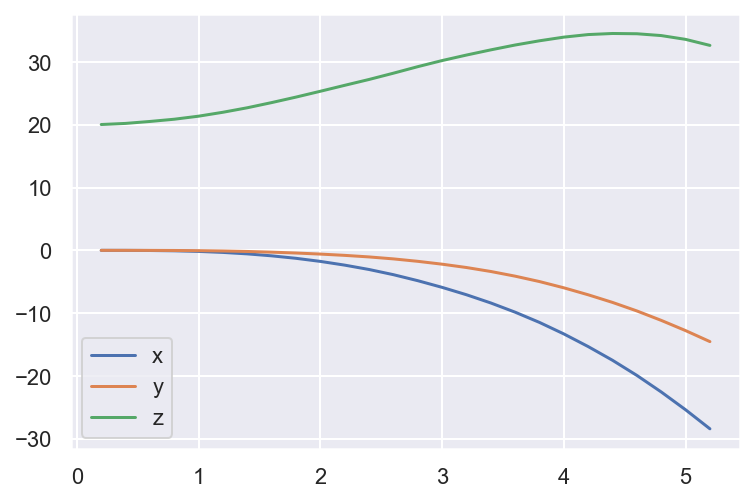

In [4]:
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

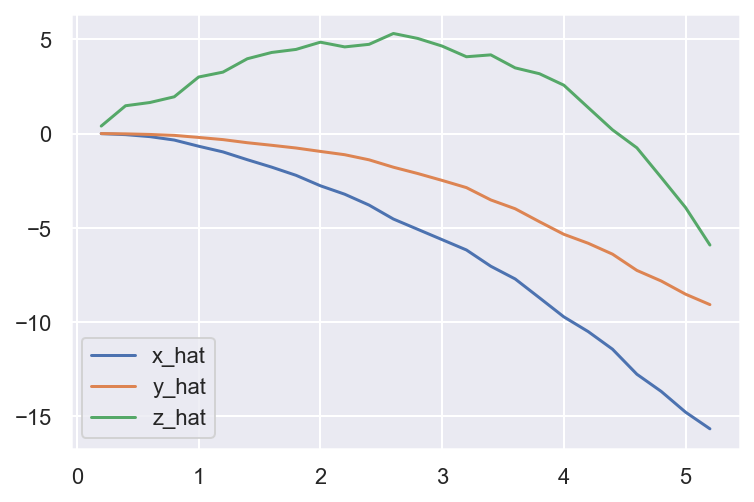

In [5]:

plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

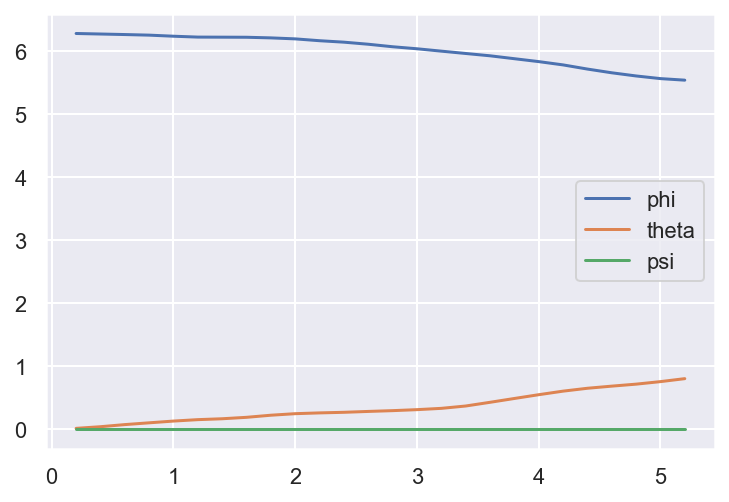

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

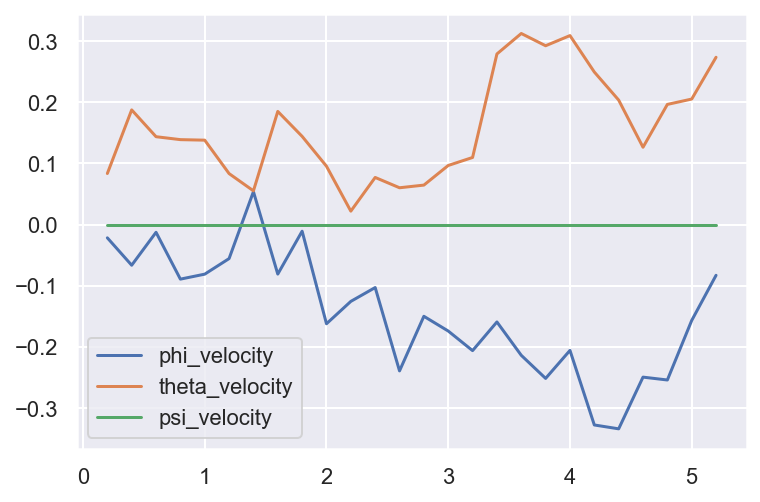

In [7]:

plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

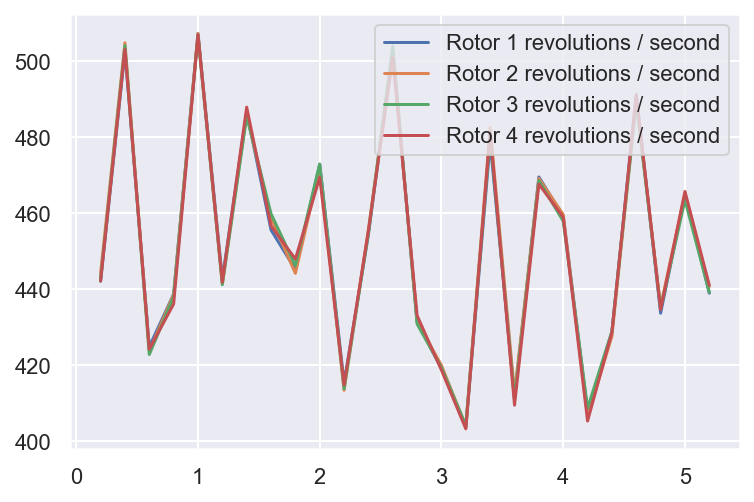

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

In [9]:

# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print("Quadcopter pose (x,y,z,phi,theta,psi):\n{}\n".format(task.sim.pose))
print("Quadcopter velocities (v_x,v_y,v_z):\n{}\n".format(task.sim.v))
print("Quadcopter angular velocities (v_phi,v_theta,v_psi):\n{}\n".format(task.sim.angular_v))

Quadcopter pose (x,y,z,phi,theta,psi):
[-28.42104489 -14.53339984  32.63253557   5.53965154   0.7973949
   0.        ]

Quadcopter velocities (v_x,v_y,v_z):
[-15.65928959  -9.07220787  -5.91350854]

Quadcopter angular velocities (v_phi,v_theta,v_psi):
[-0.08299424  0.27389056  0.        ]



In [10]:
num_episodes = 500

# define initial state variables and target for the quad to rise up to
target_pos = np.array([0., 0., 80.])
init_pose = np.array([0.,0.,40.,0.,0.,0.])

# define the task i.e to take off
task = Task(init_pose=init_pose,target_pos=target_pos,runtime=5.)

# initialize agent
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    # reset_state
    state = agent.reset_episode()
    while True:
        action = agent.act(state)
        next_state, reward, done = agent.task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")
            break
    sys.stdout.flush()

Episode =  500, score =   2.595 (best =   3.203), noise_scale = 3.2

In [11]:
# define initial state variables and target for the quad to rise up to
target_pos = np.array([0., 0., 80.])
init_pose = np.array([0.,0.,20.,0.,0.,0.])

# define the task i.e to take off
task = Task(init_pose=init_pose,target_pos=target_pos,runtime=10.)

# initialize the RL agent
agent = Agent(state_size=task.state_size,action_size=task.action_size,
              single_rotor_control=False,buffer_size=int(1e5),batch_size=128,
              gamma=0.99,tau=1e-3,lr_actor=1e-4,lr_critic=1e-3,random_seed=0)

In [12]:
# train function for the ddpg agent
def ddpg_train(agent, env=task, max_episodes=int(1e4),PRINT_EVERY=100,DISPLAY_EVERY=50):
    
    # initialize logs for storing episode rewards
    episode_rewards = []
    episode_reward_window = deque(maxlen=100)
    ###Store the average episode############
    episode_mean = []
    
    for eps_count in range(max_episodes):
        
        # initialize time step counter and online reward
        time_step = 0
        online_reward = 0
        
        # initialize logs for storing quad movements
        state_log, action_log, v_log, angular_v_log = [],[],[],[]
        
        # reset agent
        state = env.reset()
        
        while True:
            # choose agent action
            action = agent.act(state)
            
            # map action to appropriate range
            #action_ = action
            action_ = (env.action_high - env.action_low)*(action+1)/2 + env.action_low
            
            # take the next step in the env using the above action
            next_state,reward,done = env.step(action_)
            
            # take agent update step
            agent.step(state, action, reward, next_state, done)
            
            # update quad movement logs
            state_log.append(env.sim.pose)
            action_log.append(action_)
            v_log.append(env.sim.v)
            angular_v_log.append(env.sim.angular_v)
            
            # update online reward and time-step counter
            online_reward += reward
            time_step += 1
            
            # update state
            state = next_state
            
            if done:
                # update episode rewards log
                episode_rewards.append(online_reward)
                episode_reward_window.append(online_reward)
                break

        # print training progress
        if eps_count%PRINT_EVERY == 0:
            episode_mean.append(np.mean(episode_reward_window))
            print ("Episode: {}\t Avg reward: {:.2f}\t Current reward: {:.2f}\t Episode length: {}\n".format(eps_count,
                                                            np.mean(episode_reward_window),online_reward,time_step))
        # visualize quad movements
        if eps_count%DISPLAY_EVERY == 0:
            # figure
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

            # plot (x,y,z) movements of the quad
            state_log = np.array(state_log)
            labels = ['x','y','z']
            for i in range(len(labels)):
                ax[0,0].plot(state_log[:,i],label=labels[i])
            ax[0,0].set_ylim([-10,120])
            ax[0,0].set_xlim([-10,100])
            ax[0,0].legend()
            #ax[0,0].set_xlabel('timesteps')

            # plot rotor speeds of the quad
            action_log = np.array(action_log)
            labels = ['rotor 1 speed','rotor 2 speed','rotor 3 speed','rotor 4 speed']
            for i in range(len(labels)):
                ax[0,1].plot(action_log[:,i],label=labels[i])
            ax[0,1].set_ylim([-100,1000])
            ax[0,1].set_xlim([-10,100])
            ax[0,1].legend()
            #ax[0,1].set_xlabel('timesteps')

            # plot movements of the quad along the euler angles (phi,theta,psi)
            labels = ['phi','theta','psi']
            for i in range(len(labels)):
                ax[1,0].plot(state_log[:,3+i],label=labels[i])
            ax[1,0].set_ylim([-10,10])
            ax[1,0].set_xlim([-10,100])
            ax[1,0].legend()
            ax[1,0].set_xlabel('timesteps')

            # plot angular velocities of the quad along the 3 main axis
            angular_v_log = np.array(angular_v_log)
            labels = ['v_phi','v_theta','v_psi']
            for i in range(len(labels)):
                ax[1,1].plot(angular_v_log[:,i],label=labels[i])
            ax[1,1].set_ylim([-10,10])
            ax[1,1].set_xlim([-10,100])
            ax[1,1].legend()
            ax[1,1].set_xlabel('timesteps')

            fig.suptitle("Quadcopter movement visualization for episode: {}".format(eps_count))
            plt.show()
            
    return episode_rewards, episode_mean

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 0	 Avg reward: 18.67	 Current reward: 18.67	 Episode length: 11



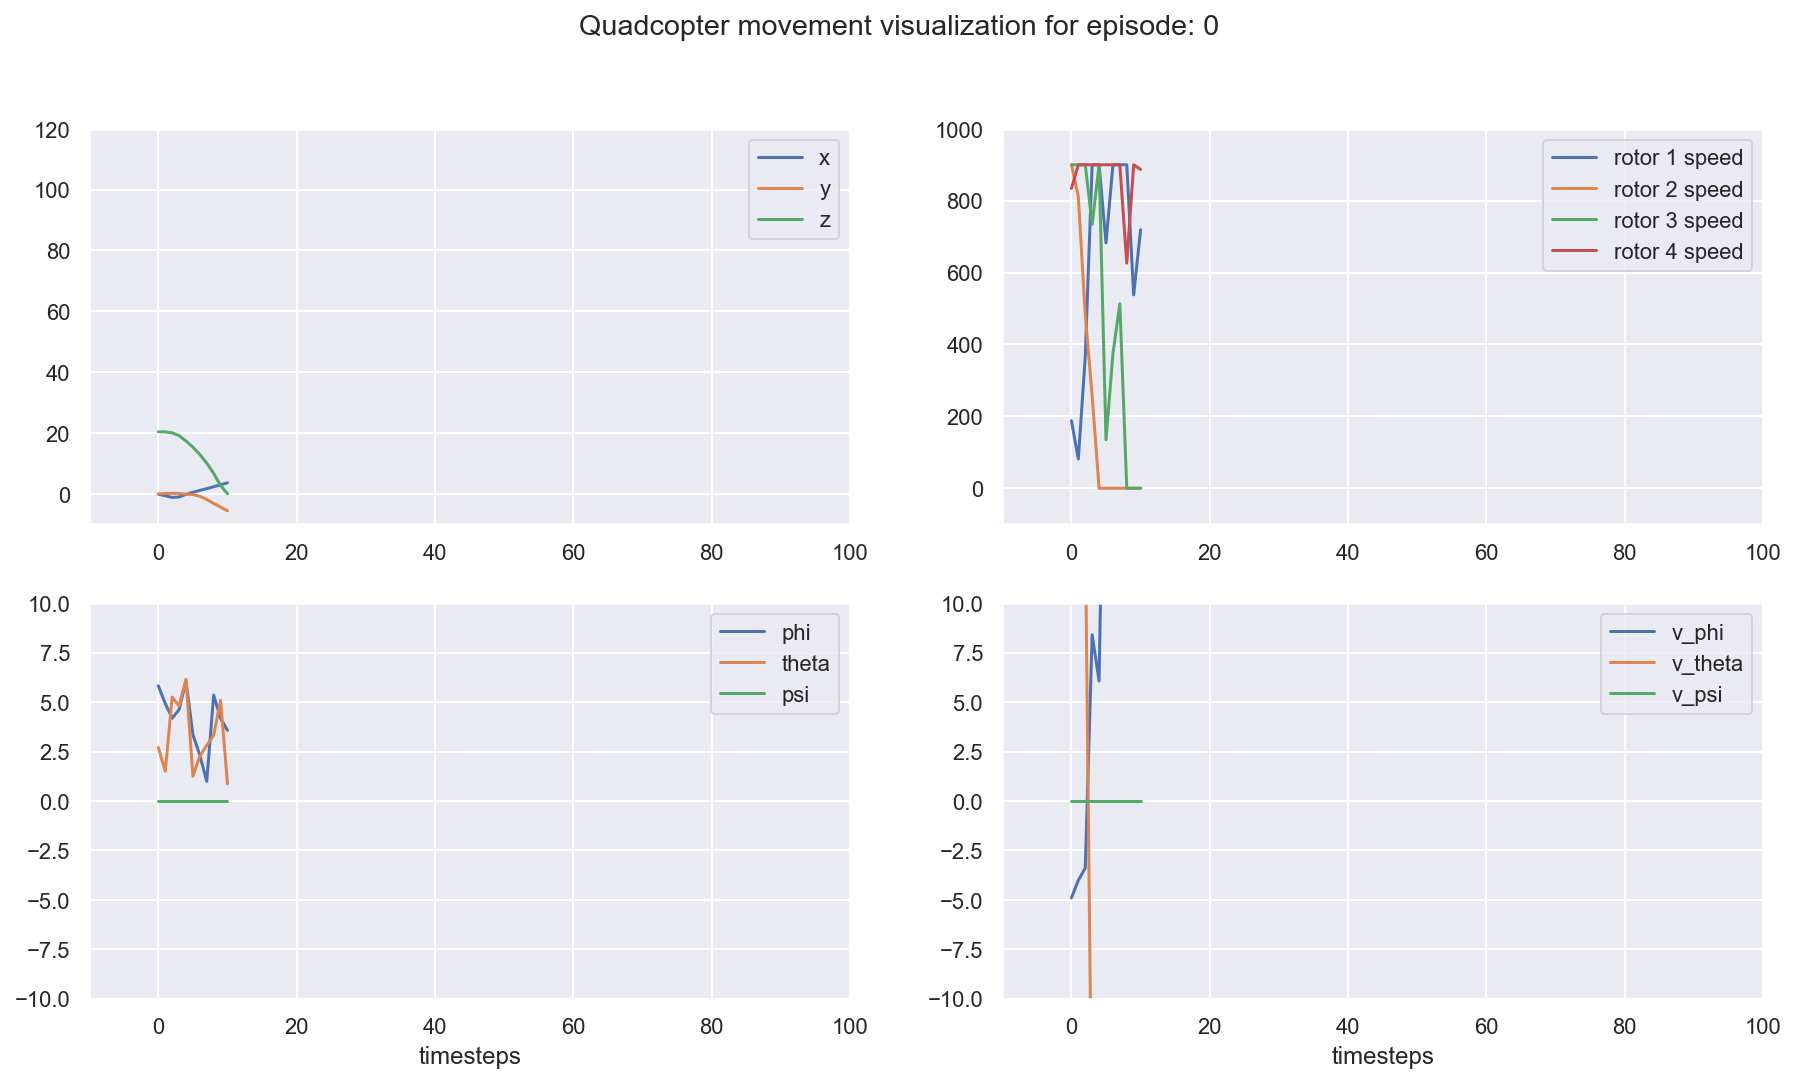

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 200	 Avg reward: 27.52	 Current reward: 27.08	 Episode length: 15



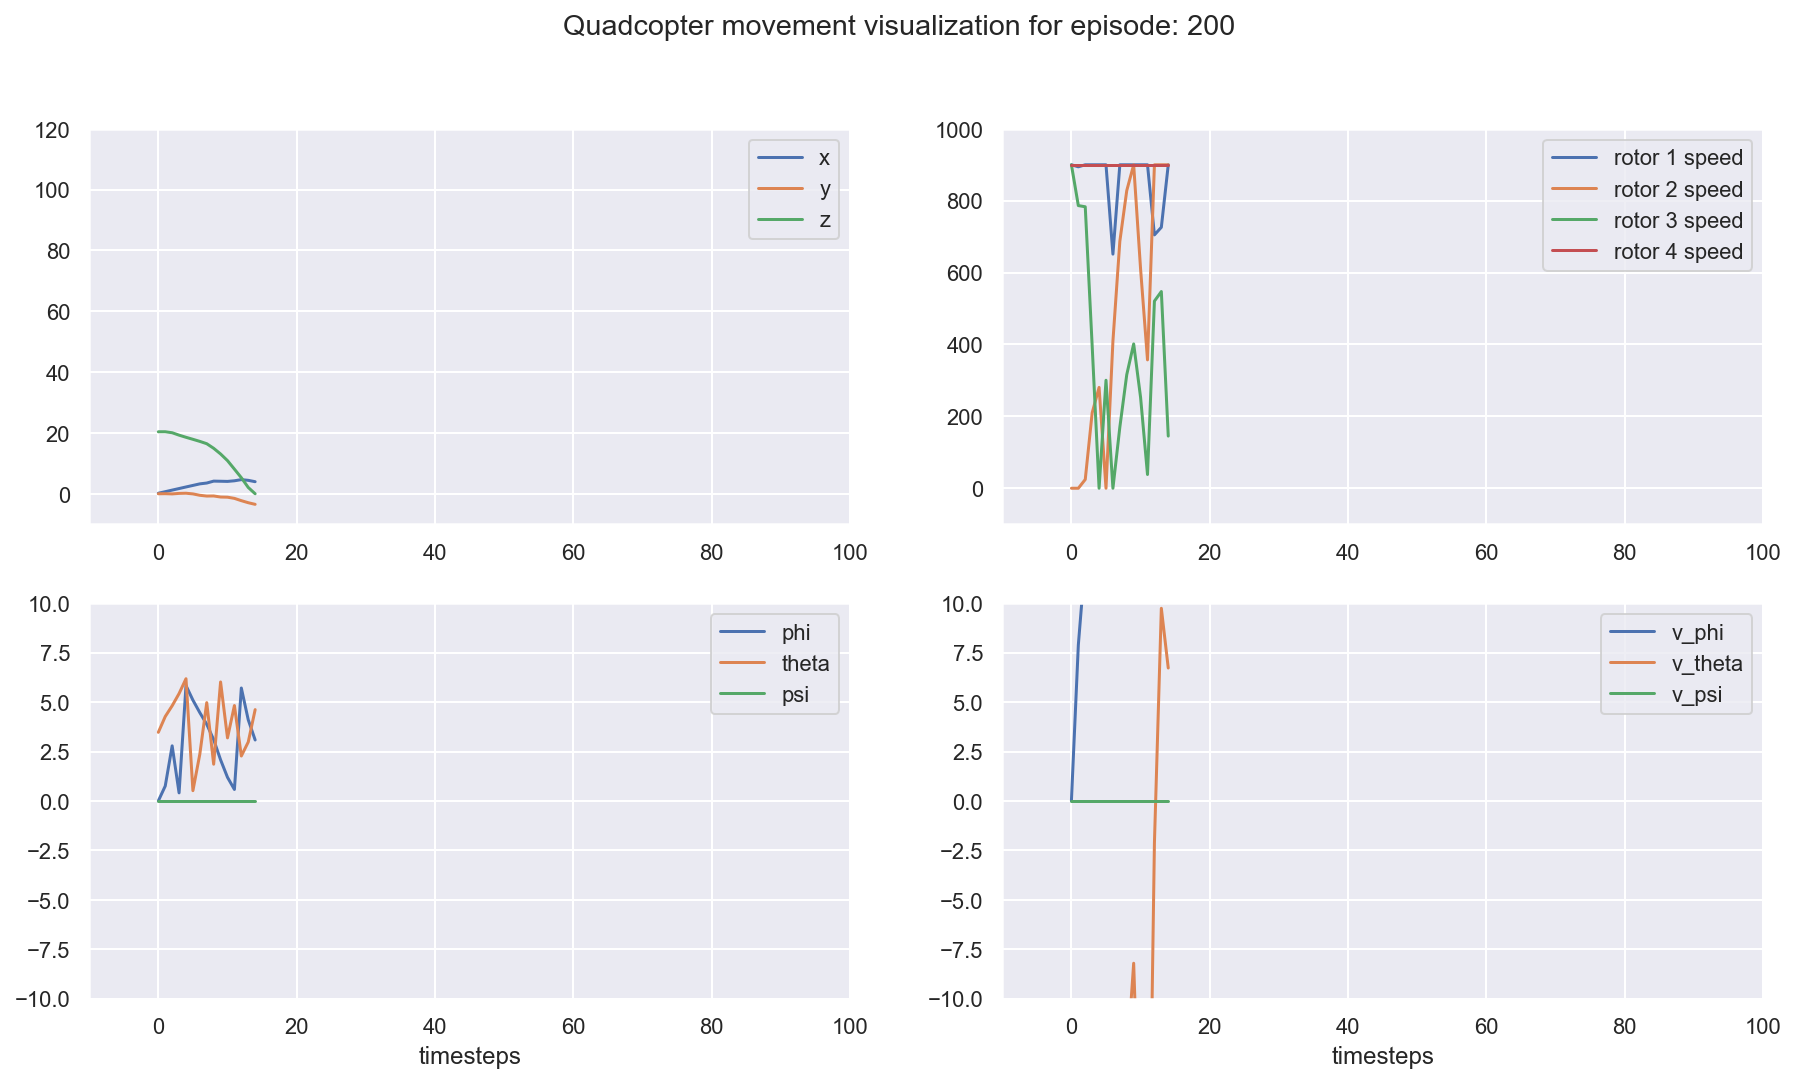

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 400	 Avg reward: 26.35	 Current reward: 18.89	 Episode length: 10



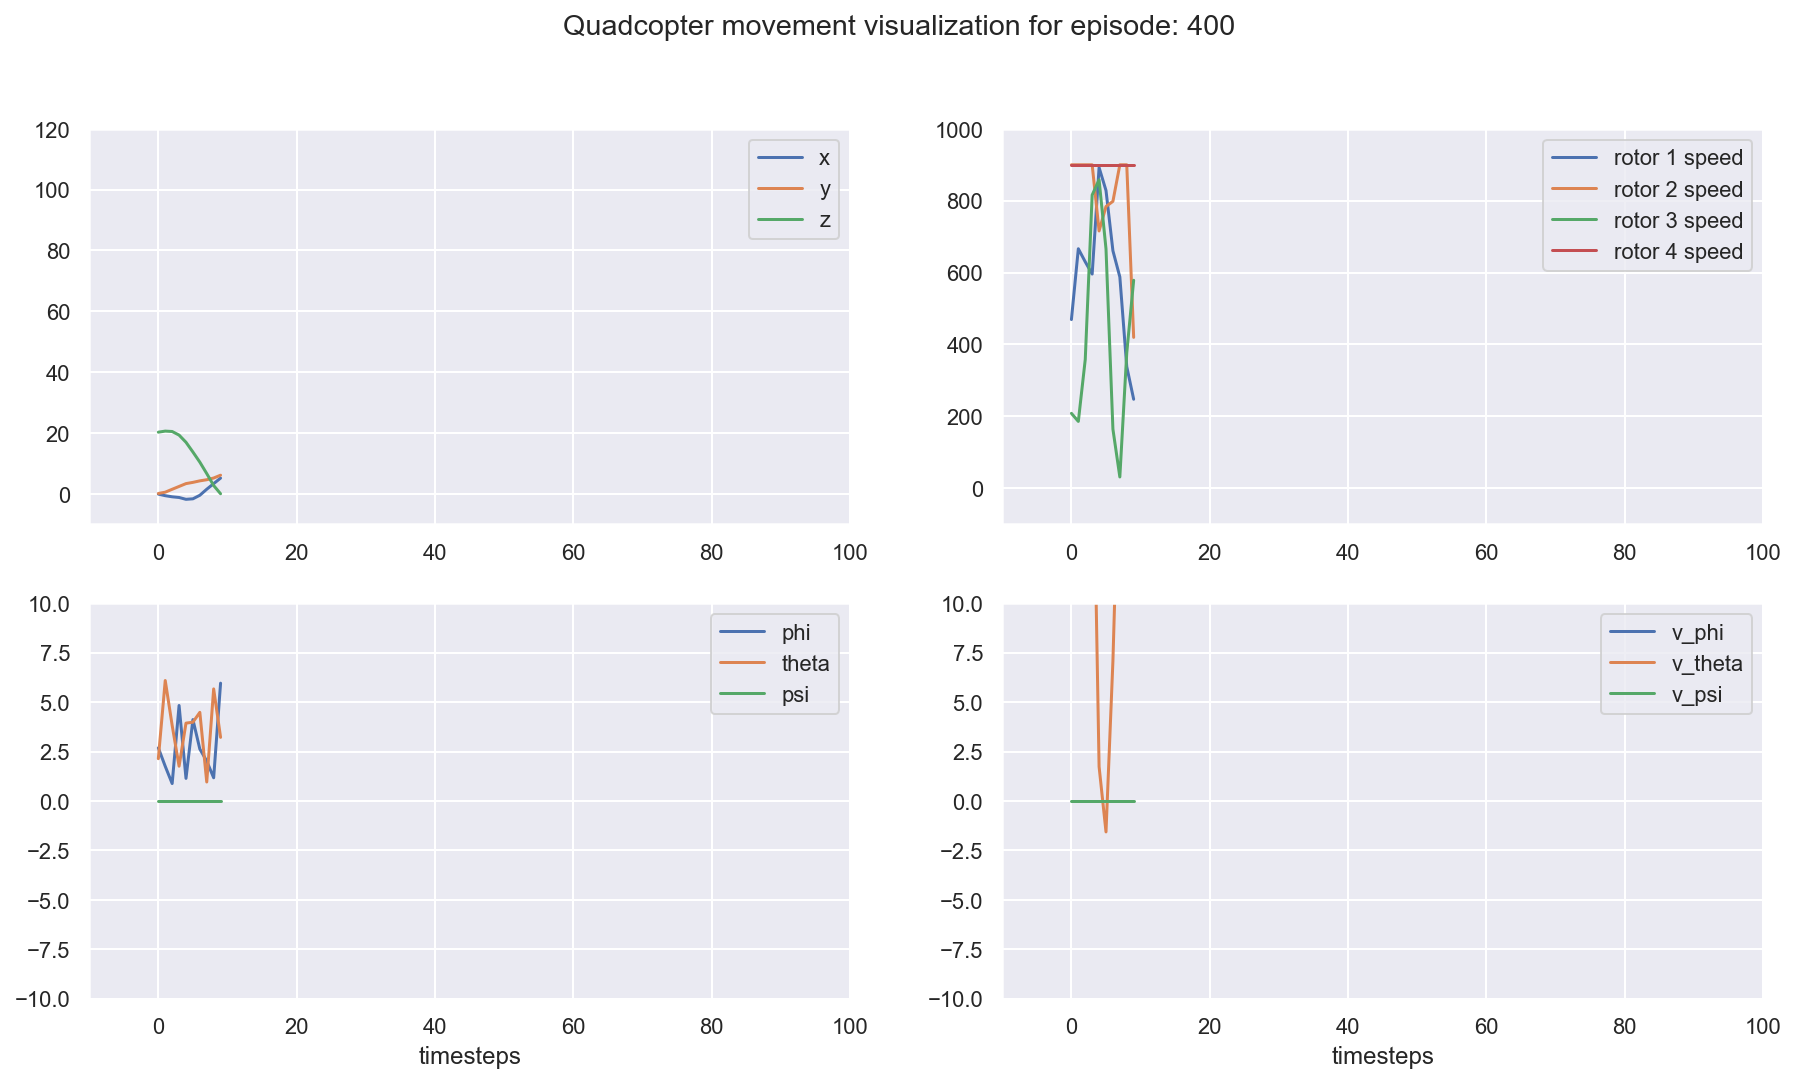

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 600	 Avg reward: 26.07	 Current reward: 16.32	 Episode length: 10



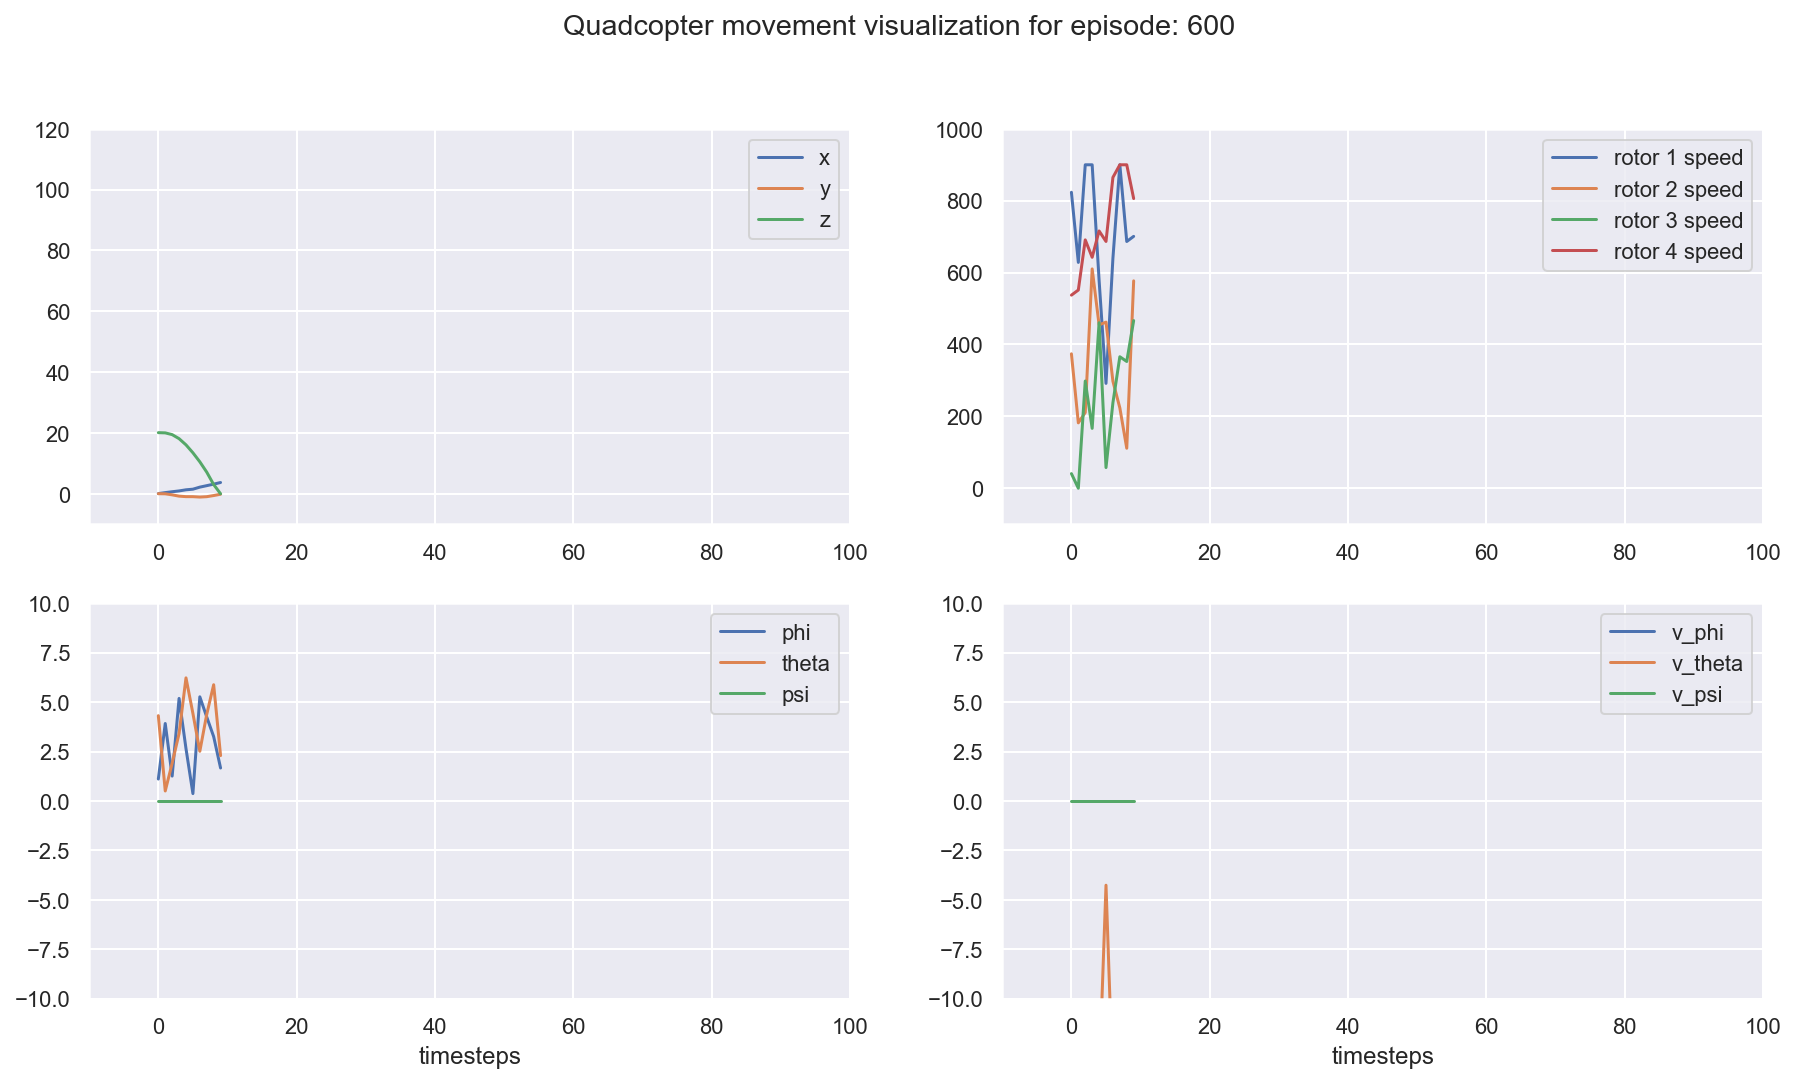

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 800	 Avg reward: 26.90	 Current reward: 21.06	 Episode length: 12



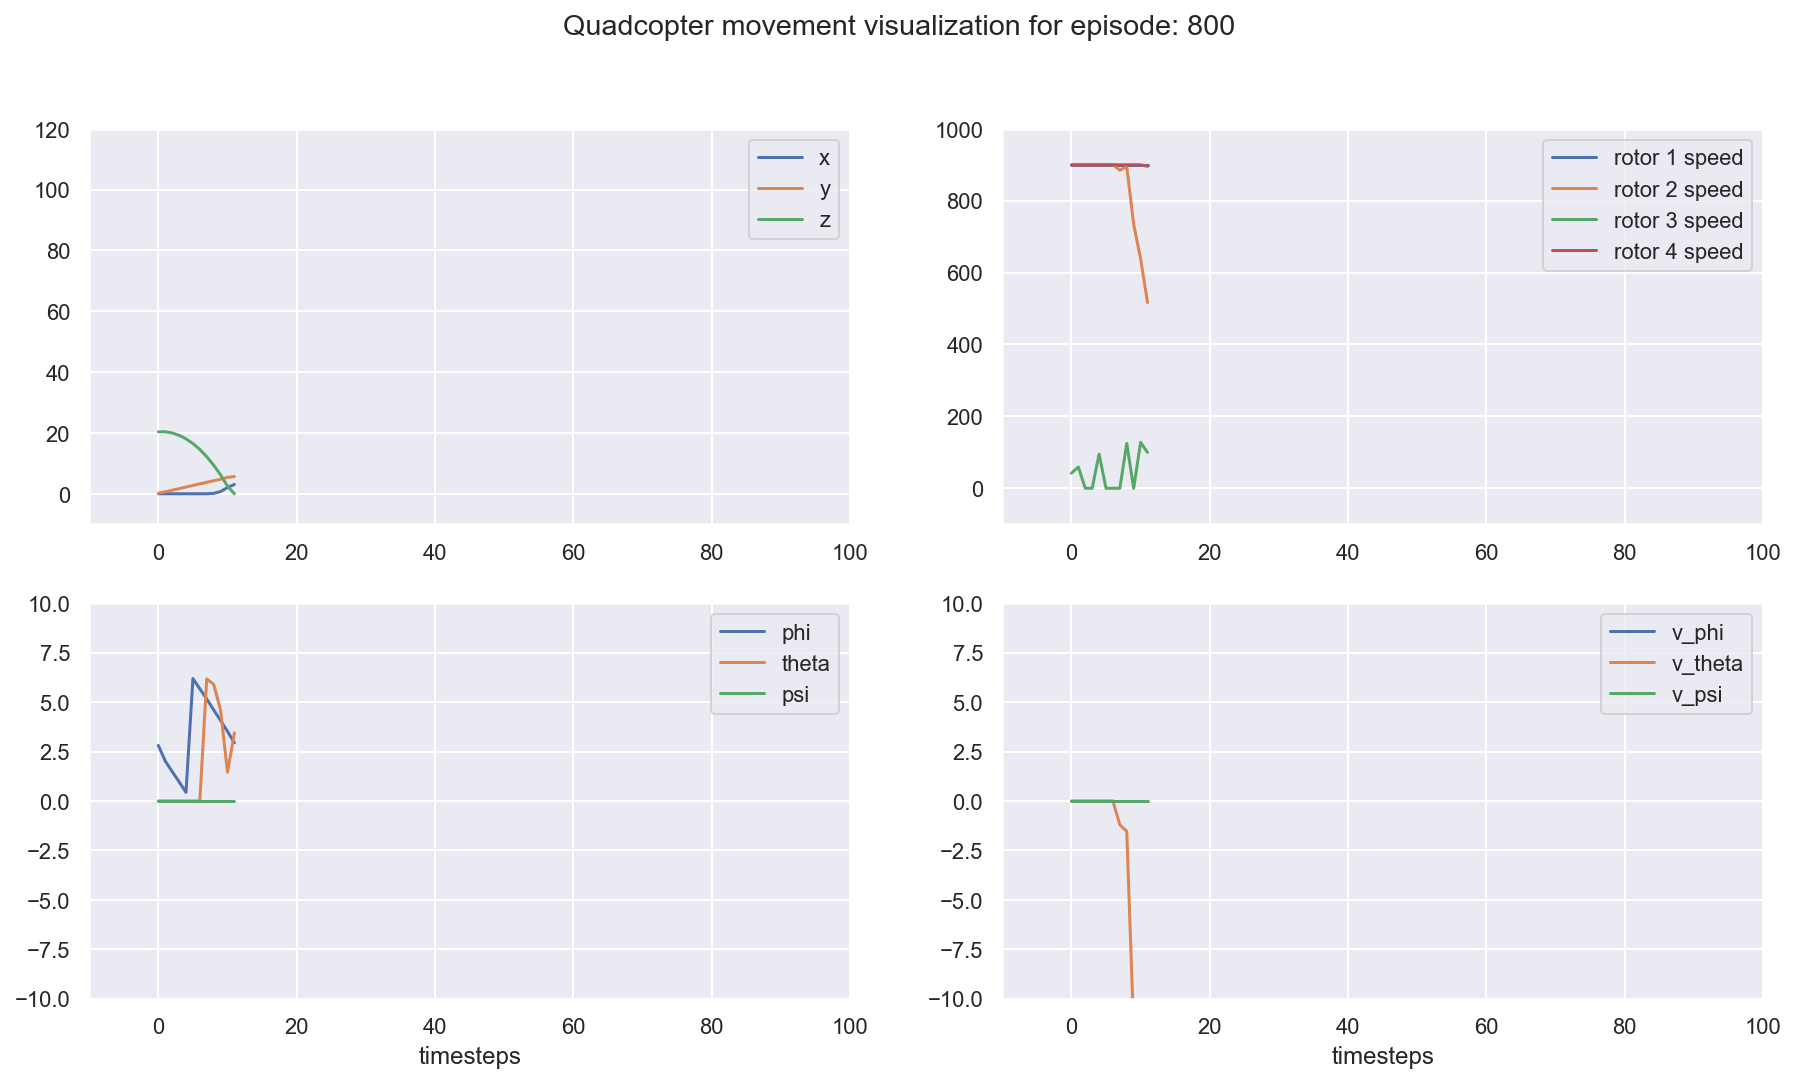

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1000	 Avg reward: 25.99	 Current reward: 21.60	 Episode length: 11



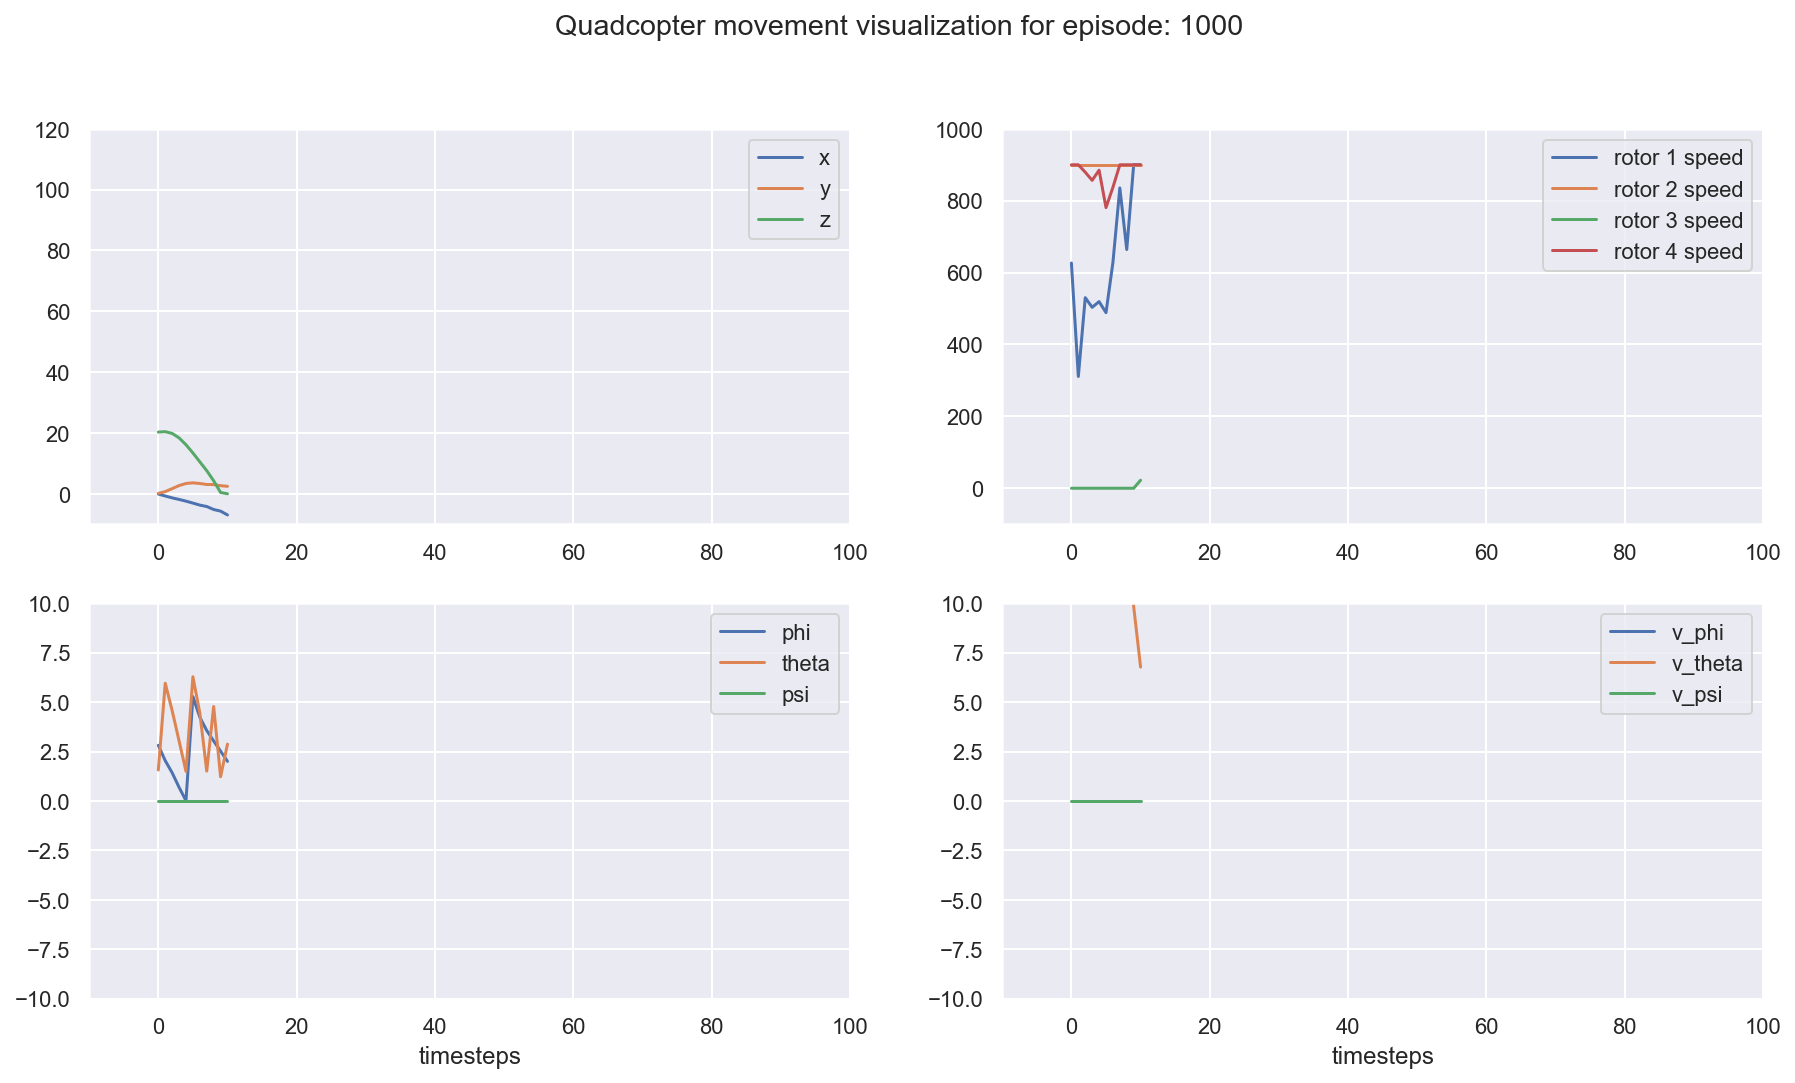

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1200	 Avg reward: 26.49	 Current reward: 26.44	 Episode length: 12



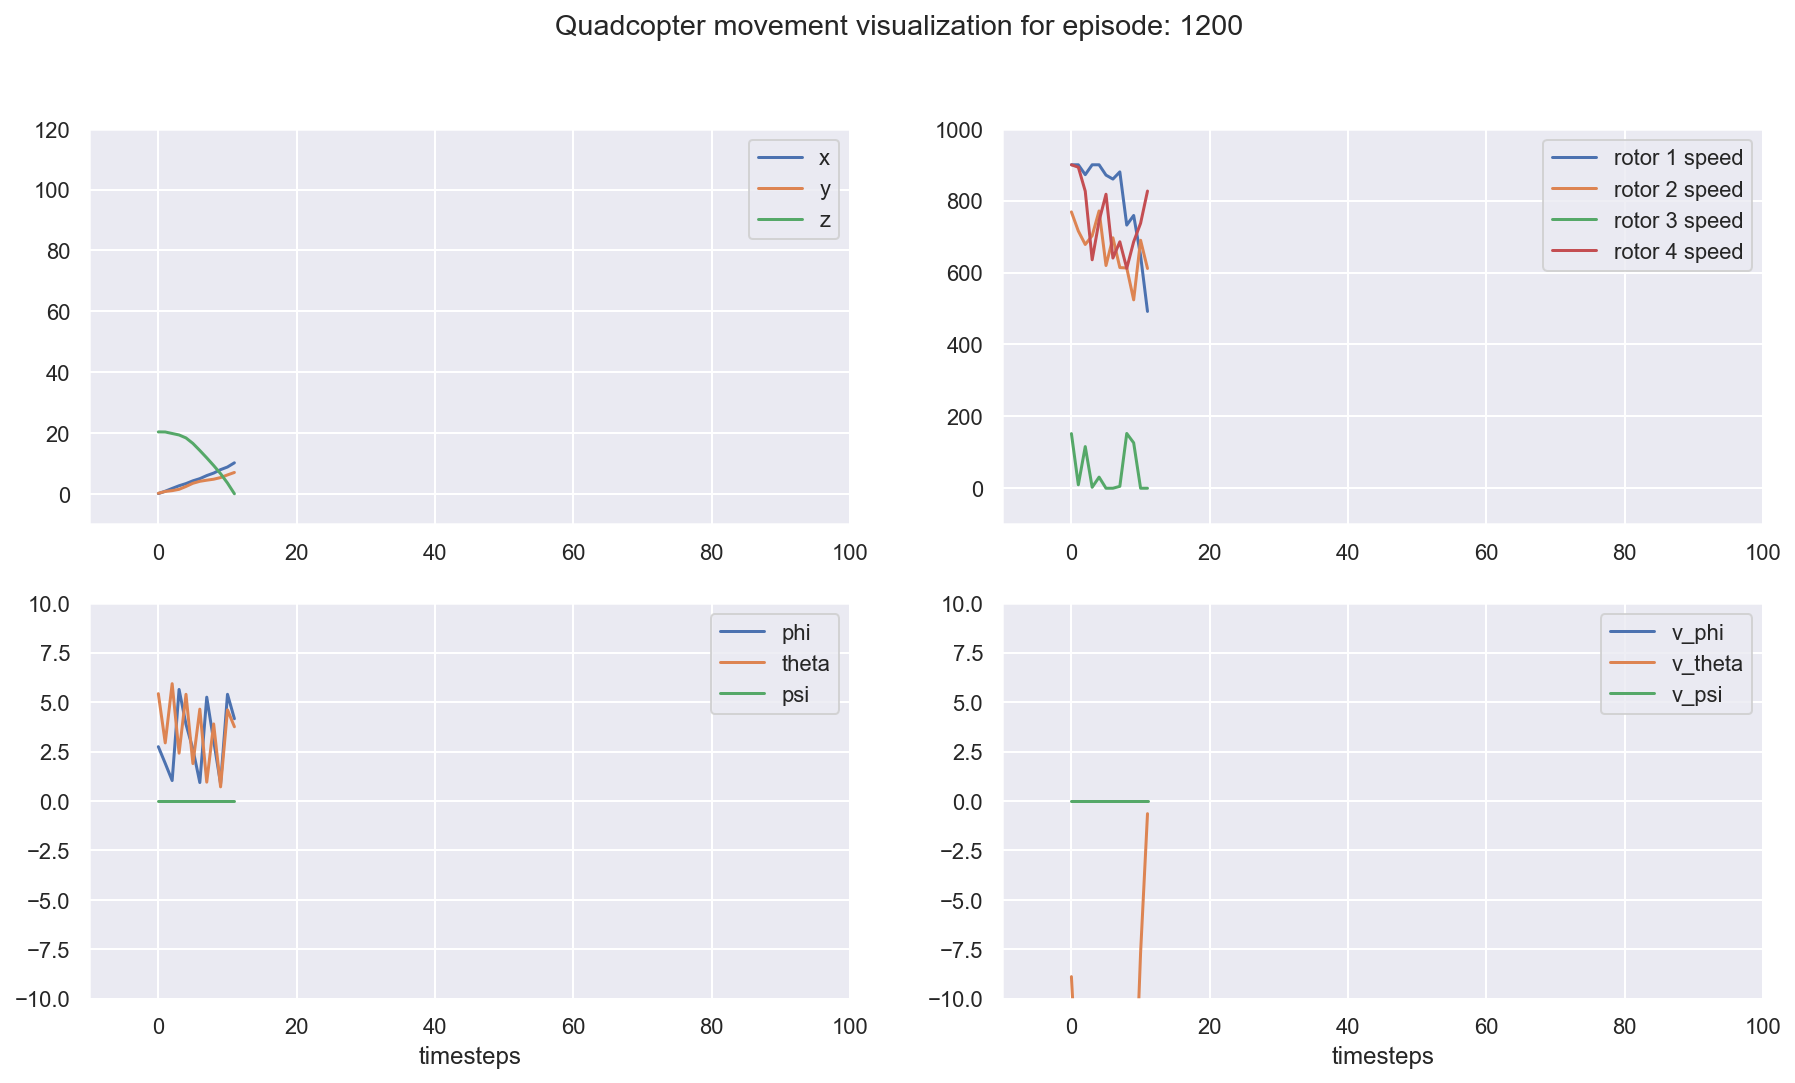

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1400	 Avg reward: 26.74	 Current reward: 22.26	 Episode length: 12



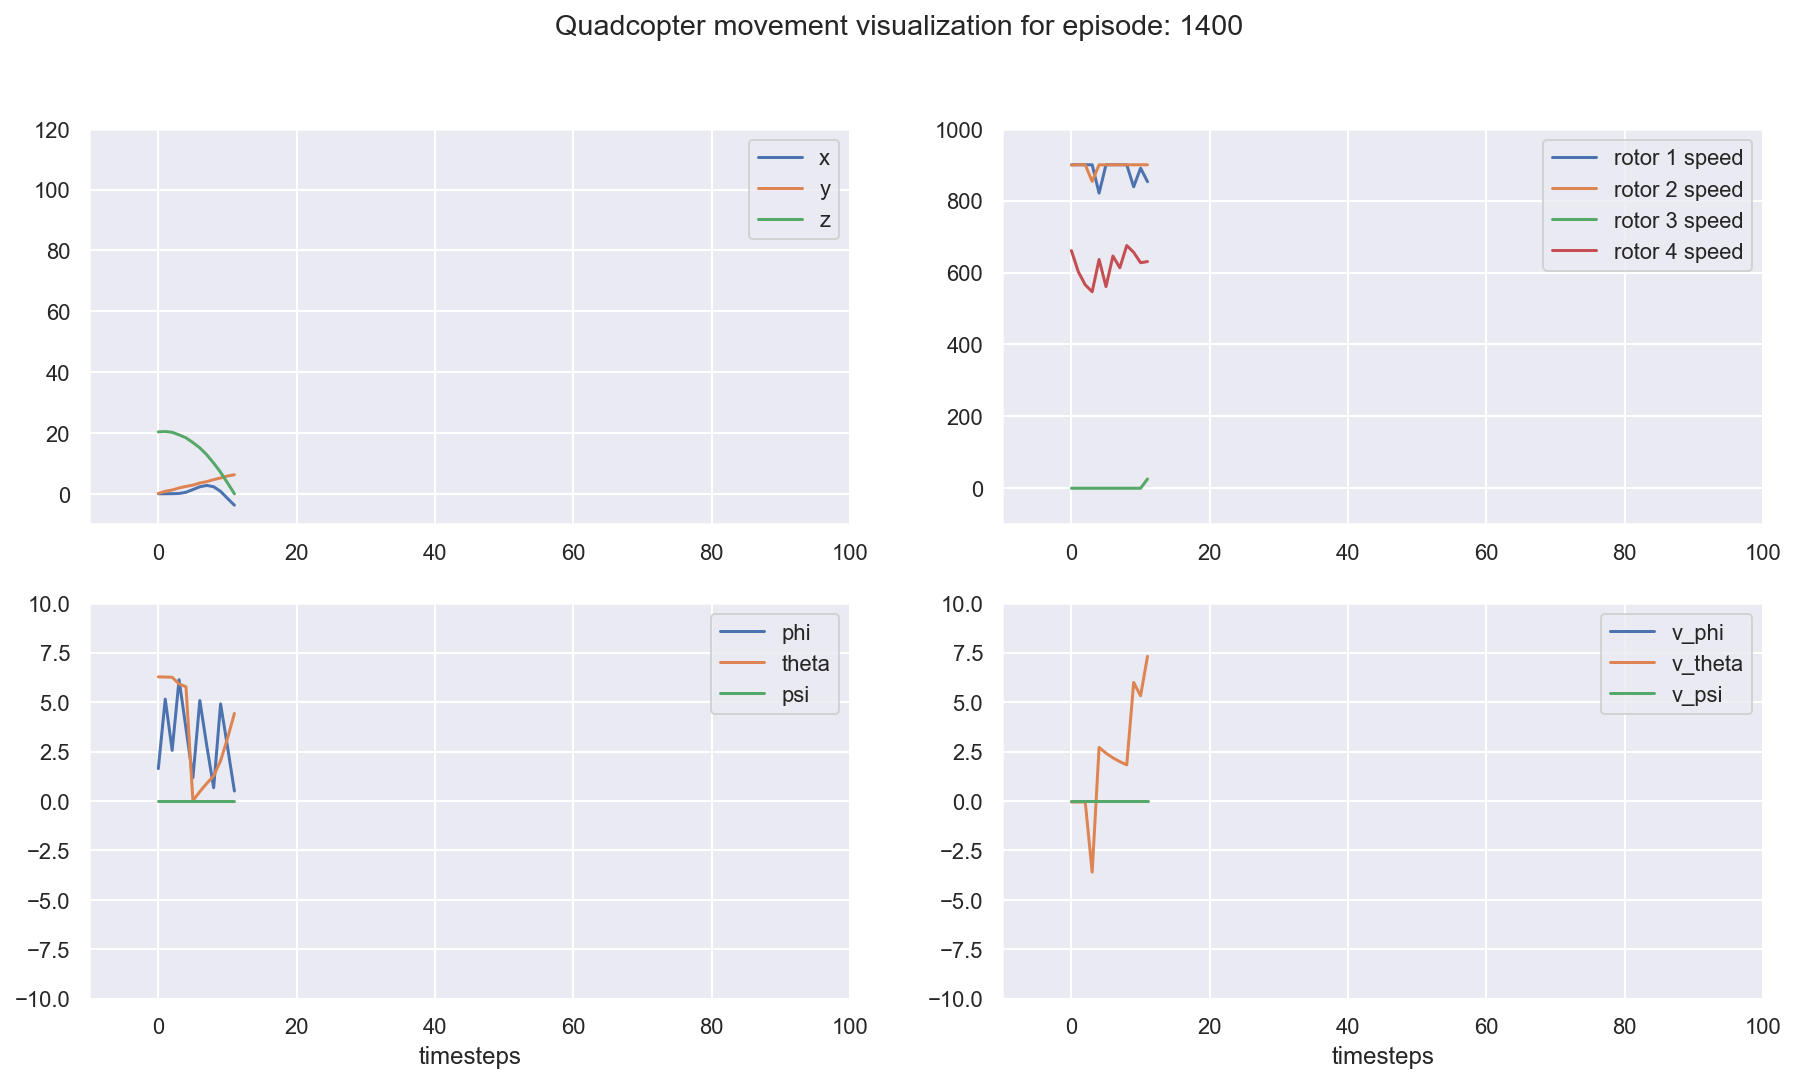

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1600	 Avg reward: 26.27	 Current reward: 30.49	 Episode length: 12



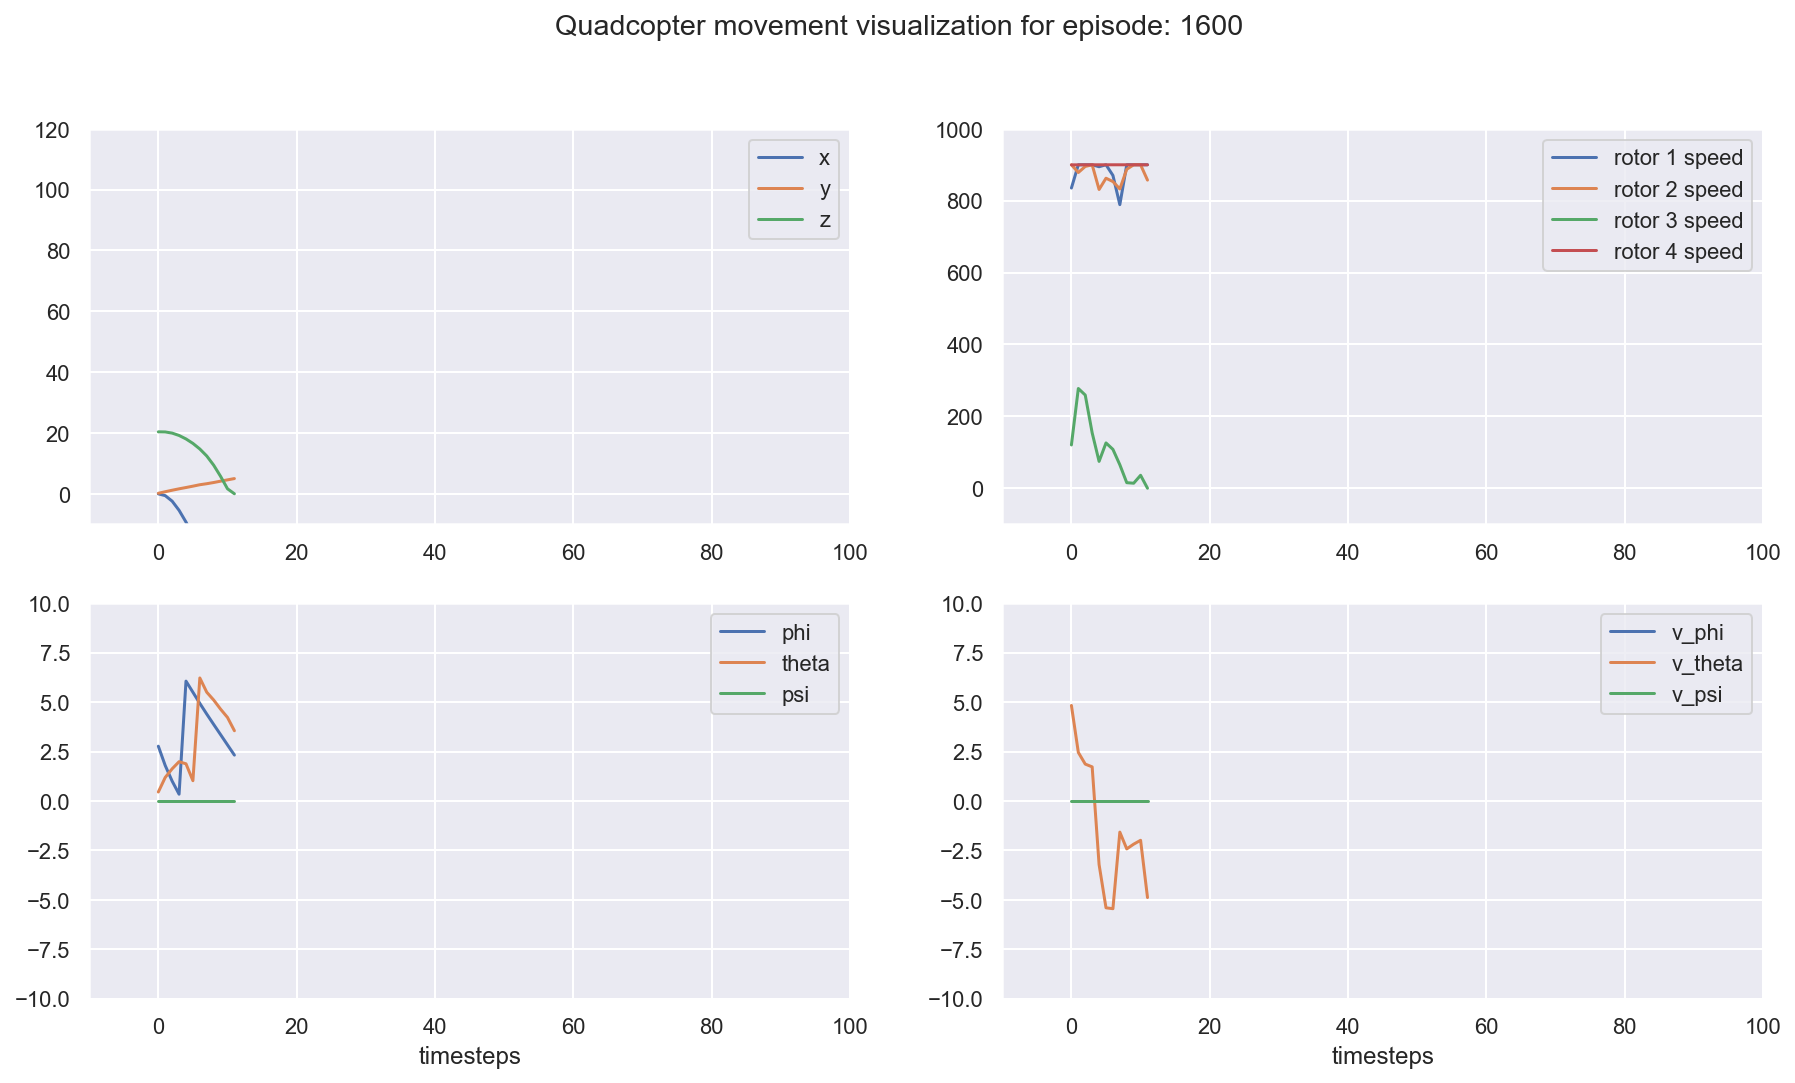

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1800	 Avg reward: 23.64	 Current reward: 20.51	 Episode length: 12



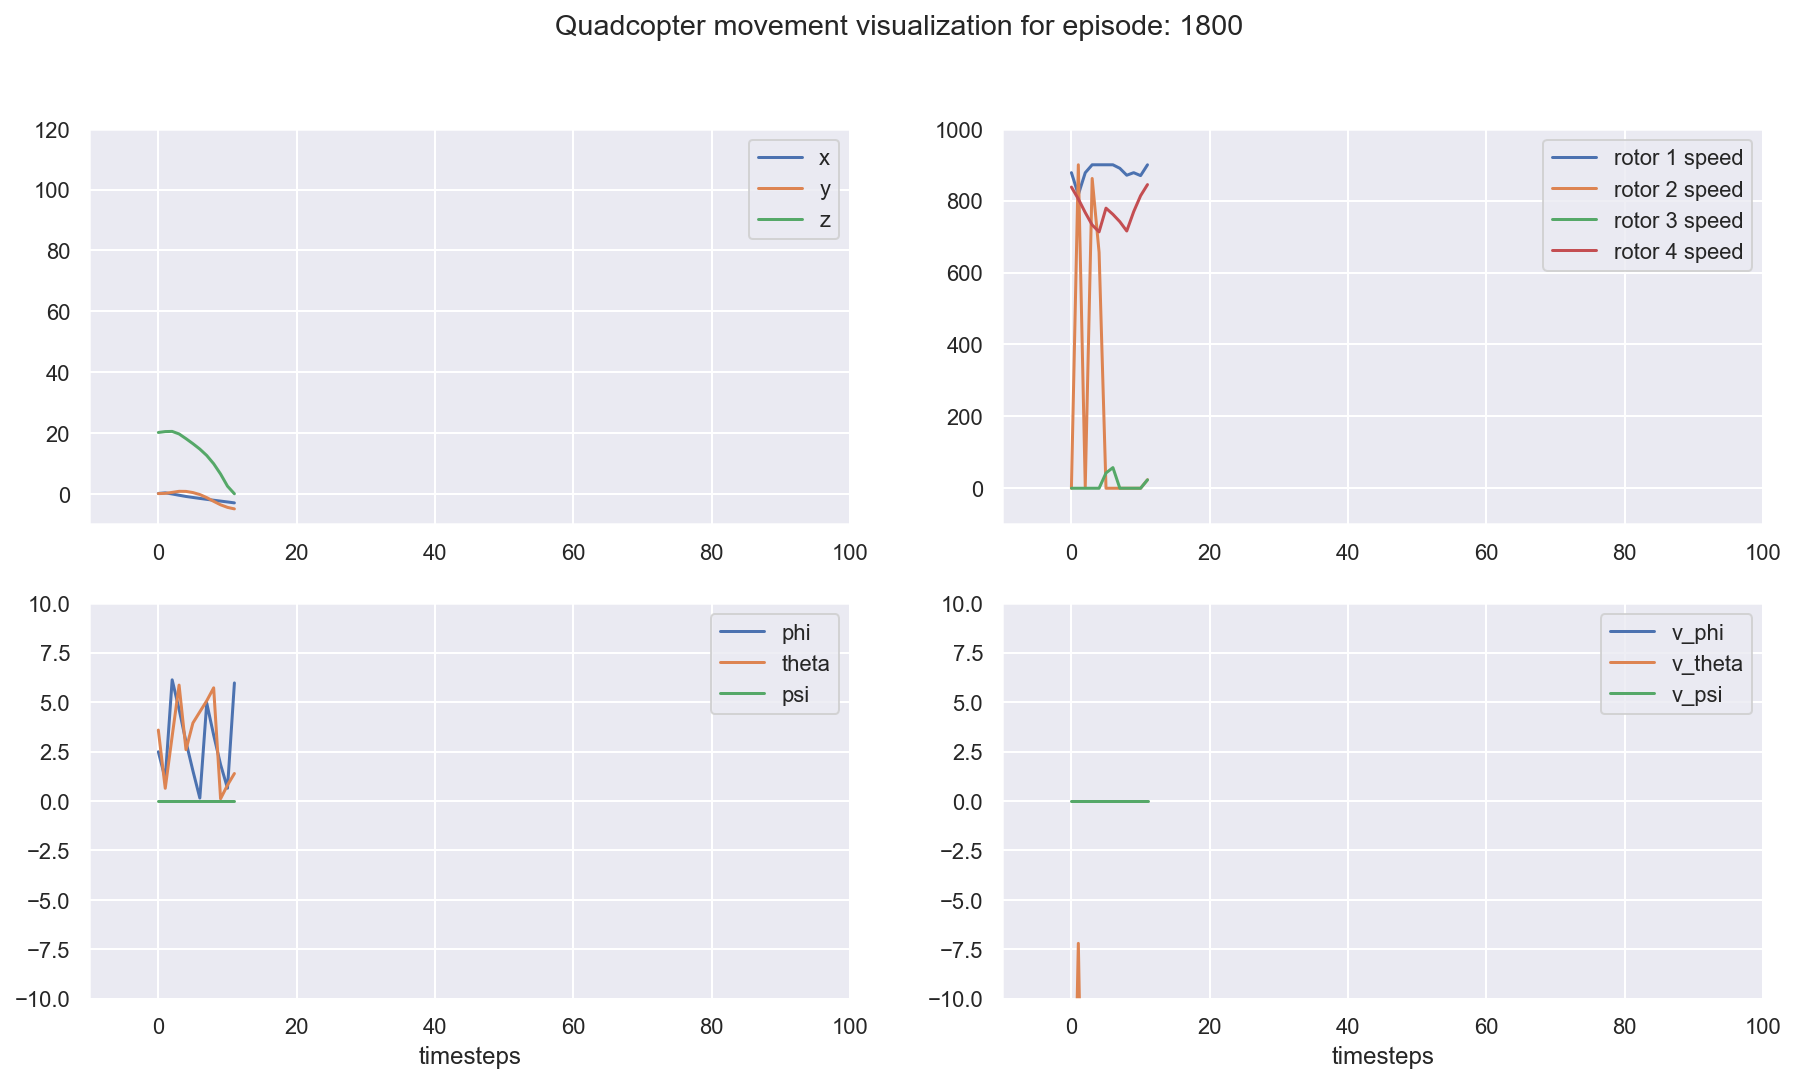

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 2000	 Avg reward: 23.72	 Current reward: 28.22	 Episode length: 12



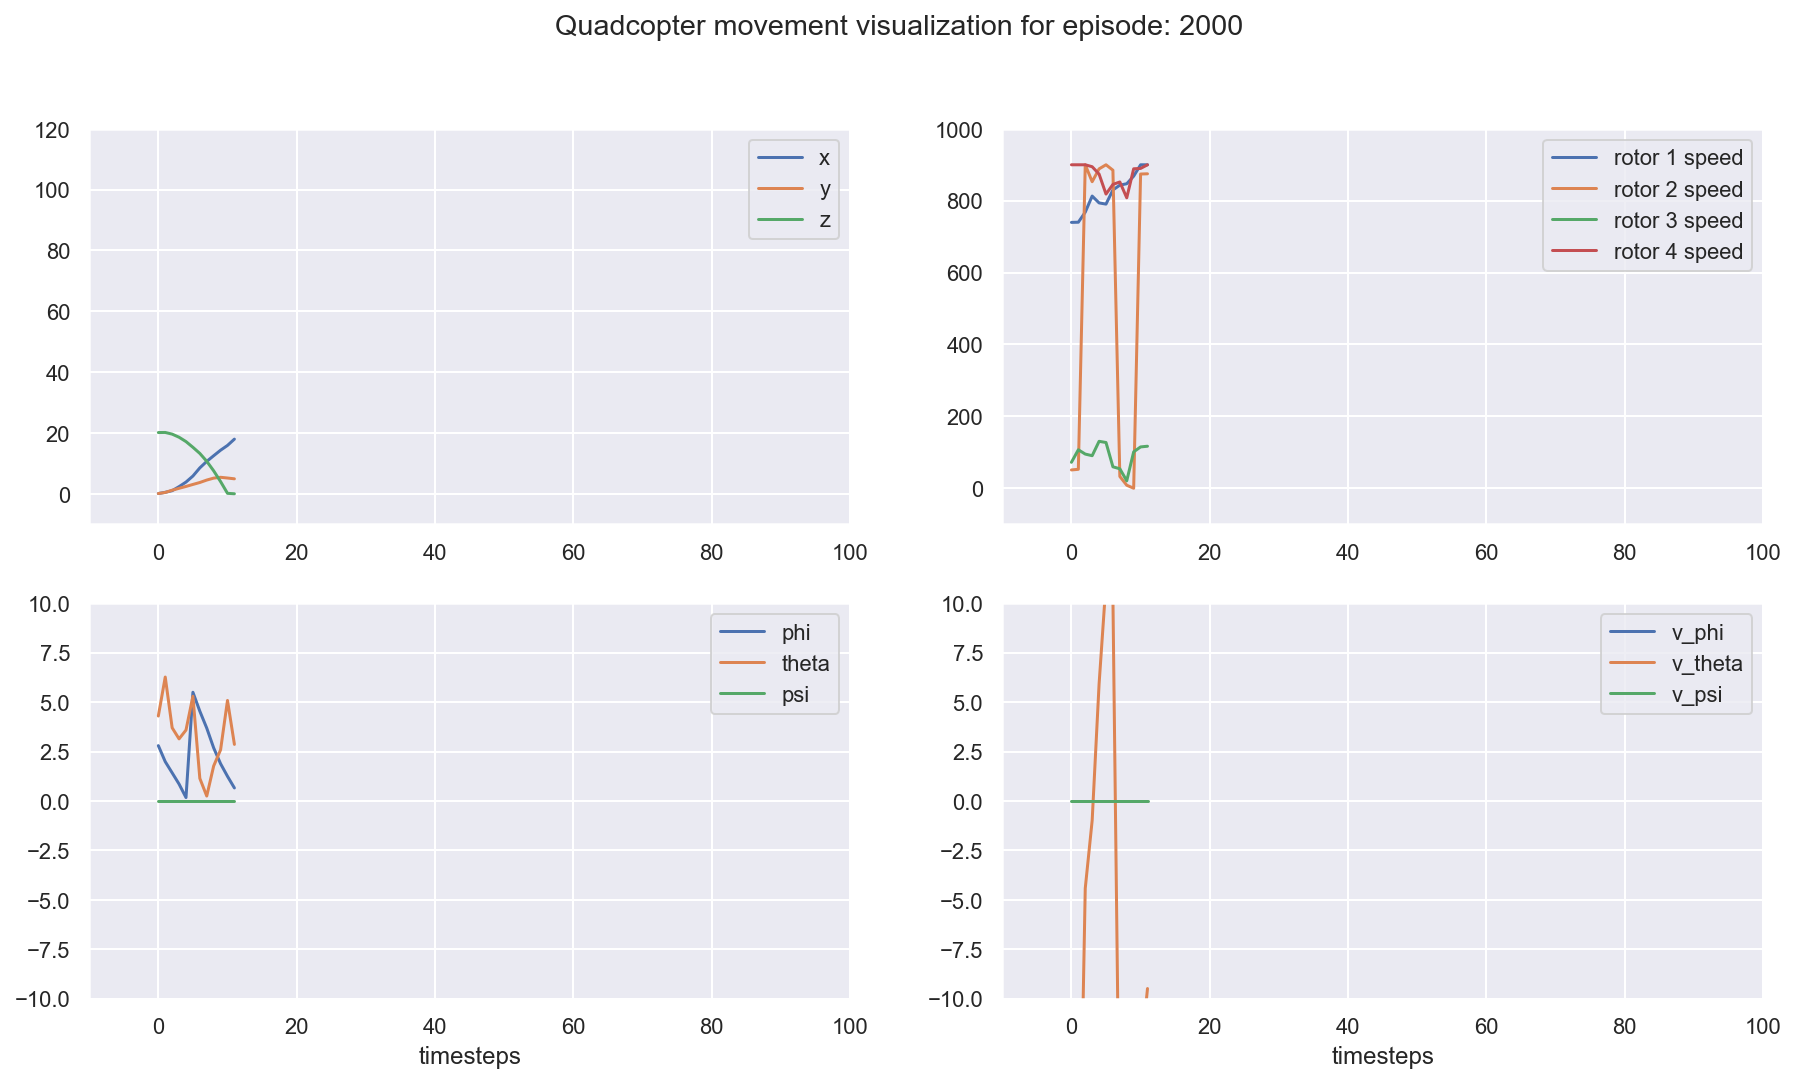

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 2200	 Avg reward: 44.32	 Current reward: 91.40	 Episode length: 32



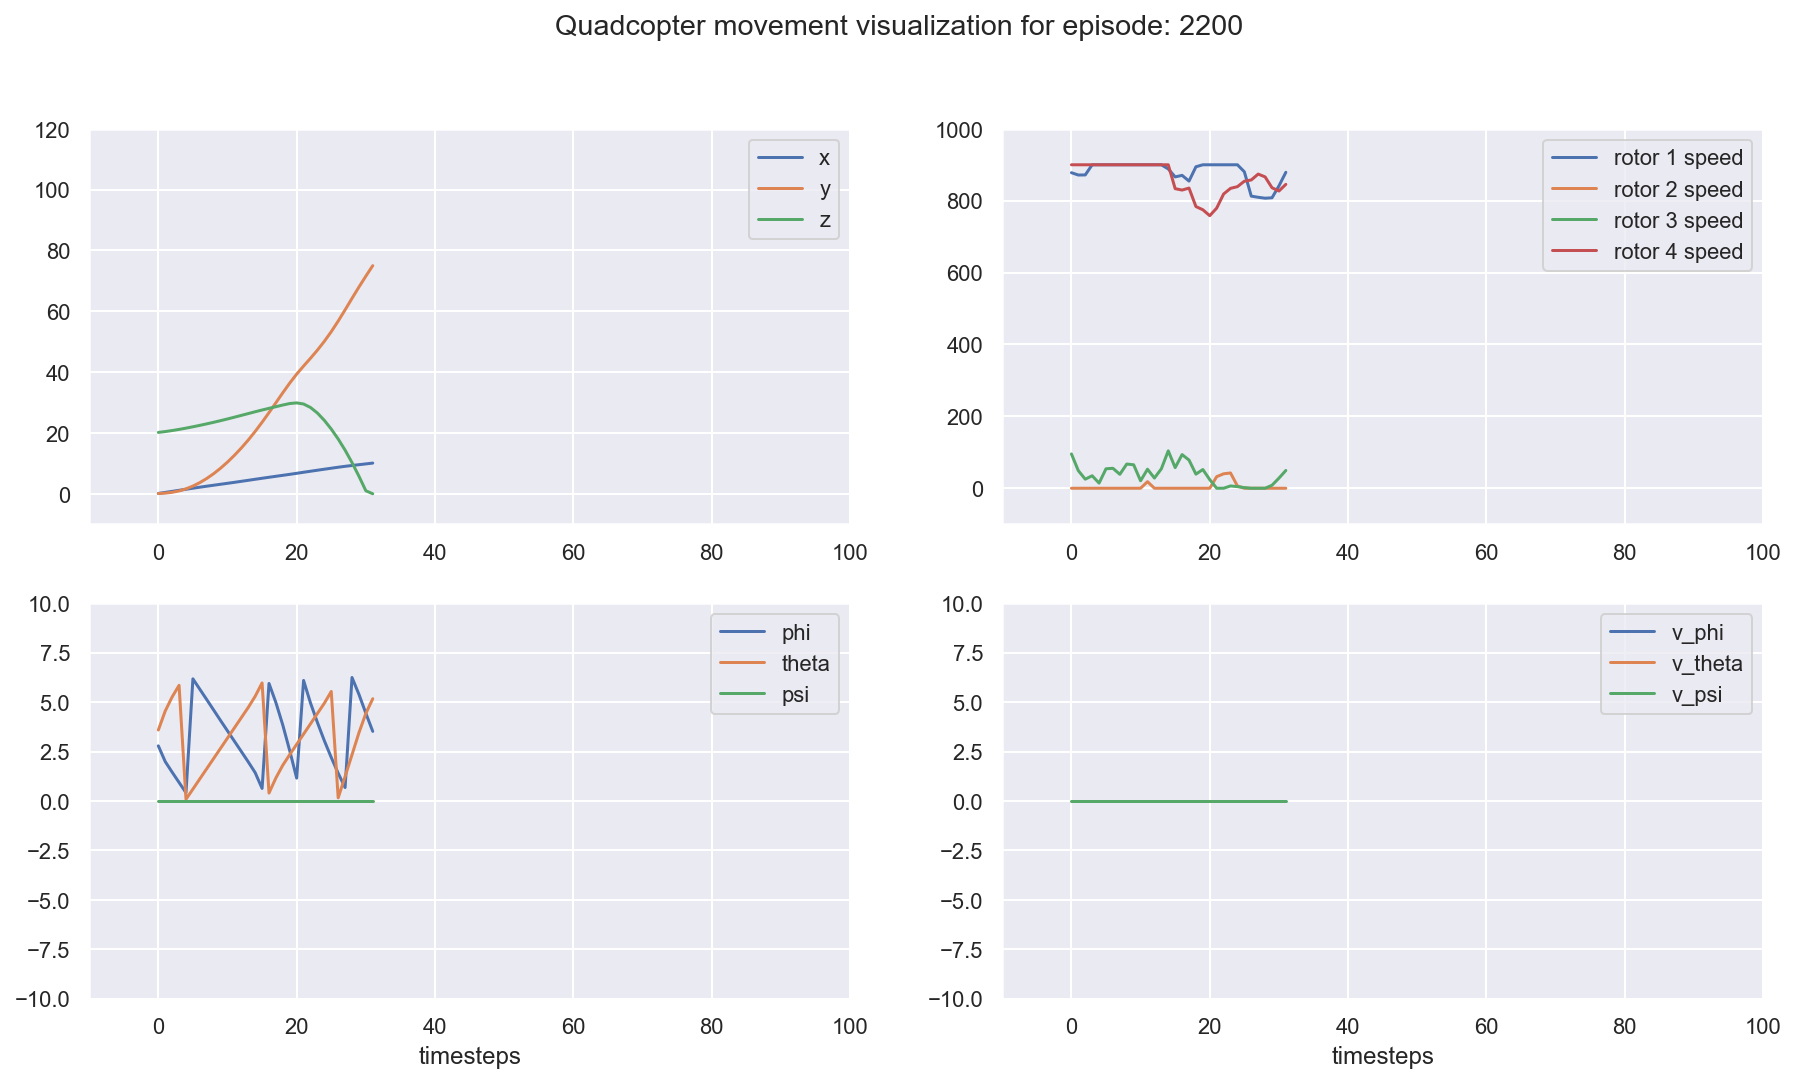

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 2400	 Avg reward: 89.01	 Current reward: 133.52	 Episode length: 51



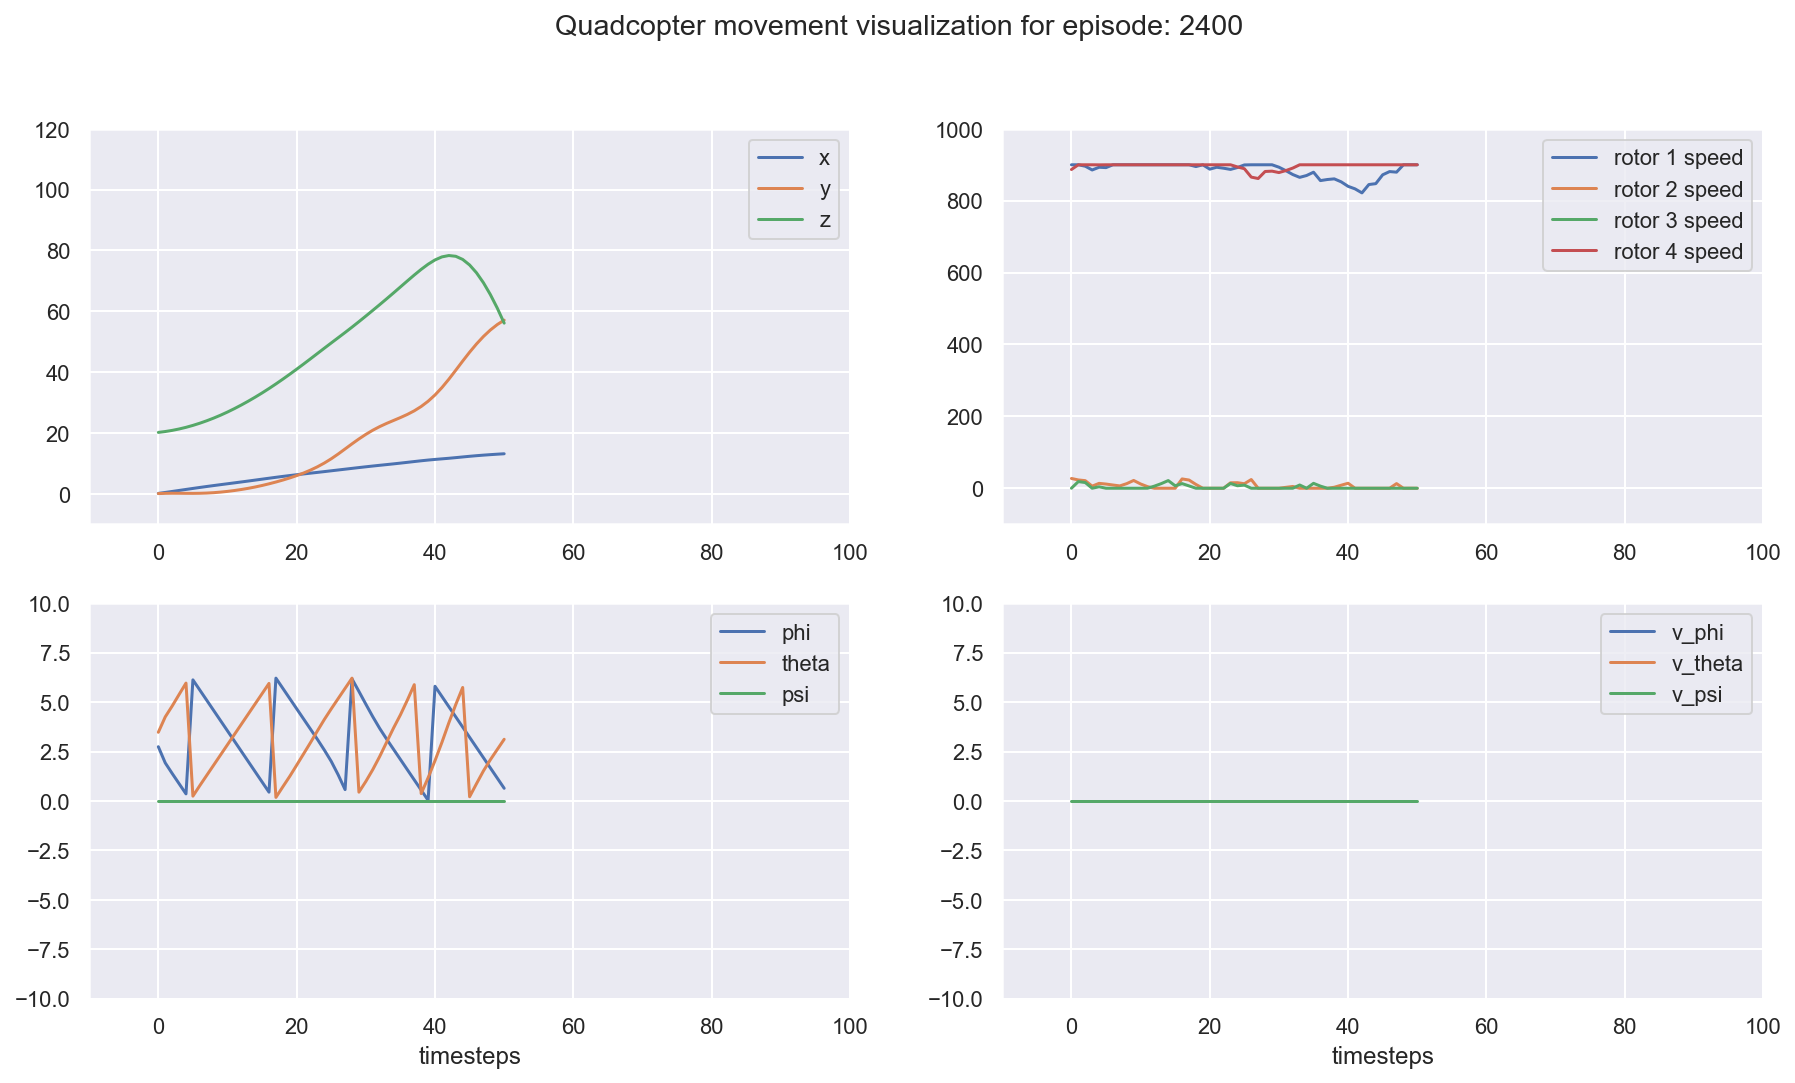

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 2600	 Avg reward: 117.11	 Current reward: 78.16	 Episode length: 34



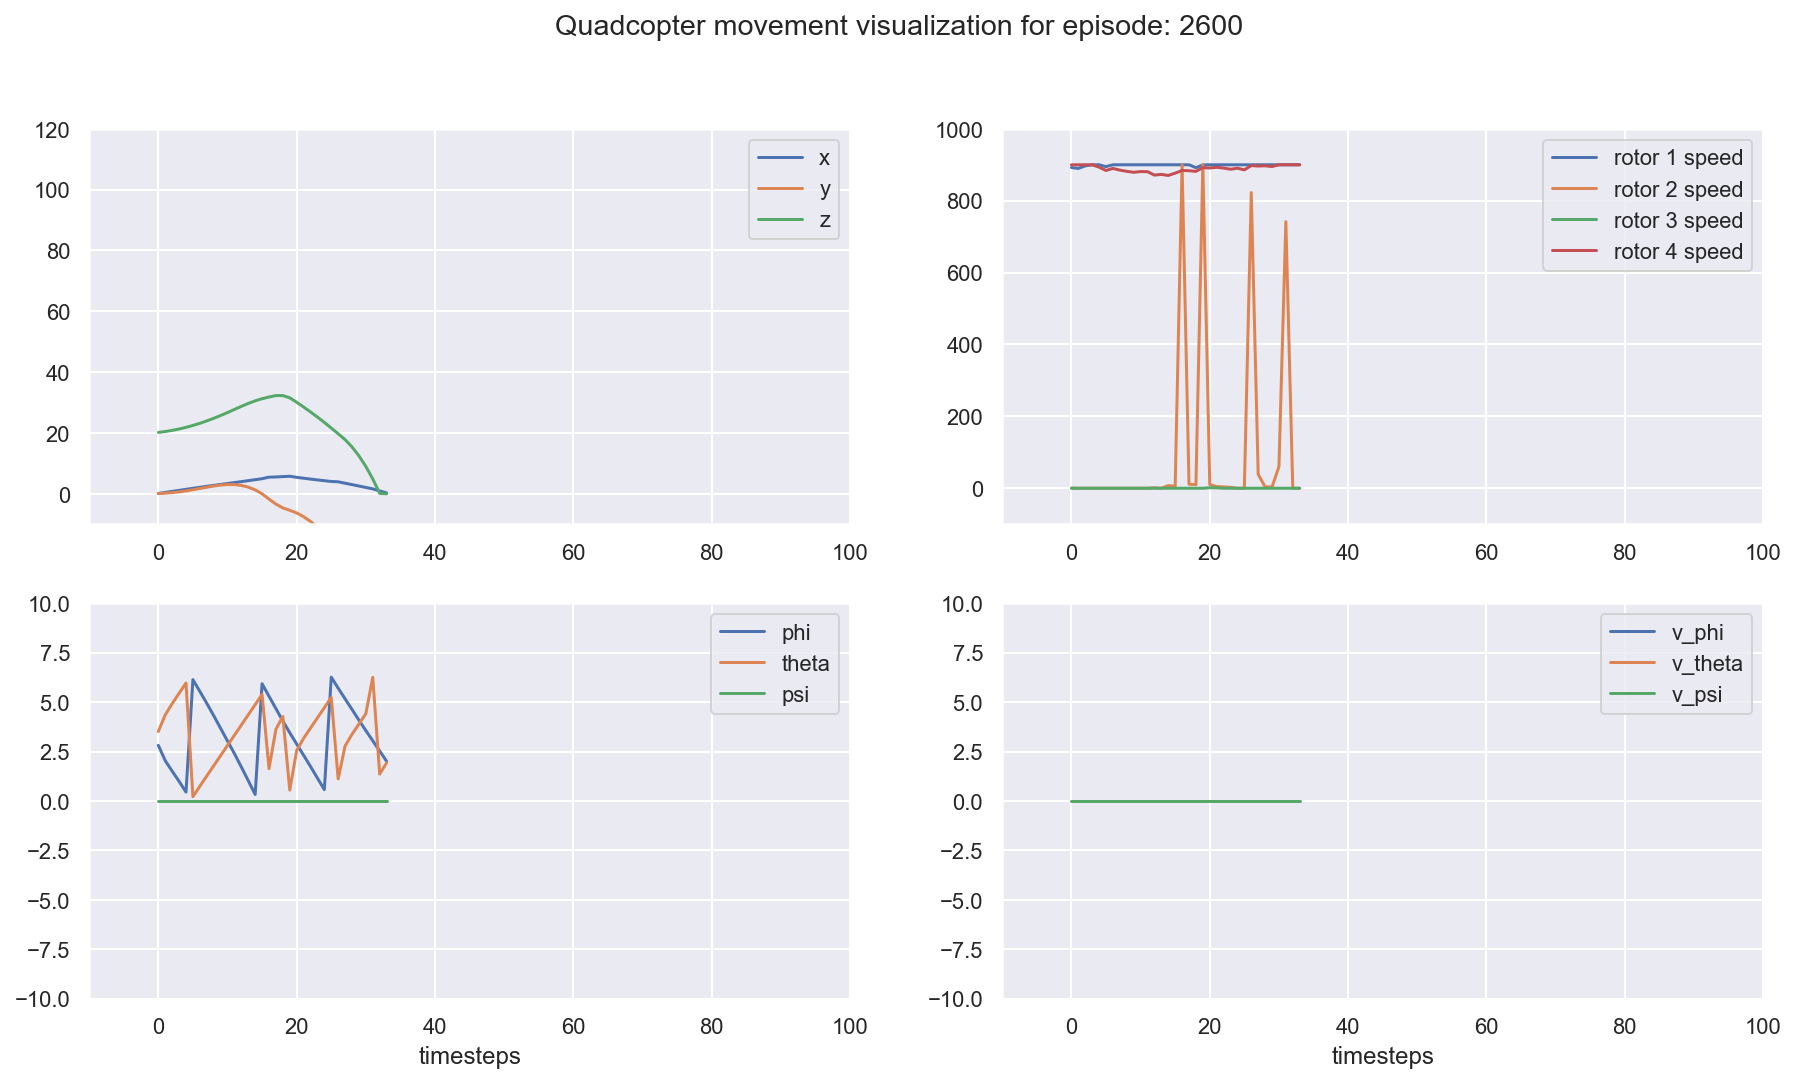

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 2800	 Avg reward: 128.98	 Current reward: 146.12	 Episode length: 51



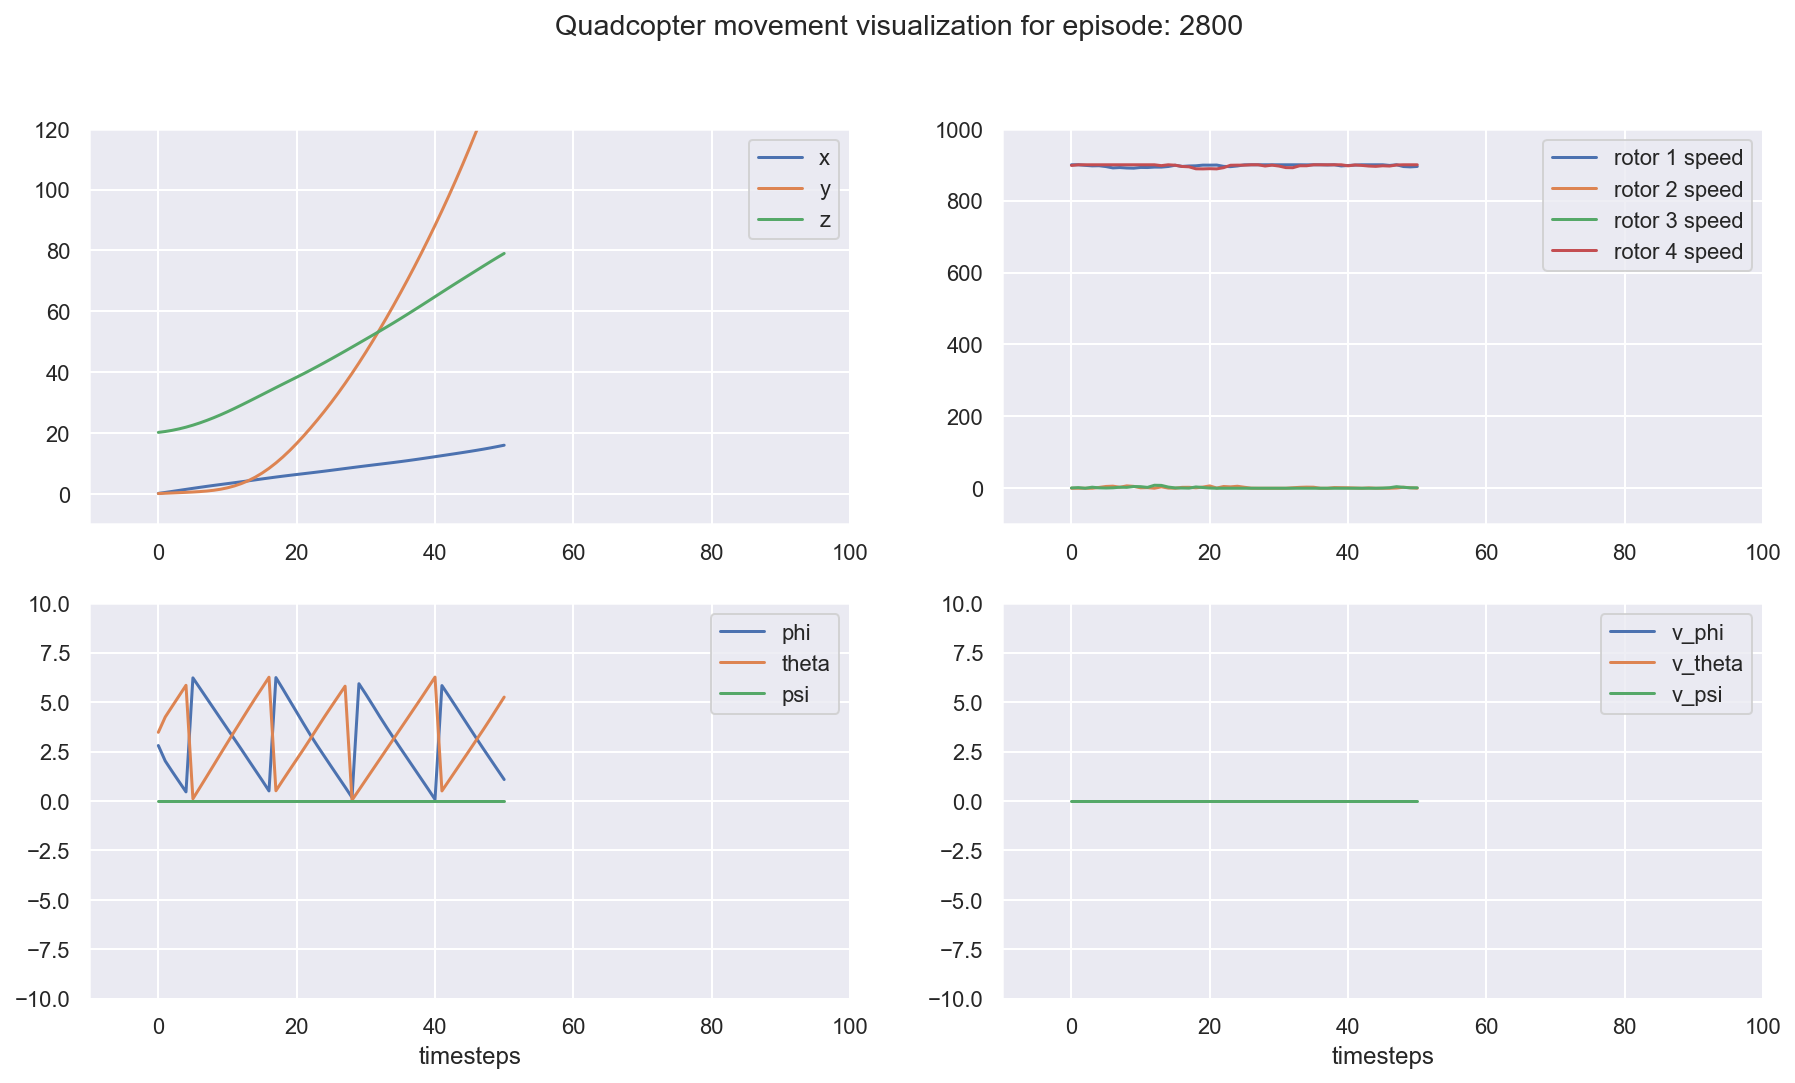

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 3000	 Avg reward: 125.83	 Current reward: 110.89	 Episode length: 51



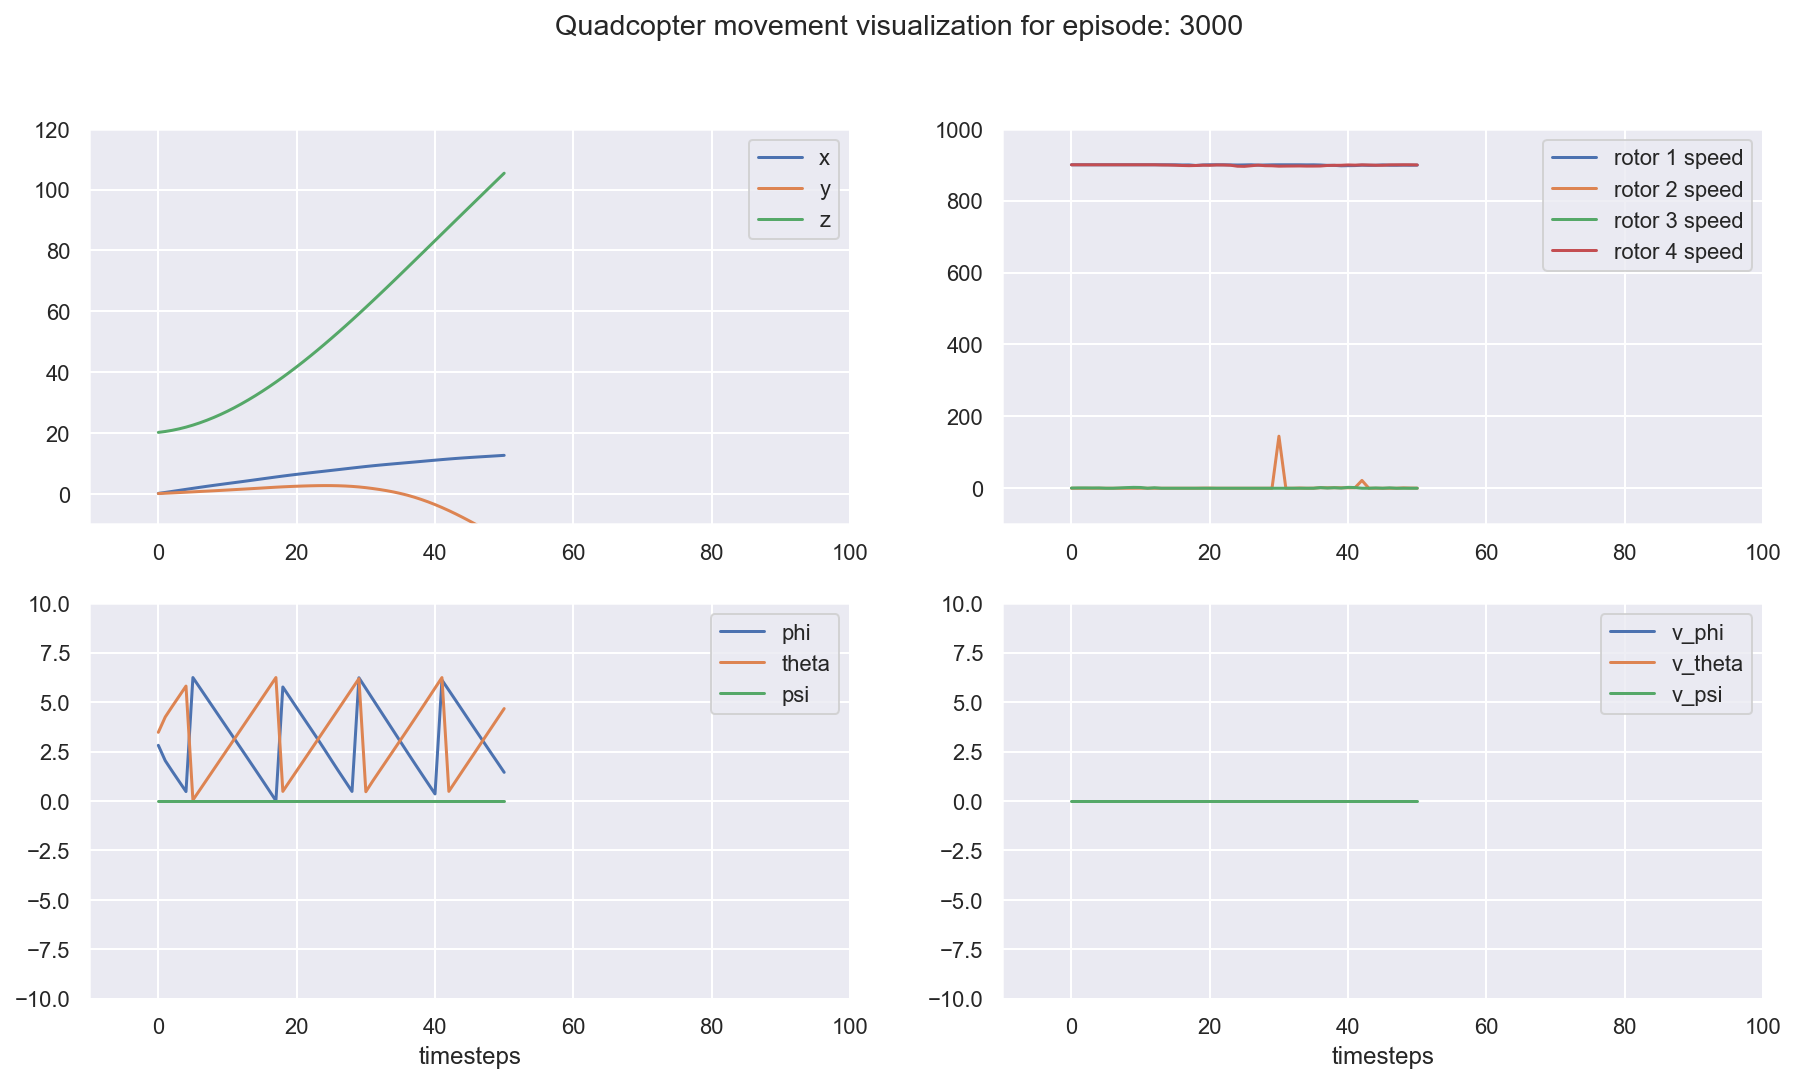

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 3200	 Avg reward: 121.11	 Current reward: 101.99	 Episode length: 51



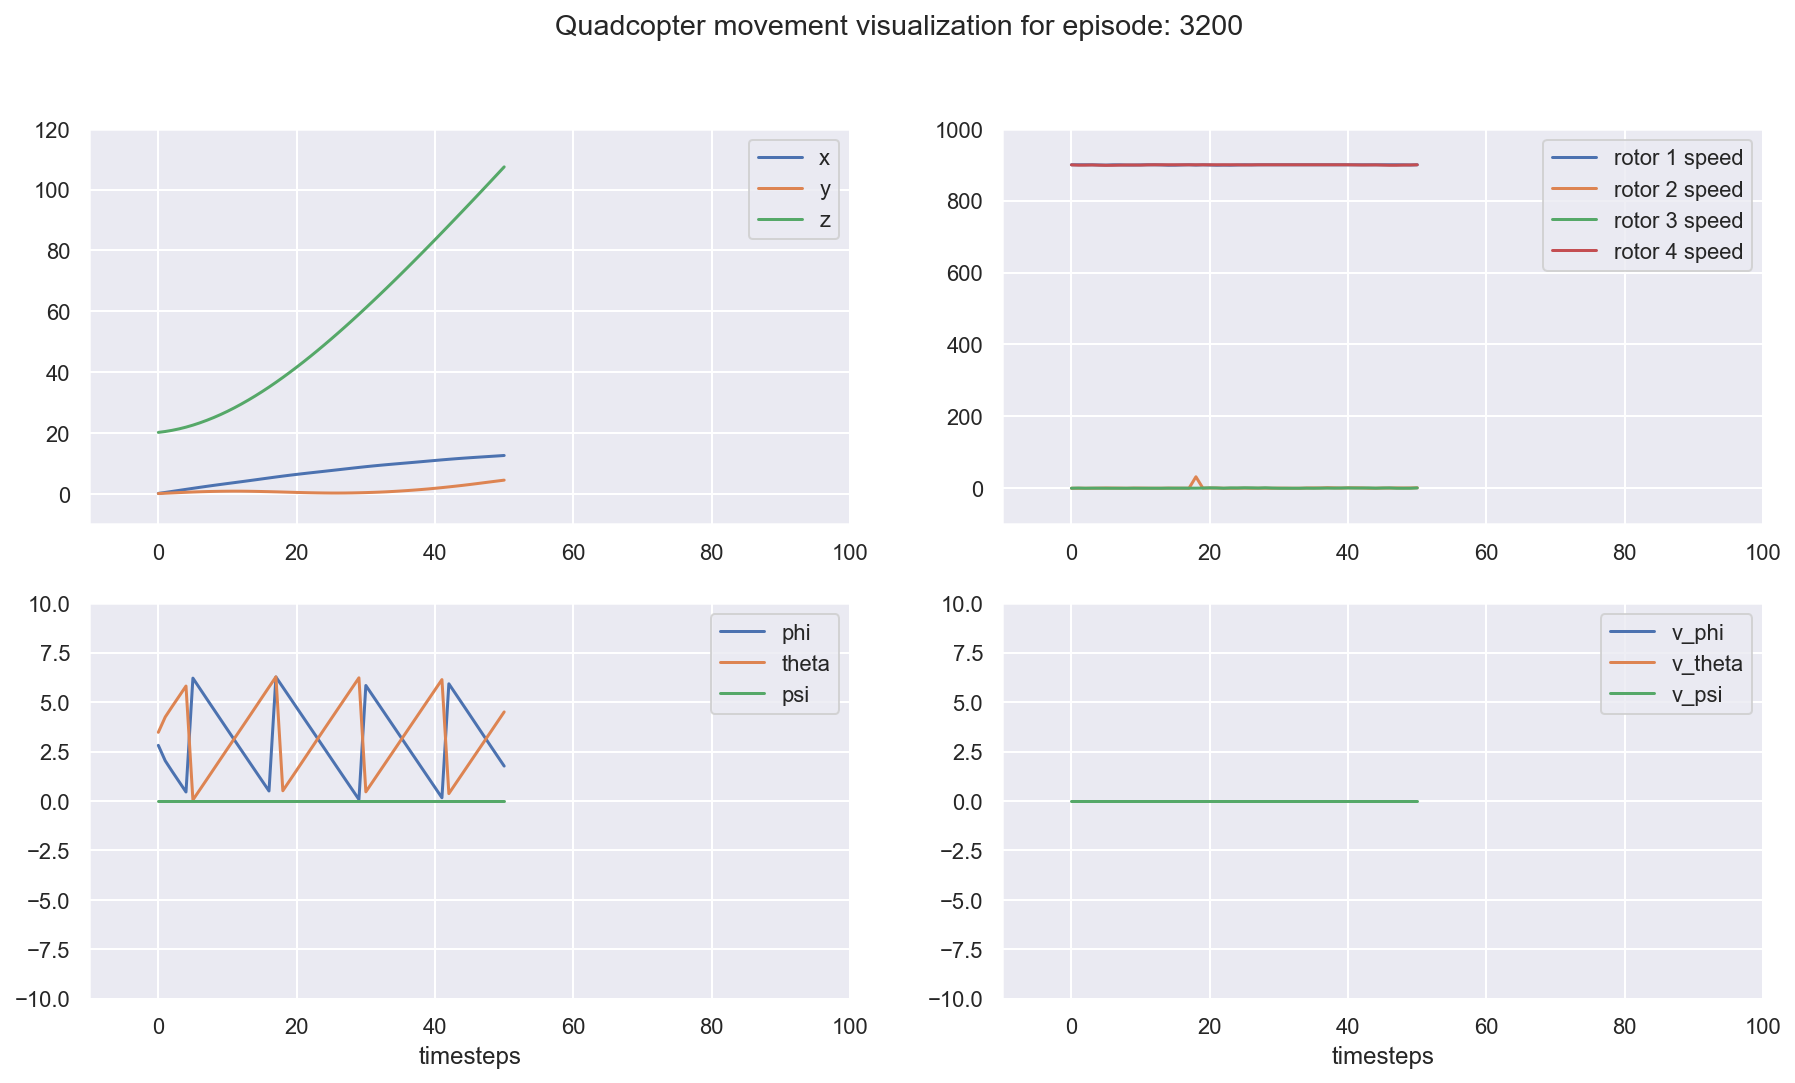

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 3400	 Avg reward: 118.38	 Current reward: 102.49	 Episode length: 51



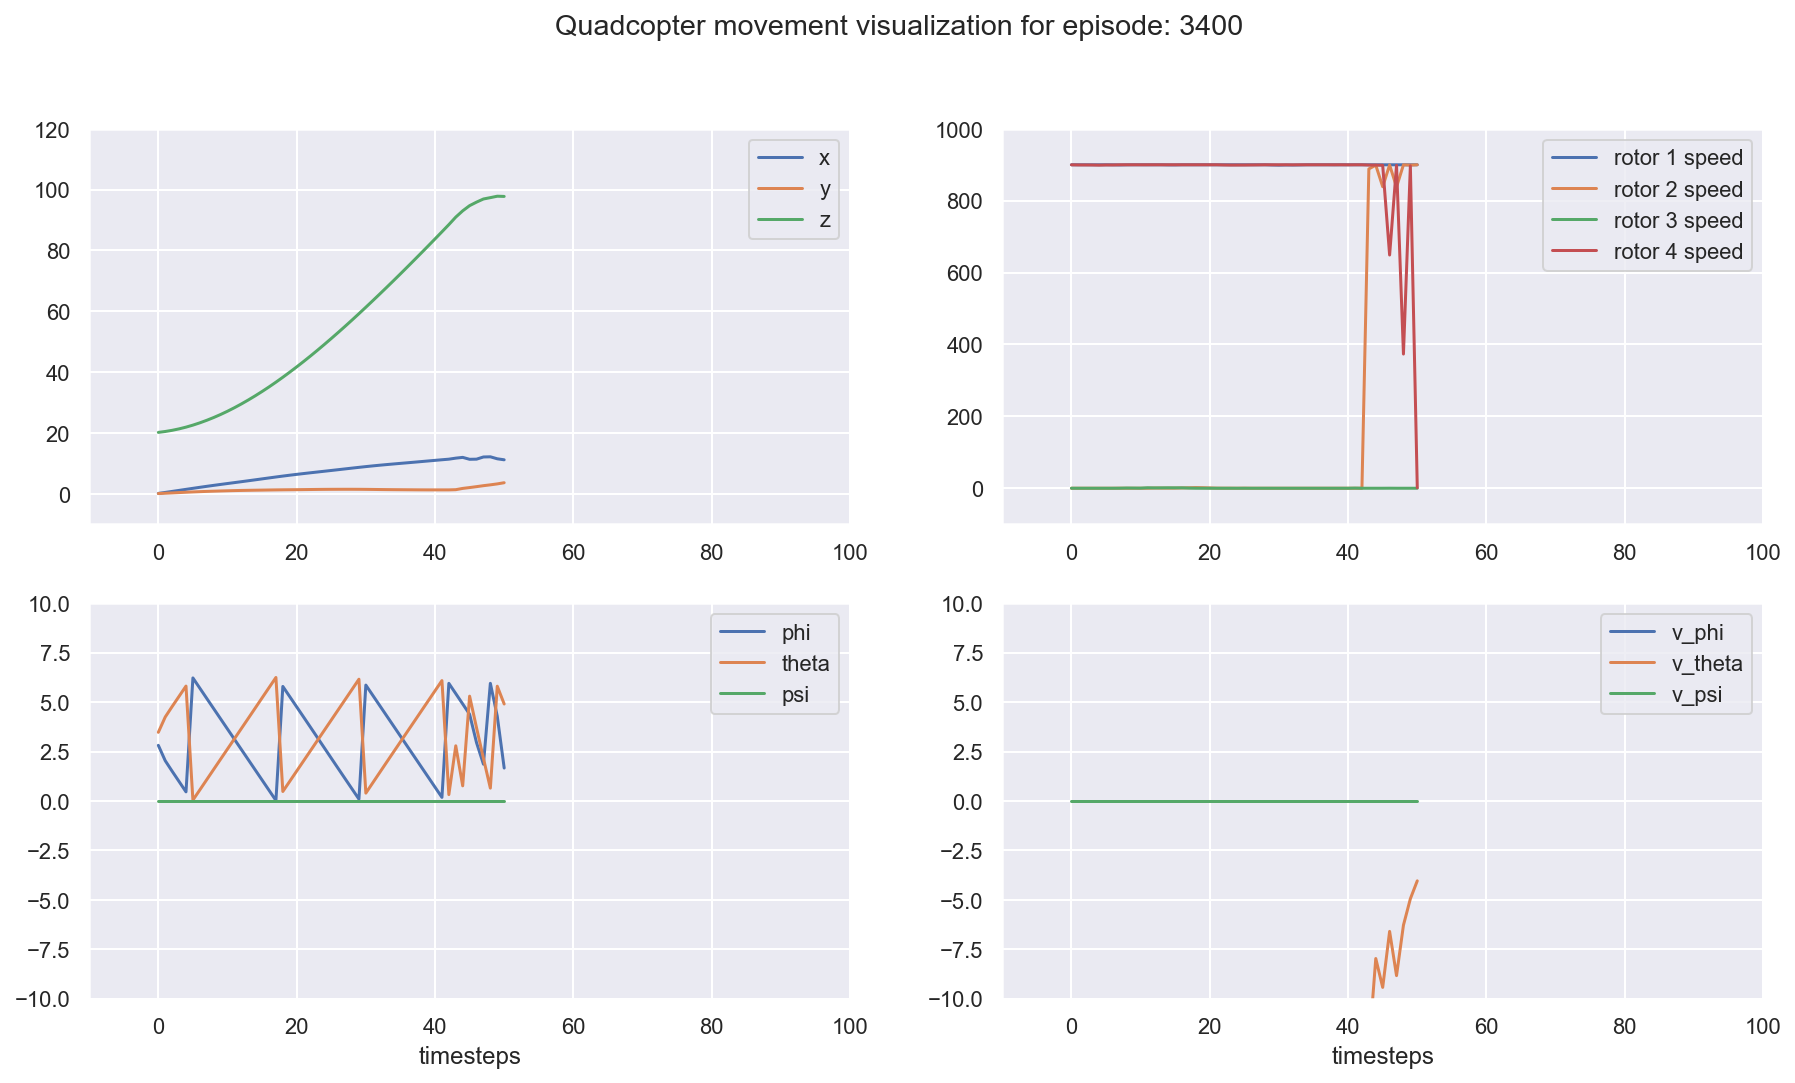

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 3600	 Avg reward: 126.19	 Current reward: 120.39	 Episode length: 51



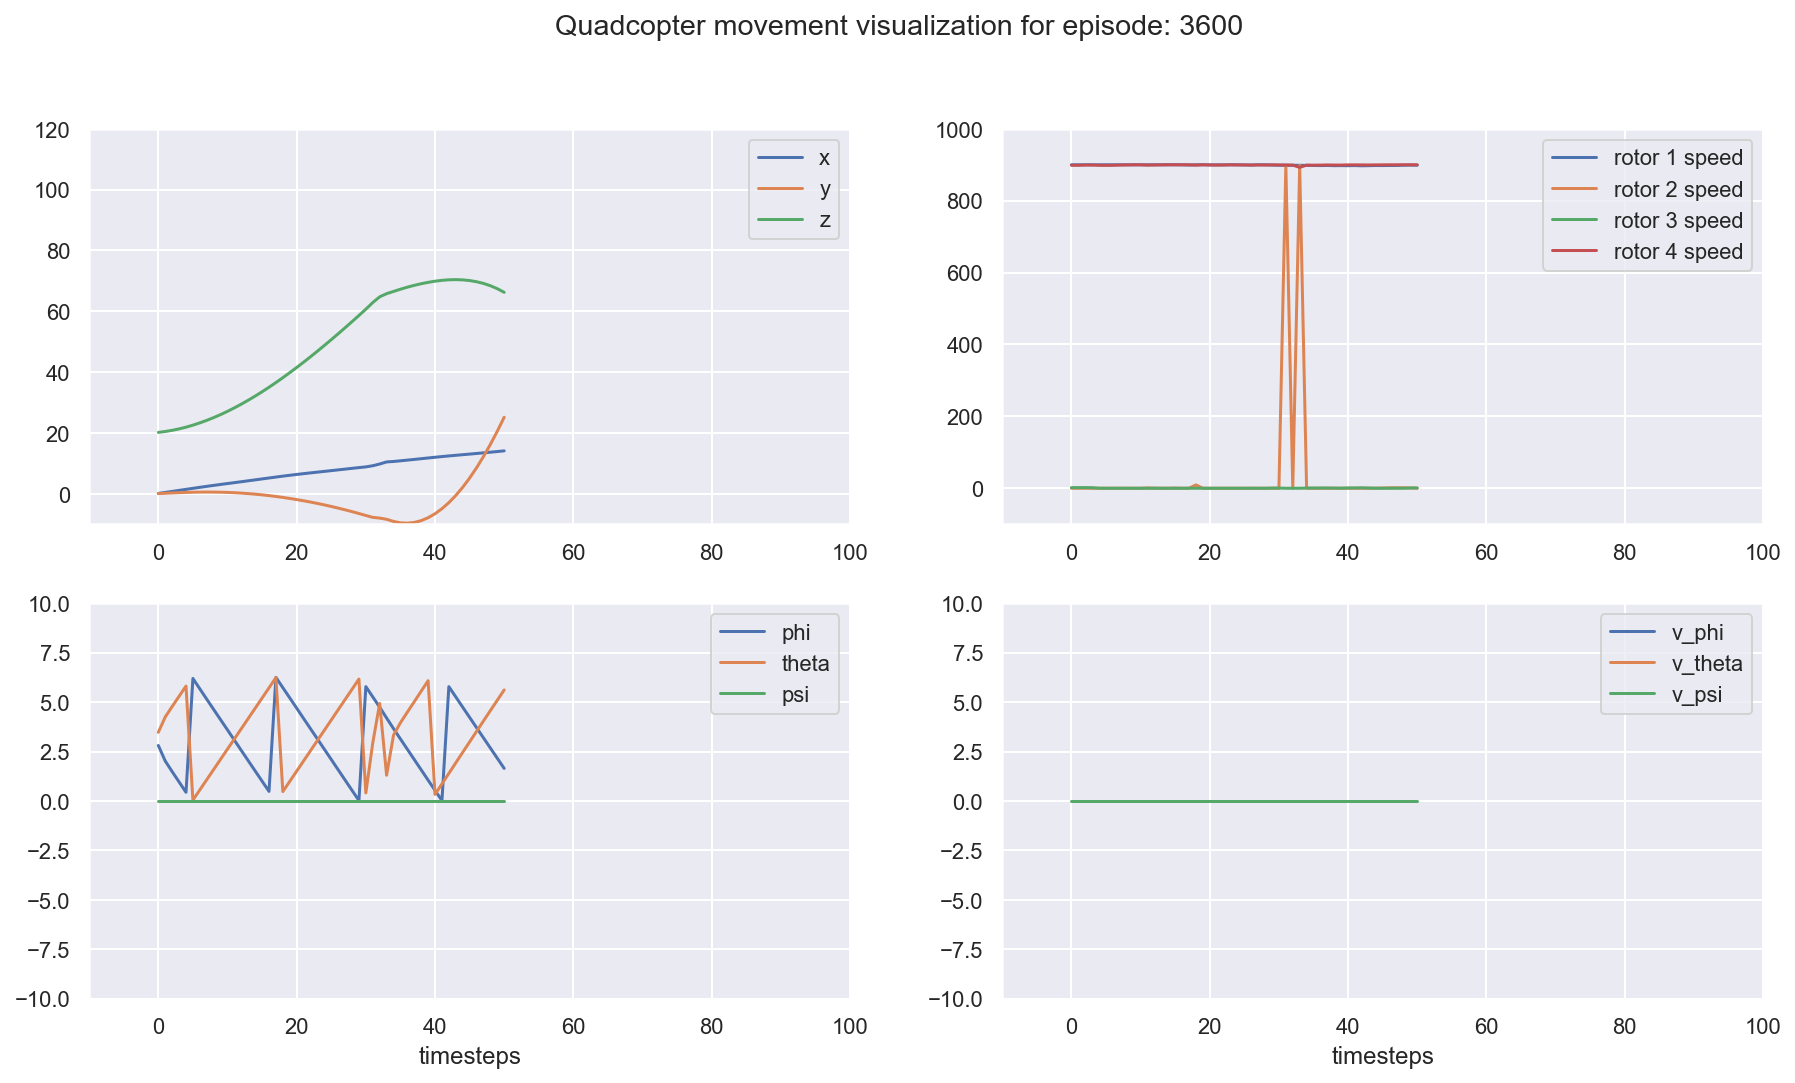

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 3800	 Avg reward: 123.67	 Current reward: 104.68	 Episode length: 40



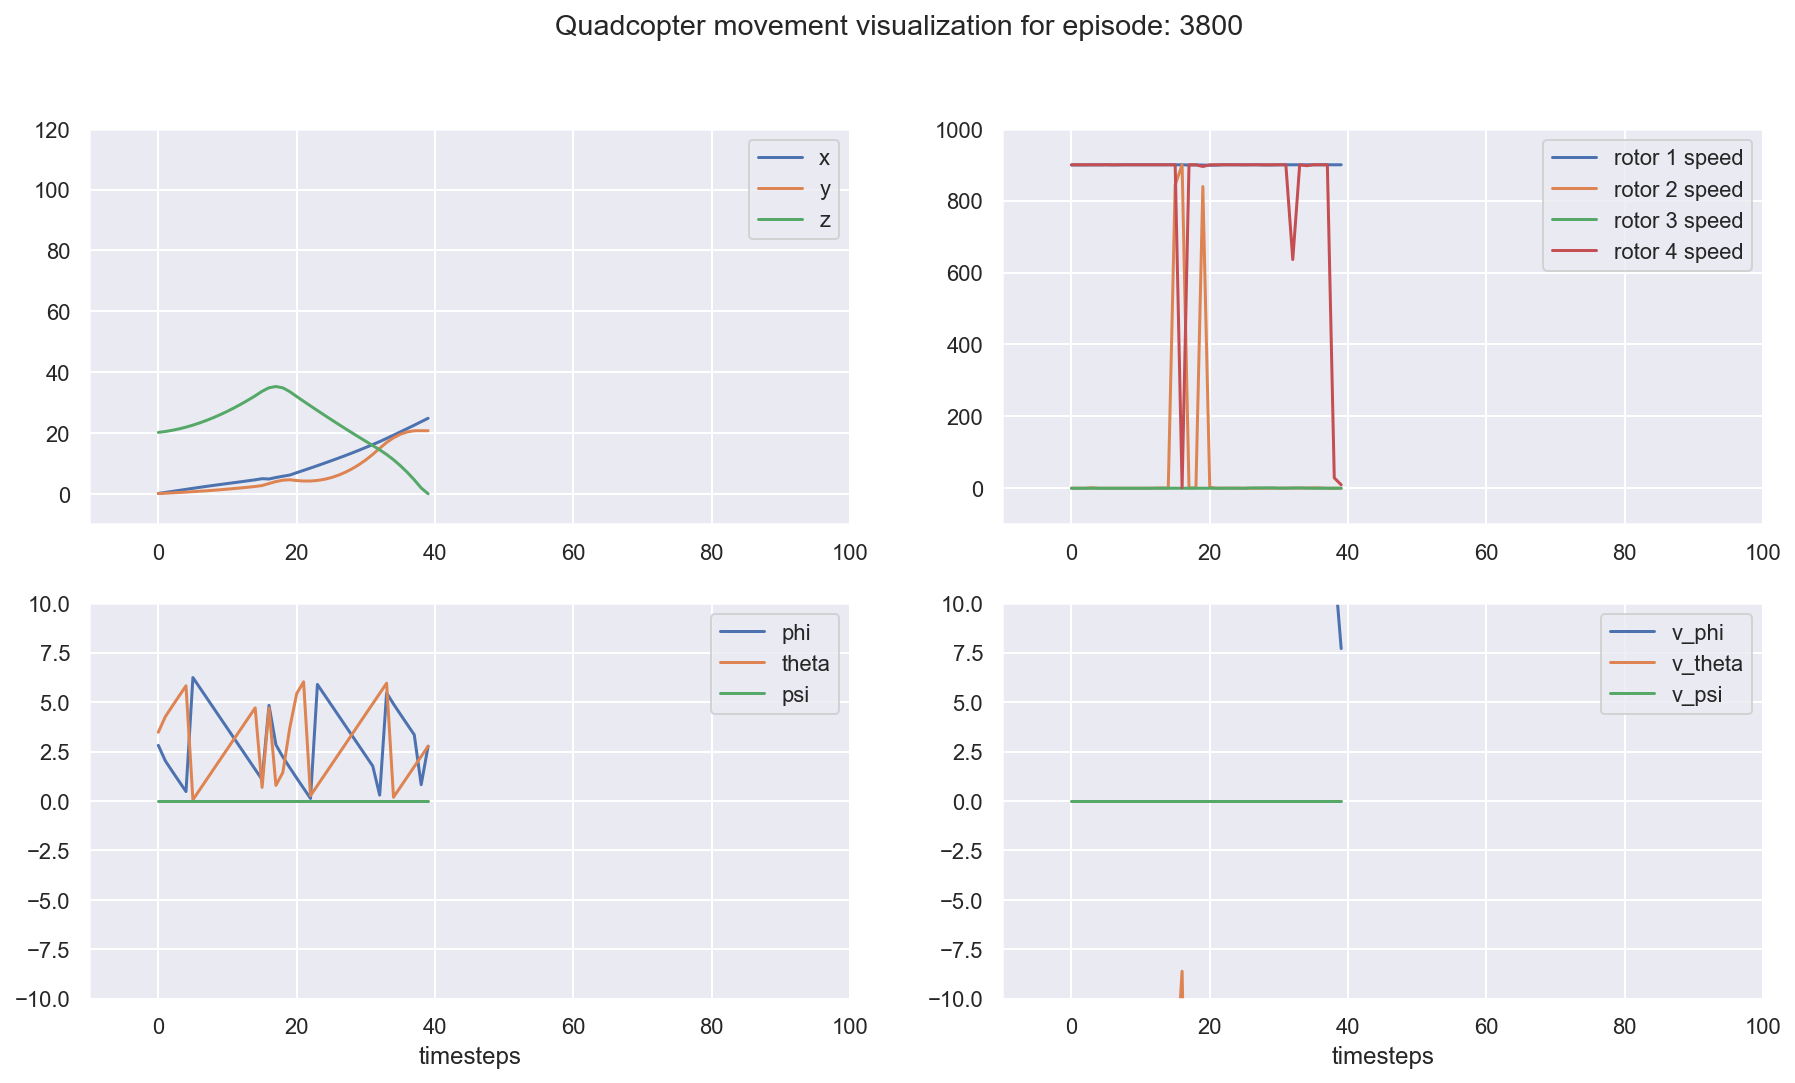

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 4000	 Avg reward: 116.73	 Current reward: 127.32	 Episode length: 45



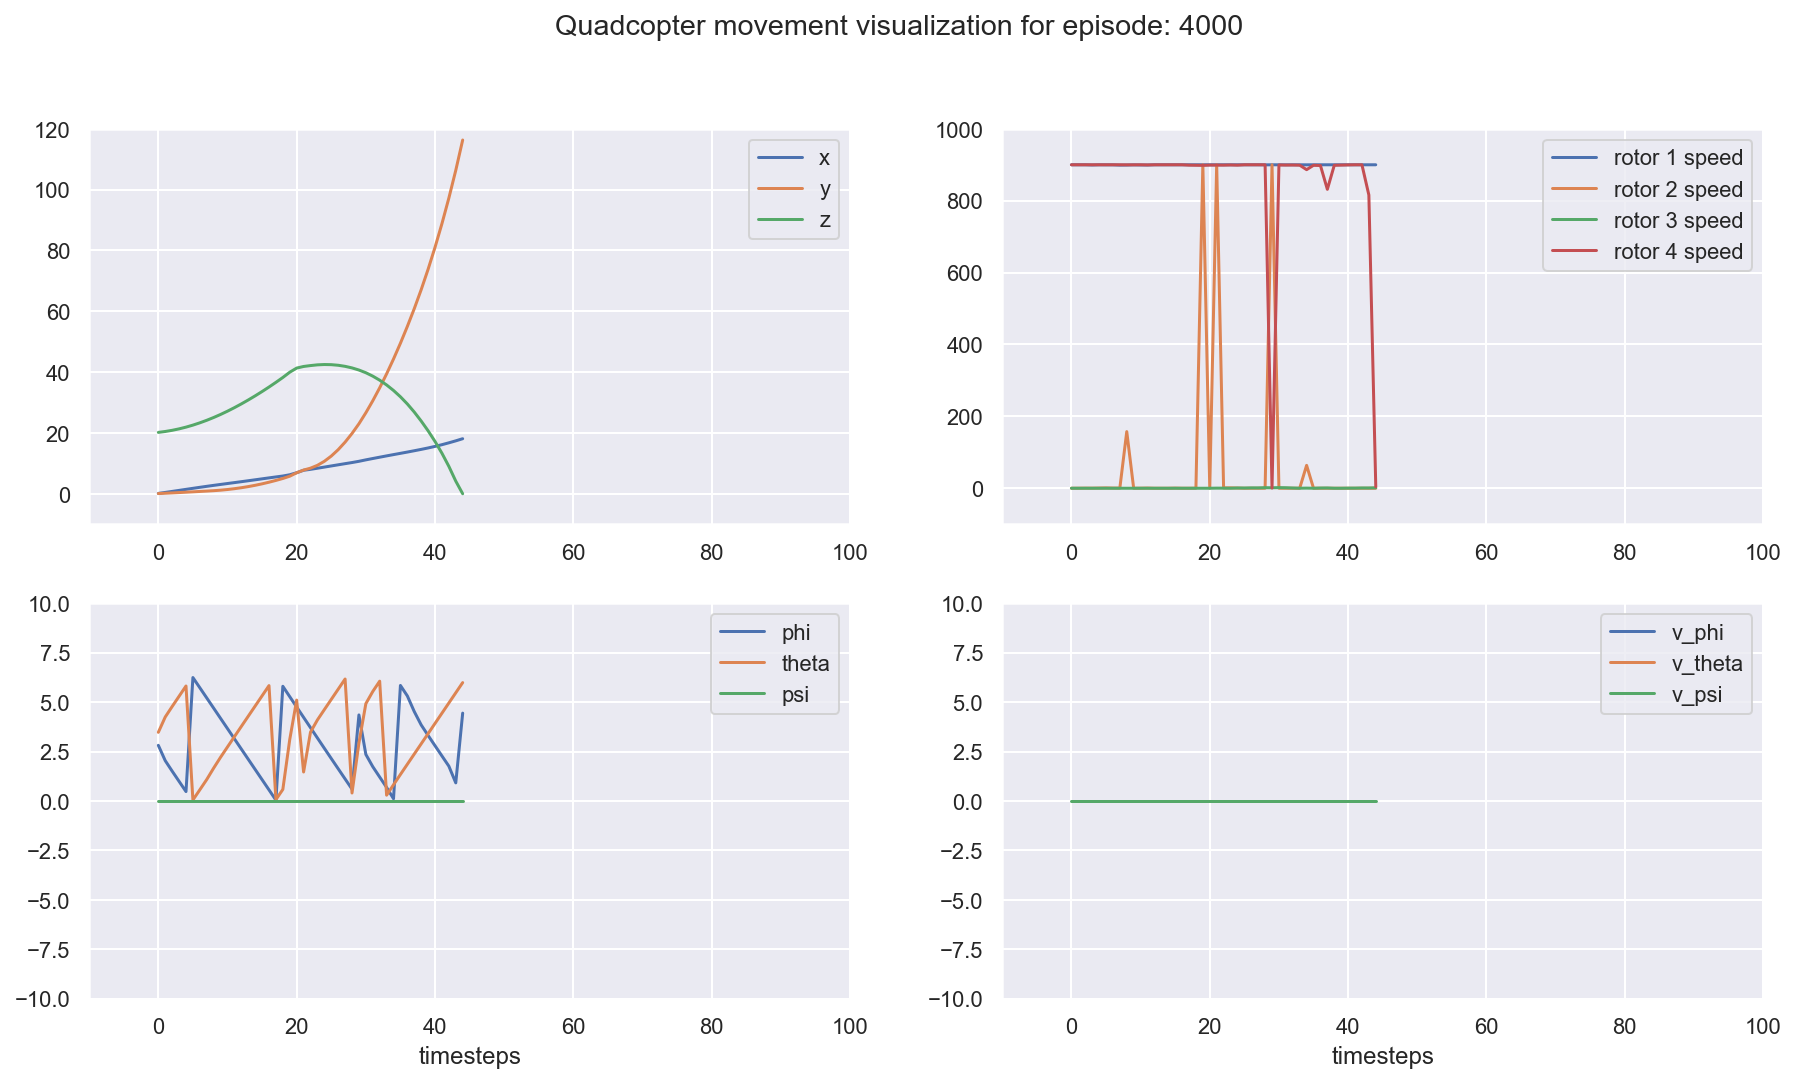

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 4200	 Avg reward: 75.31	 Current reward: 65.73	 Episode length: 26



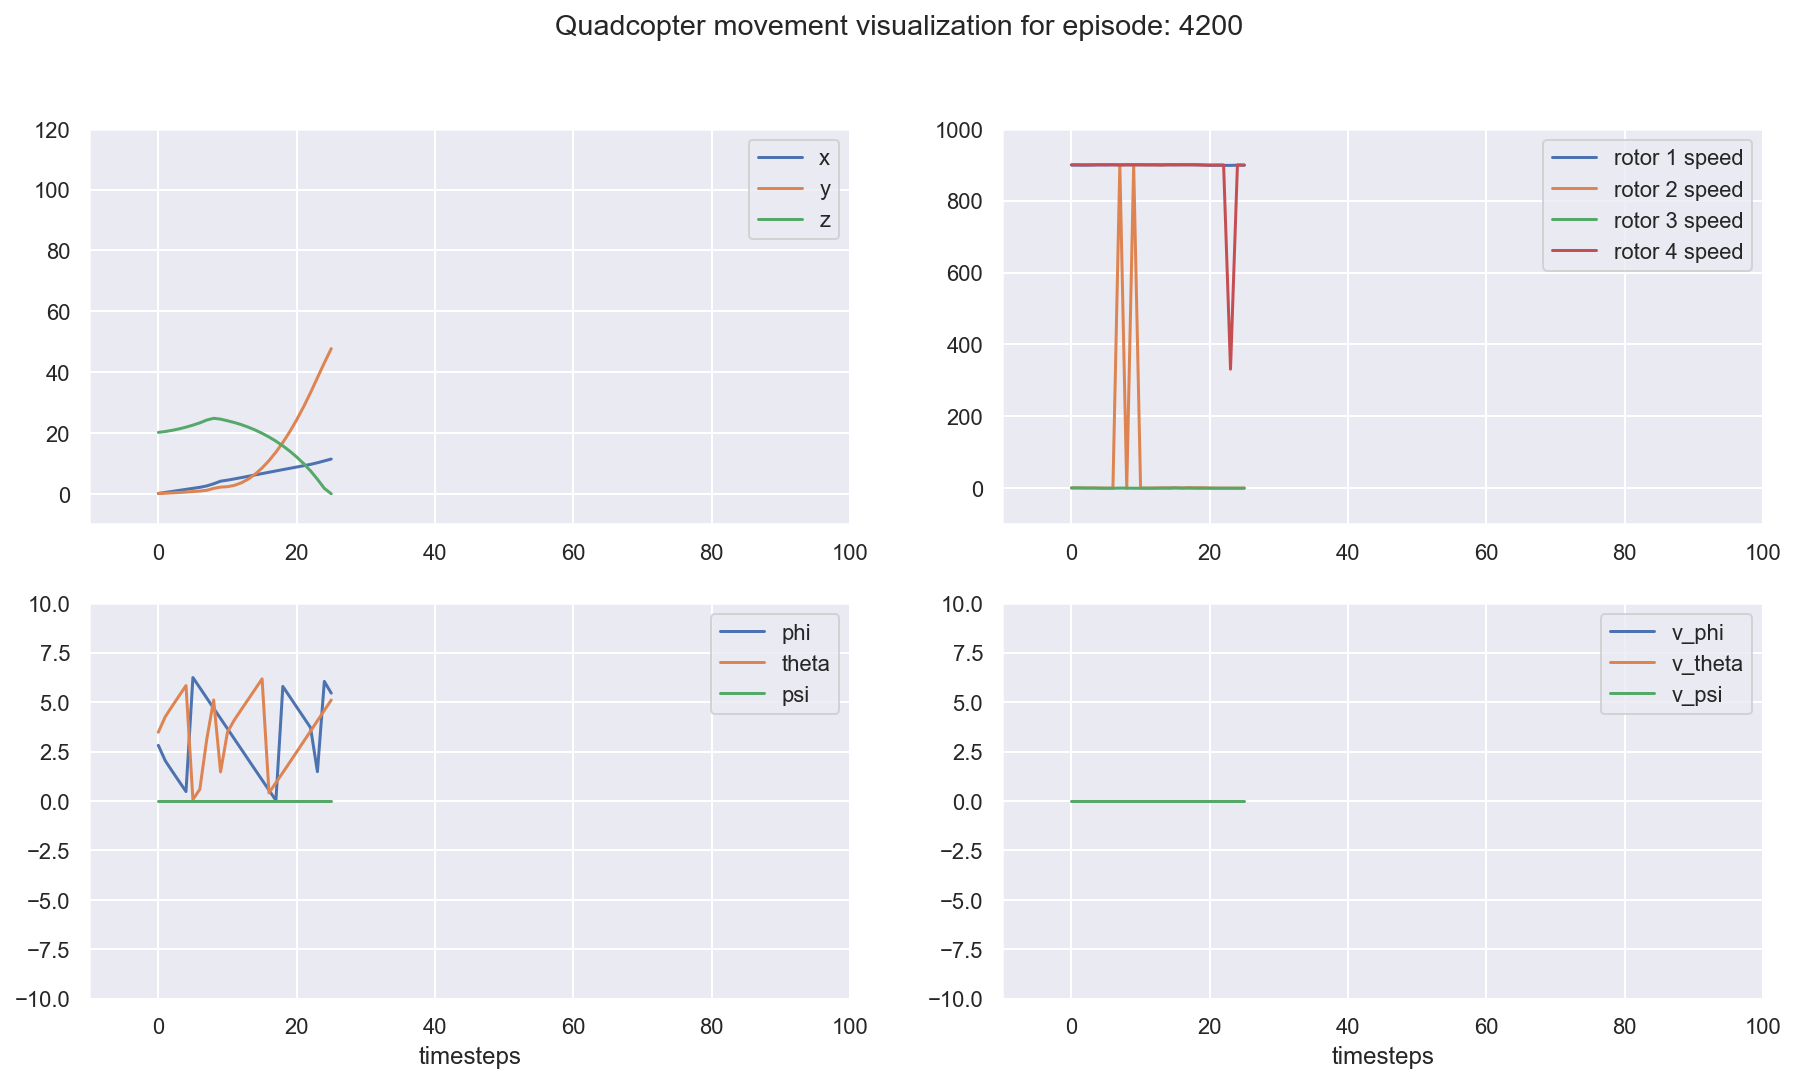

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 4400	 Avg reward: 66.80	 Current reward: 65.17	 Episode length: 26



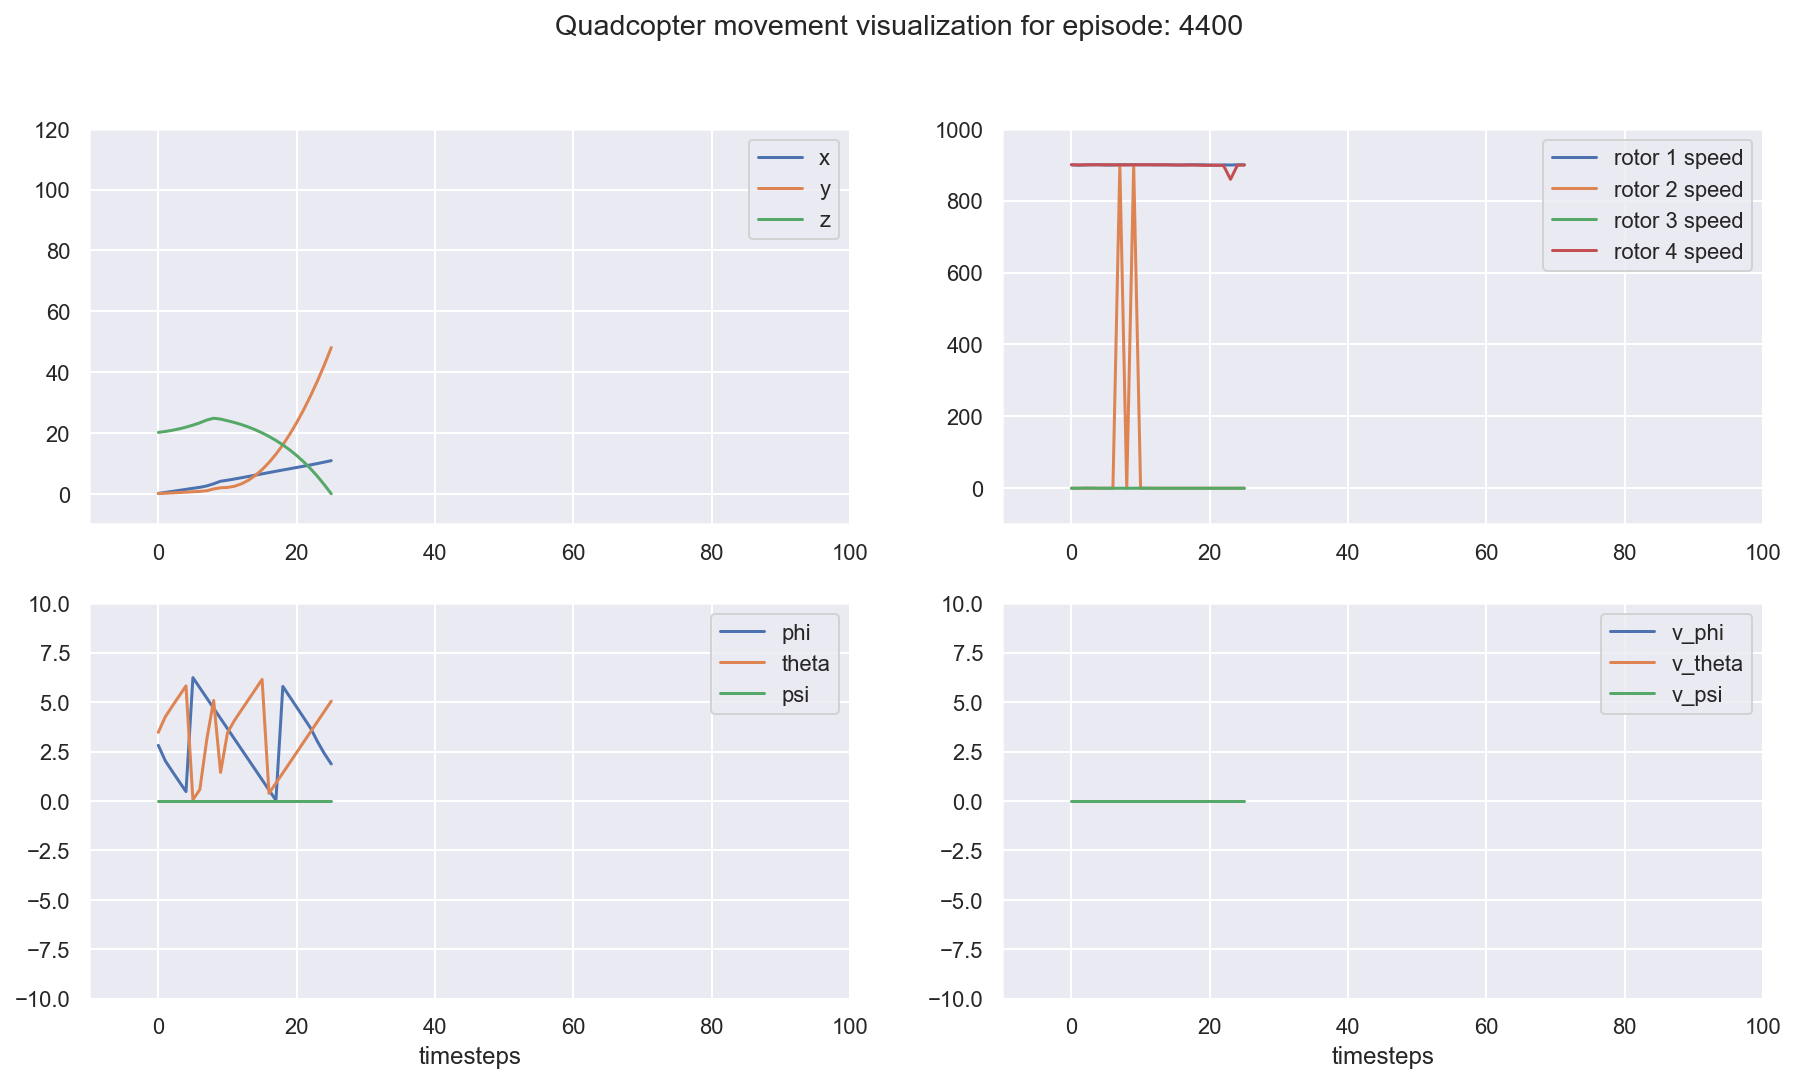

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 4600	 Avg reward: 66.61	 Current reward: 62.28	 Episode length: 25



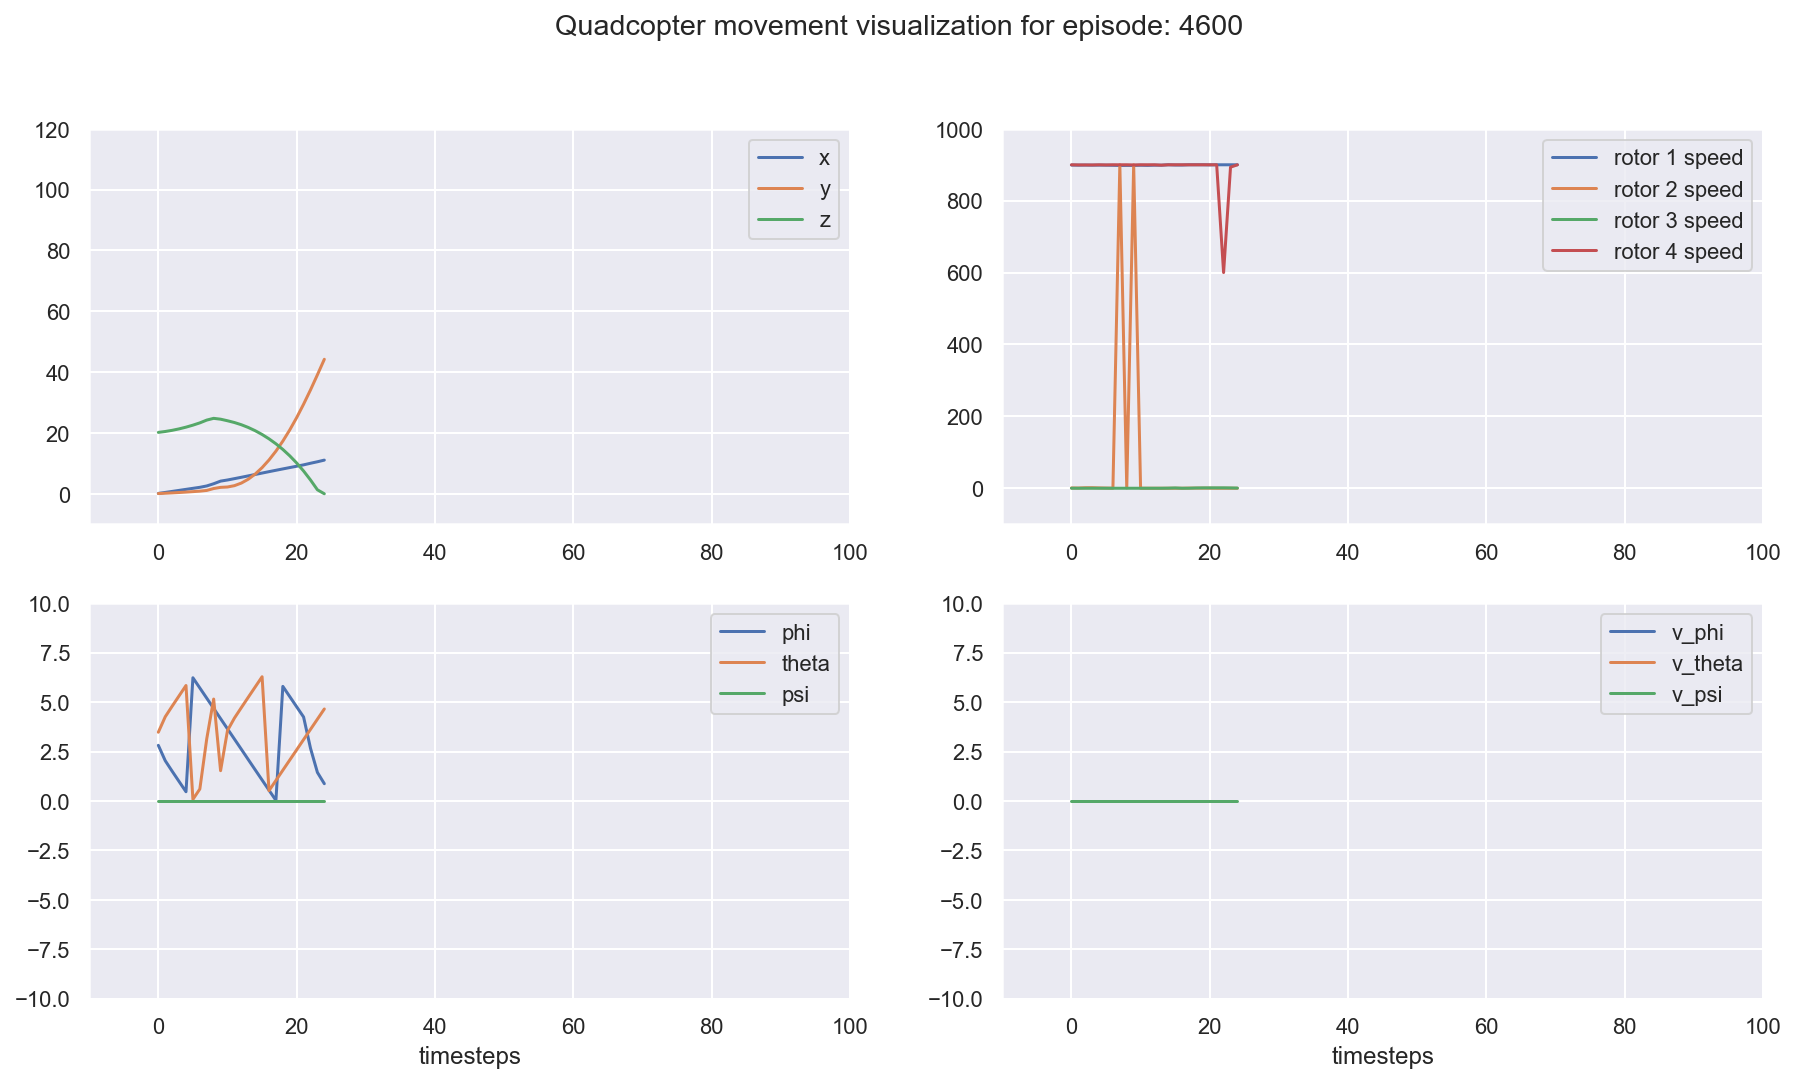

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 4800	 Avg reward: 66.45	 Current reward: 64.98	 Episode length: 26



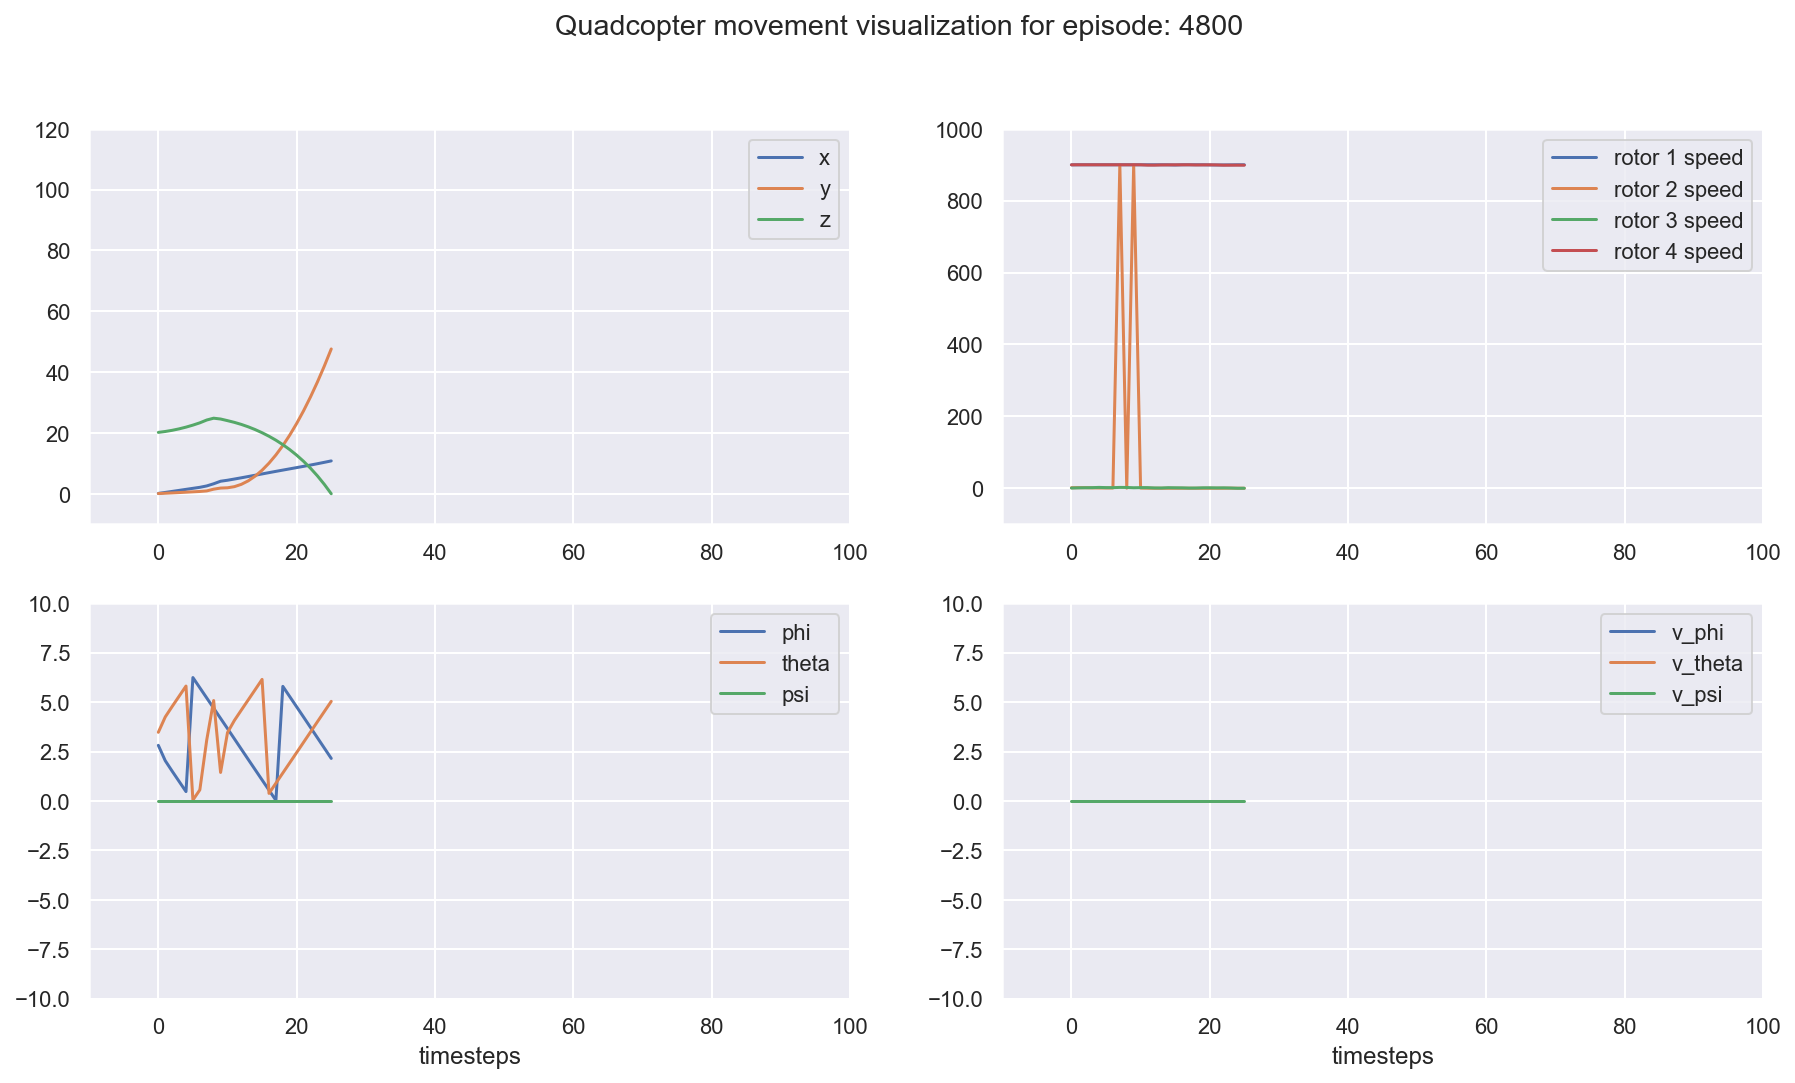

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 5000	 Avg reward: 66.31	 Current reward: 65.41	 Episode length: 26



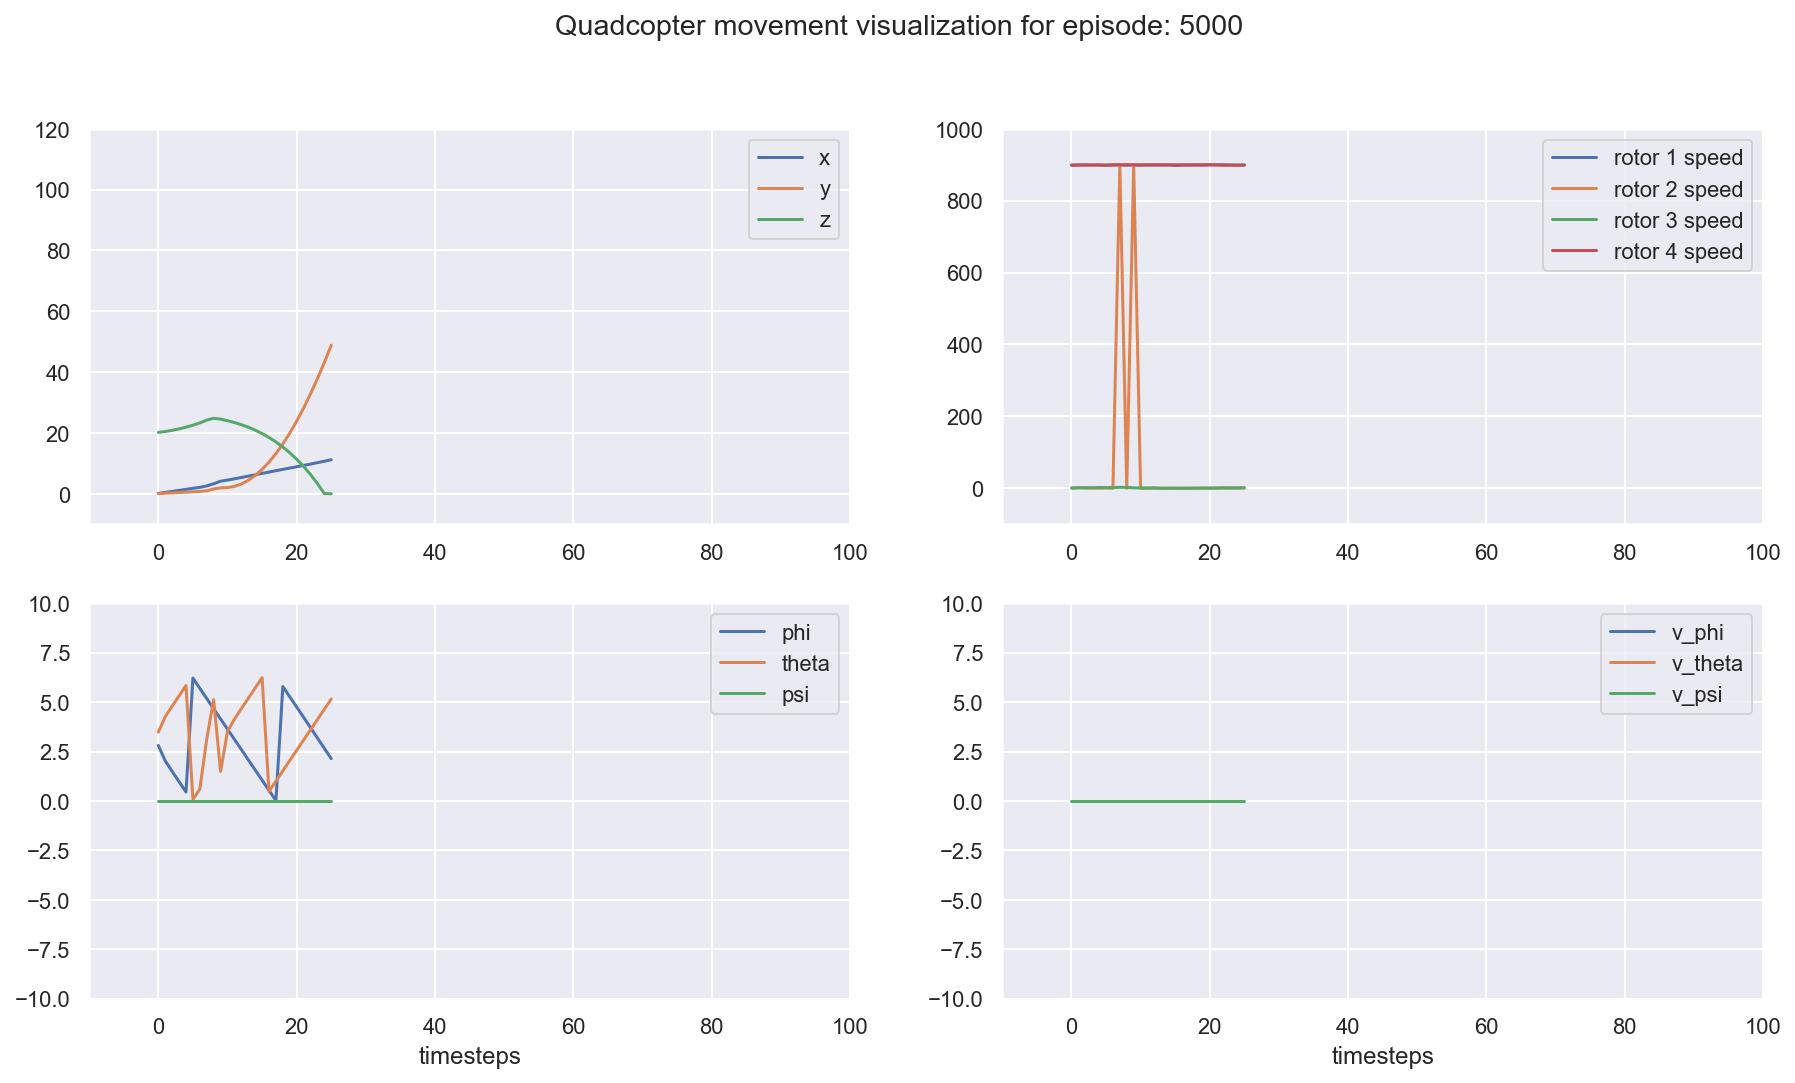

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 5200	 Avg reward: 67.22	 Current reward: 65.77	 Episode length: 26



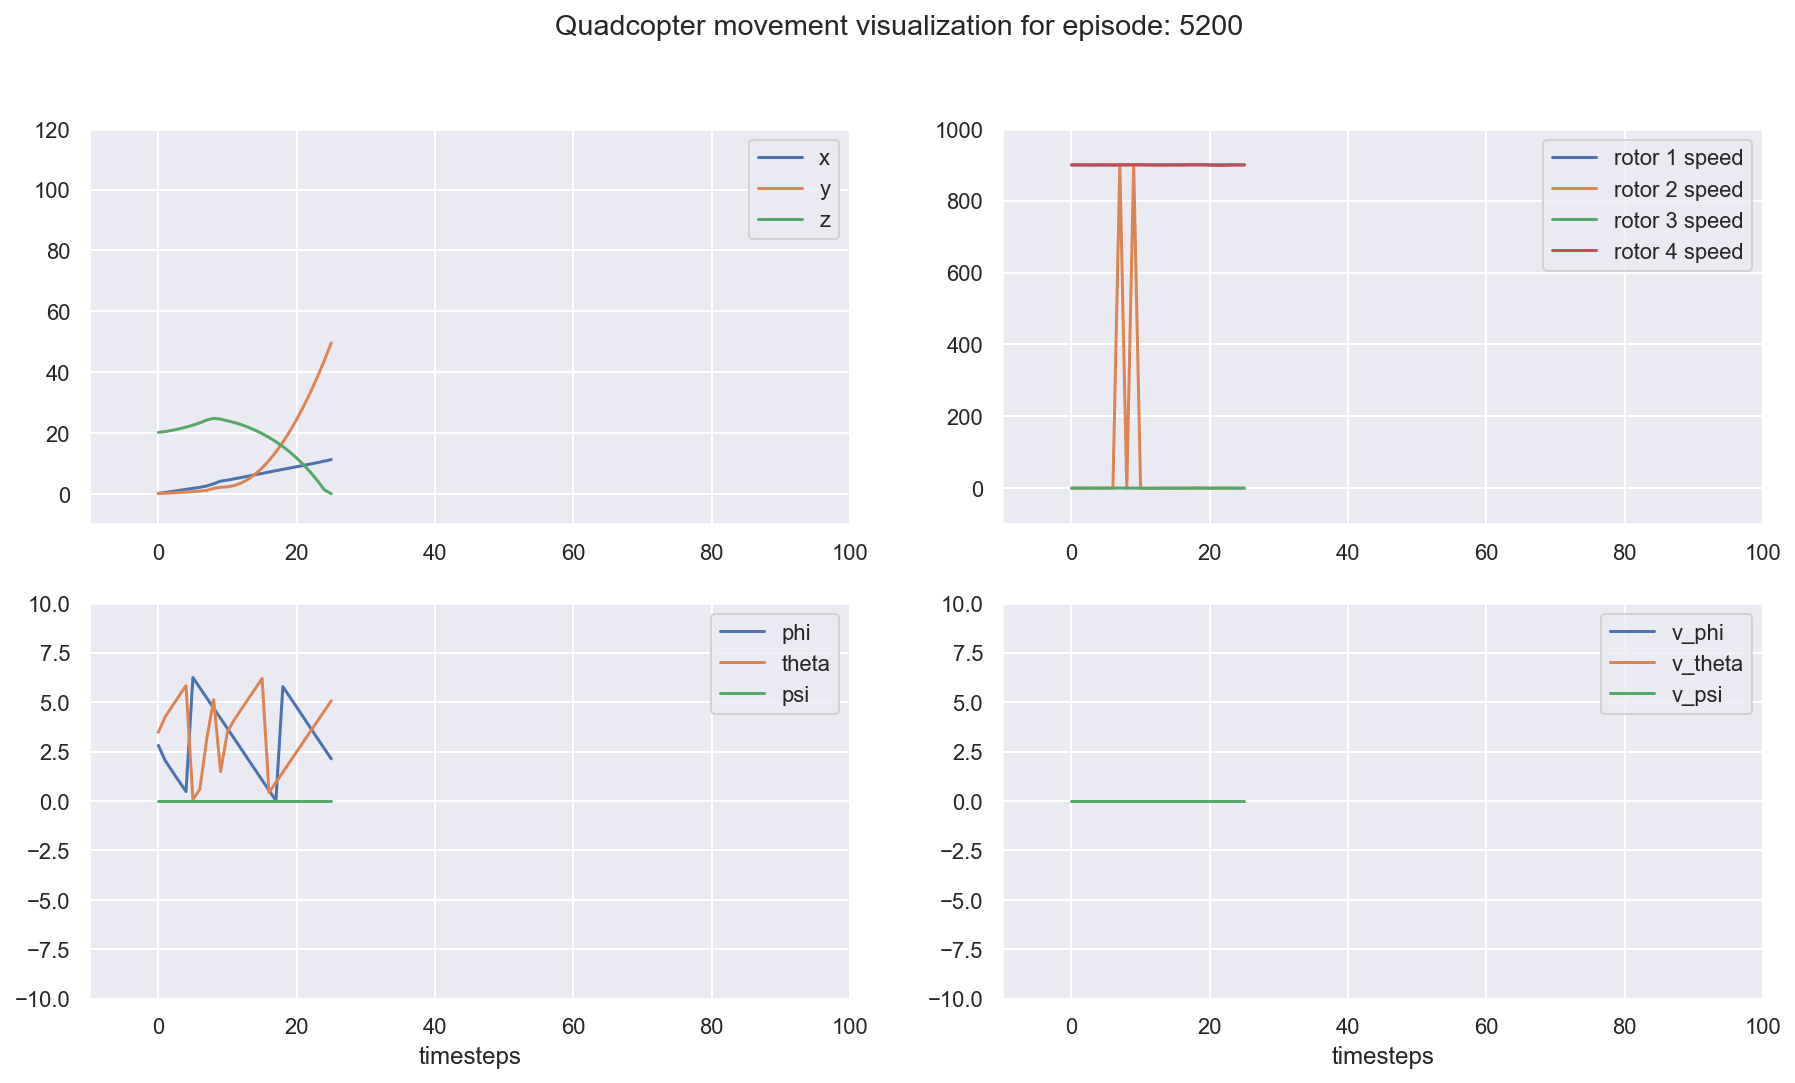

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 5400	 Avg reward: 65.71	 Current reward: 68.19	 Episode length: 27



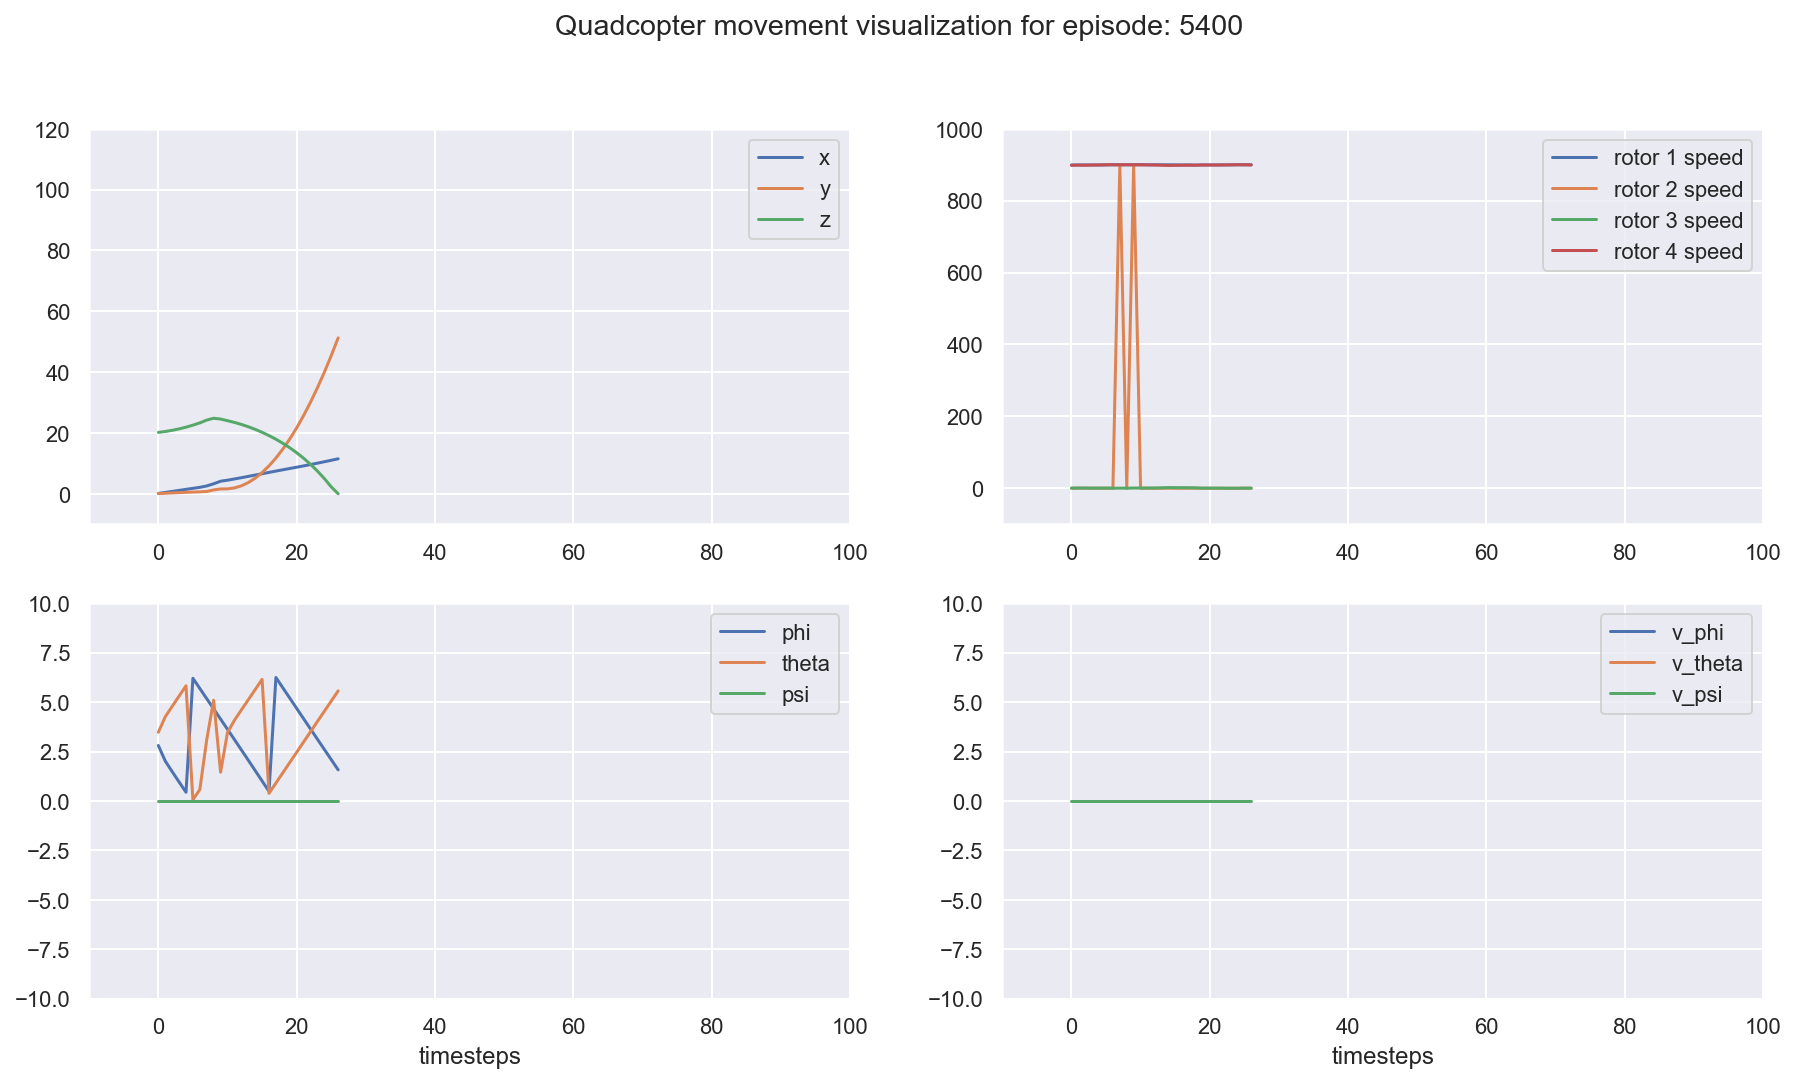

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 5600	 Avg reward: 69.61	 Current reward: 65.48	 Episode length: 26



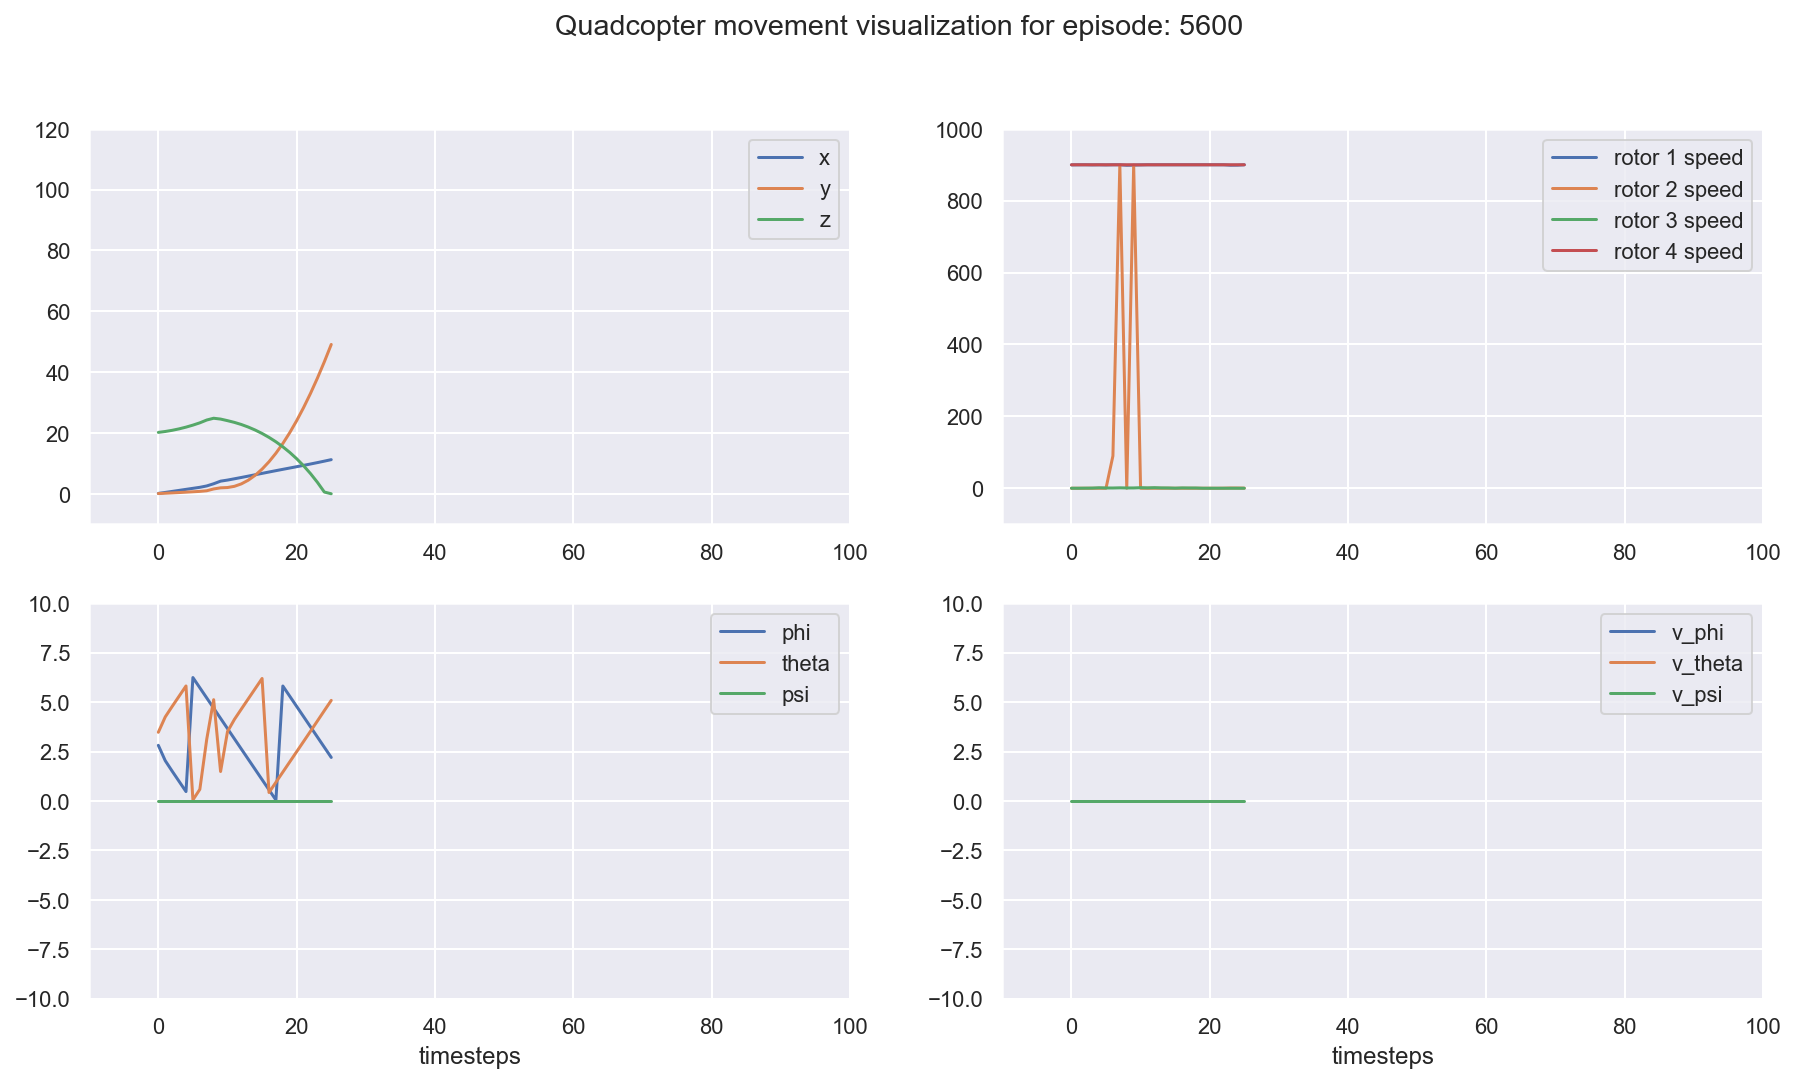

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 5800	 Avg reward: 68.64	 Current reward: 68.29	 Episode length: 27



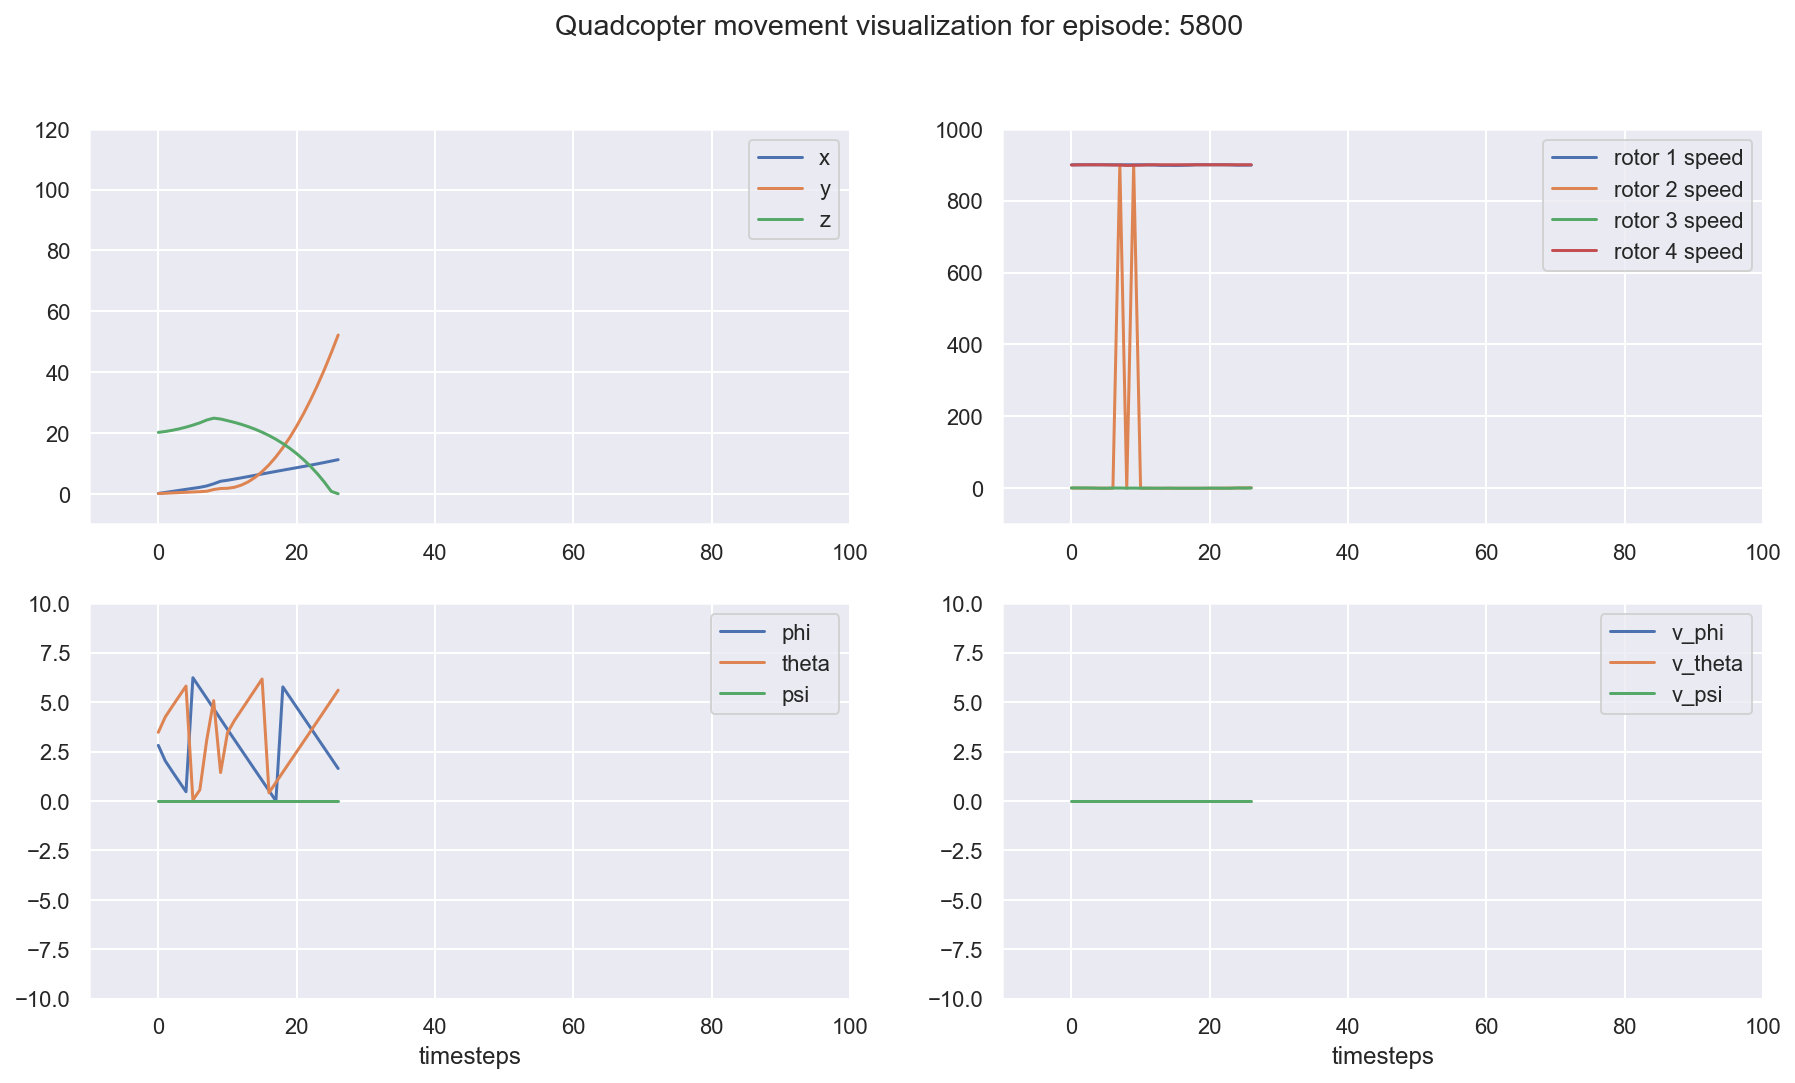

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 6000	 Avg reward: 66.03	 Current reward: 55.08	 Episode length: 24



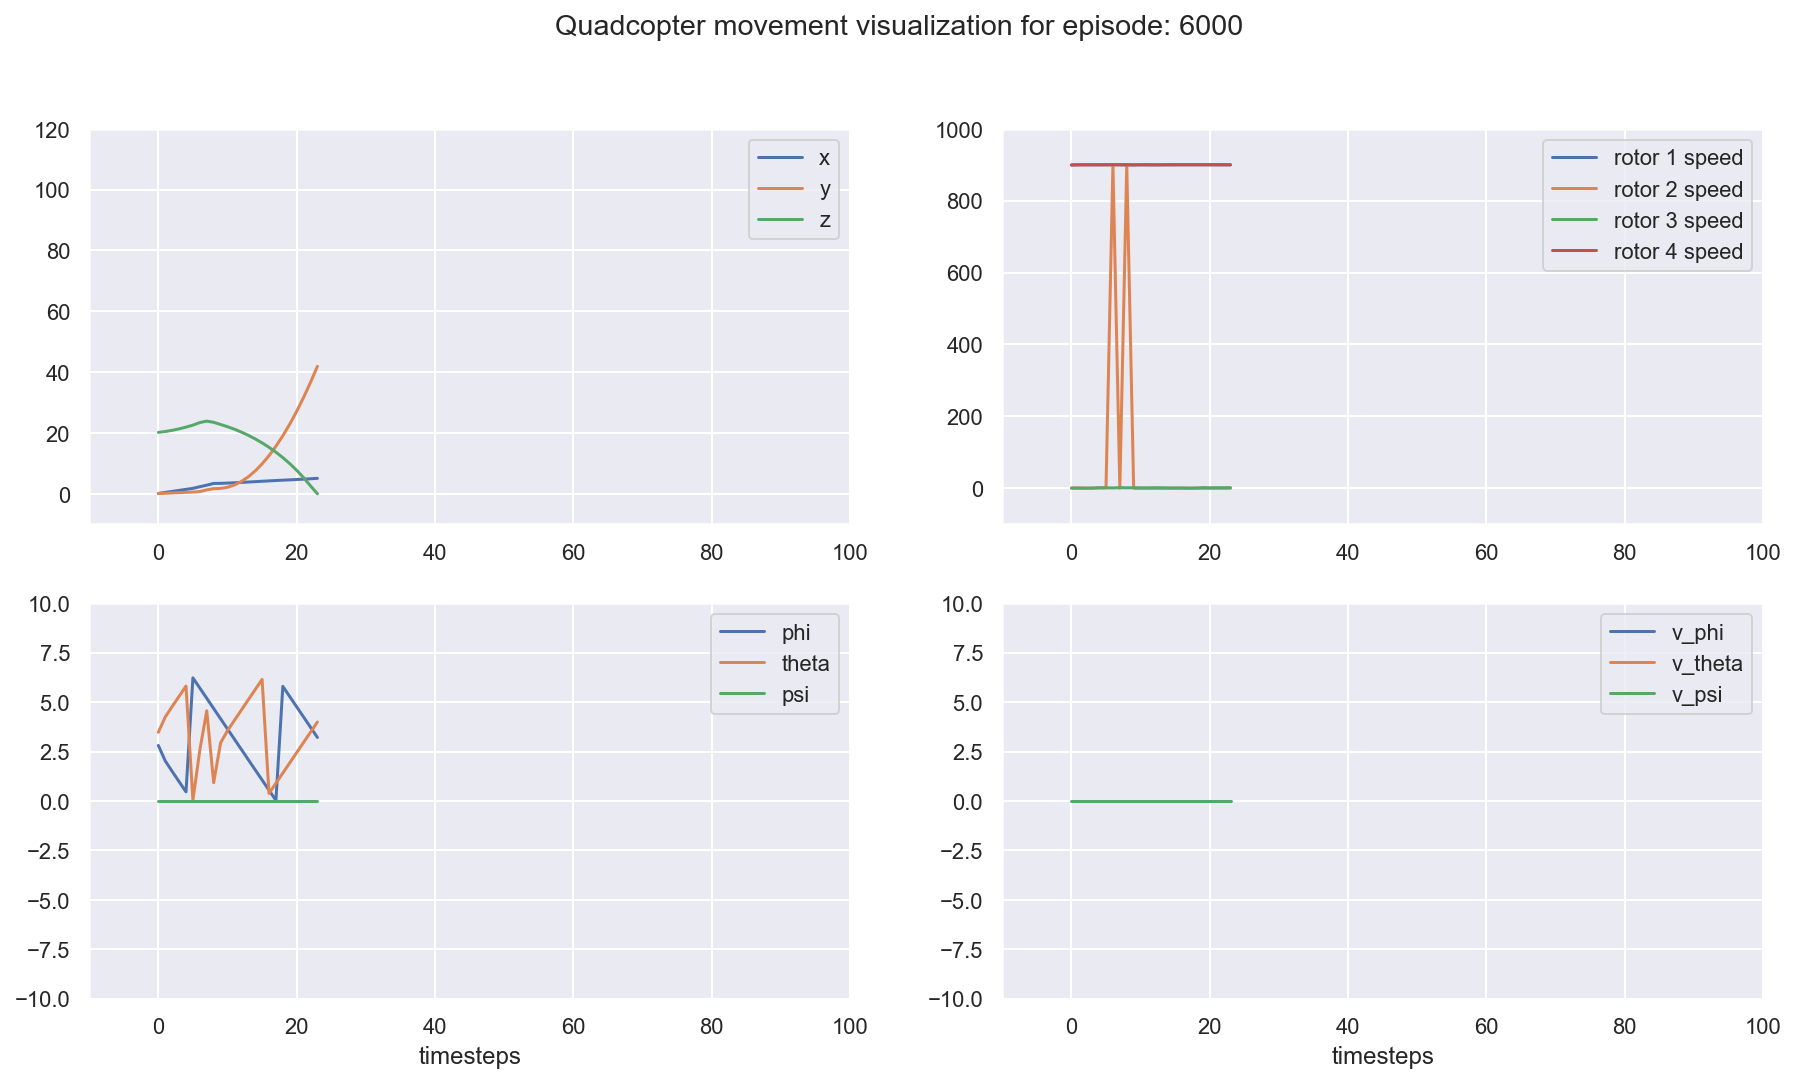

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 6200	 Avg reward: 75.41	 Current reward: 71.28	 Episode length: 28



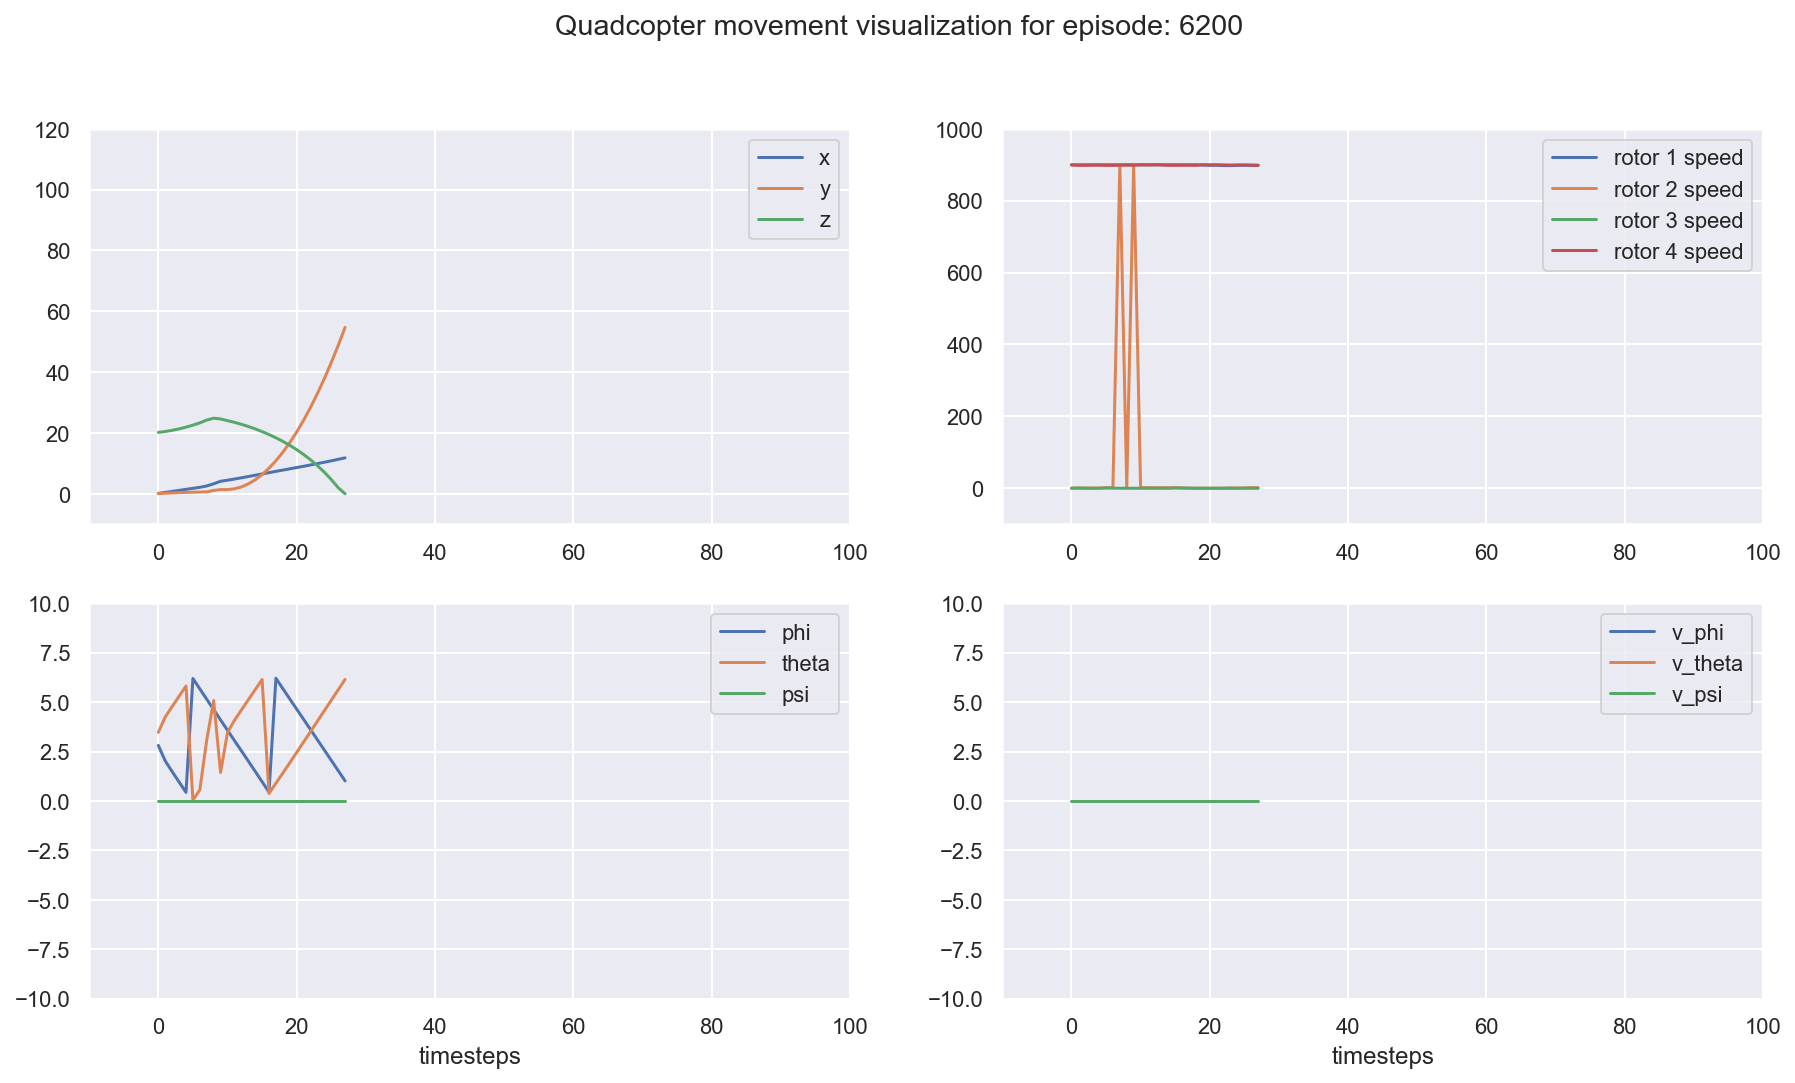

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 6400	 Avg reward: 62.63	 Current reward: 58.39	 Episode length: 25



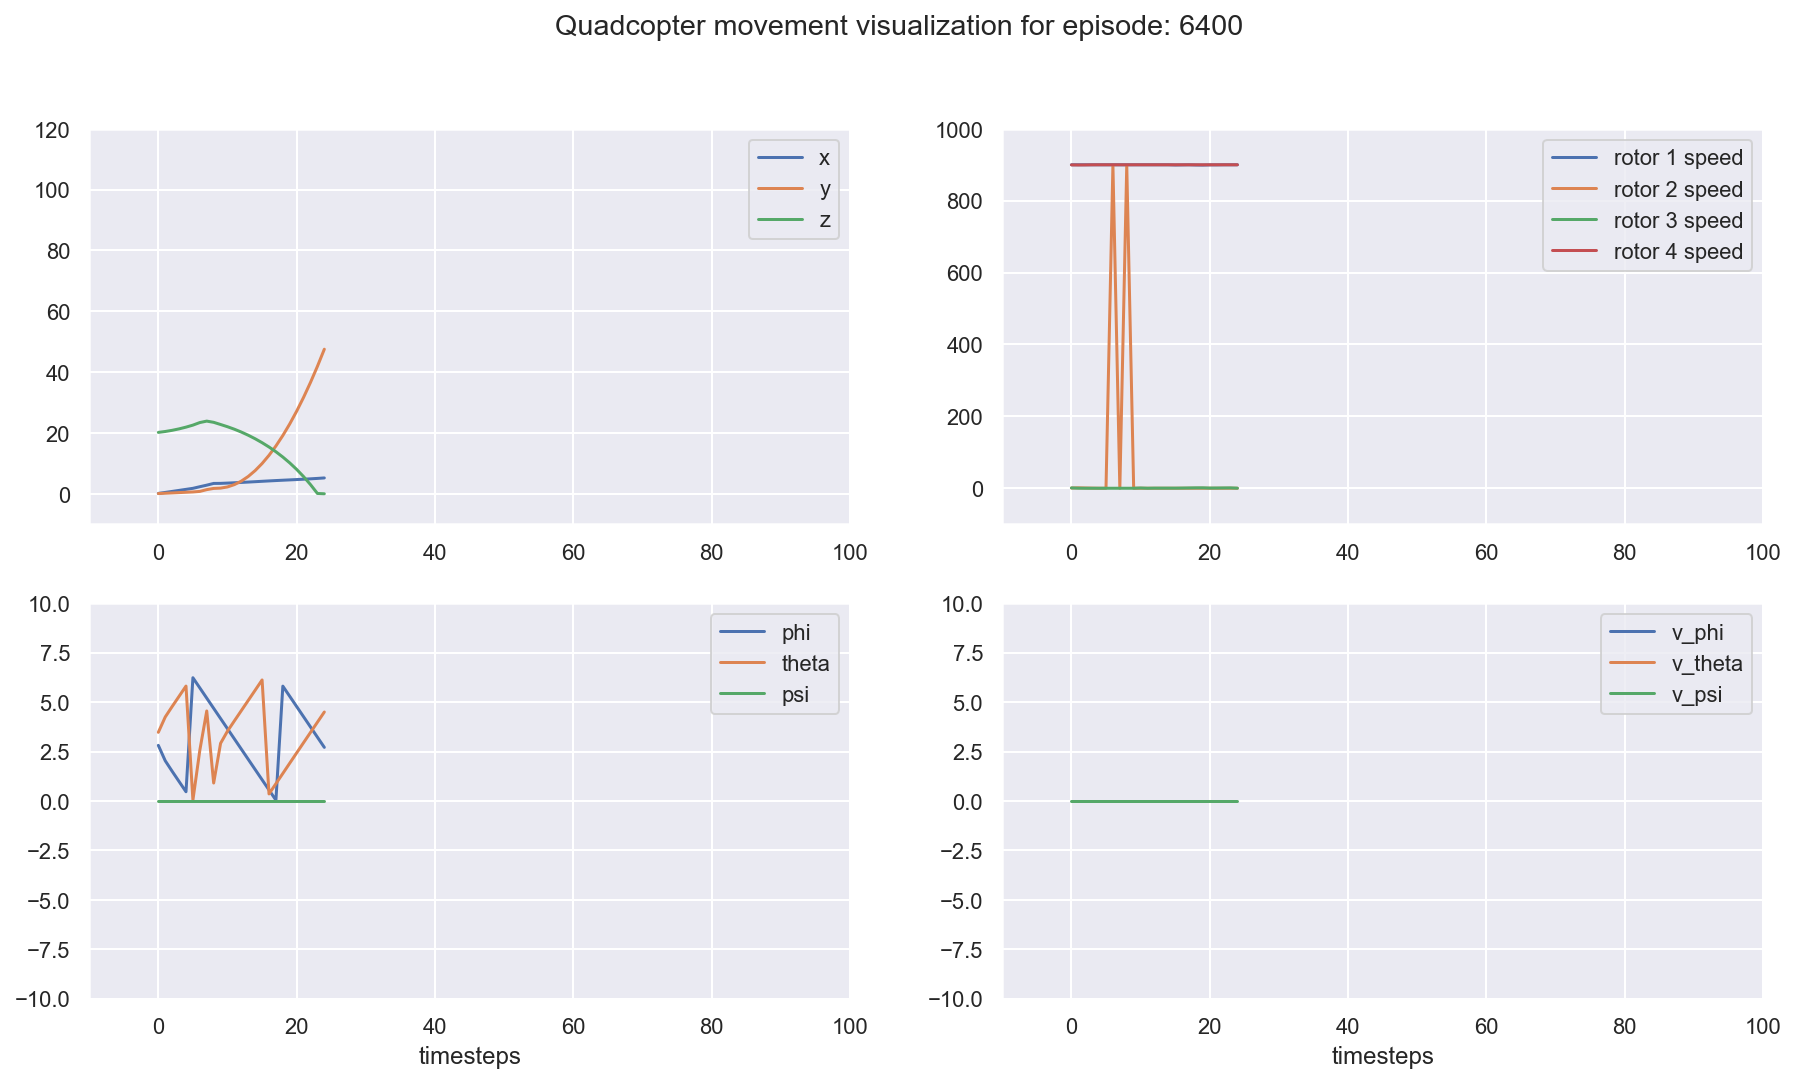

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 6600	 Avg reward: 70.10	 Current reward: 65.26	 Episode length: 26



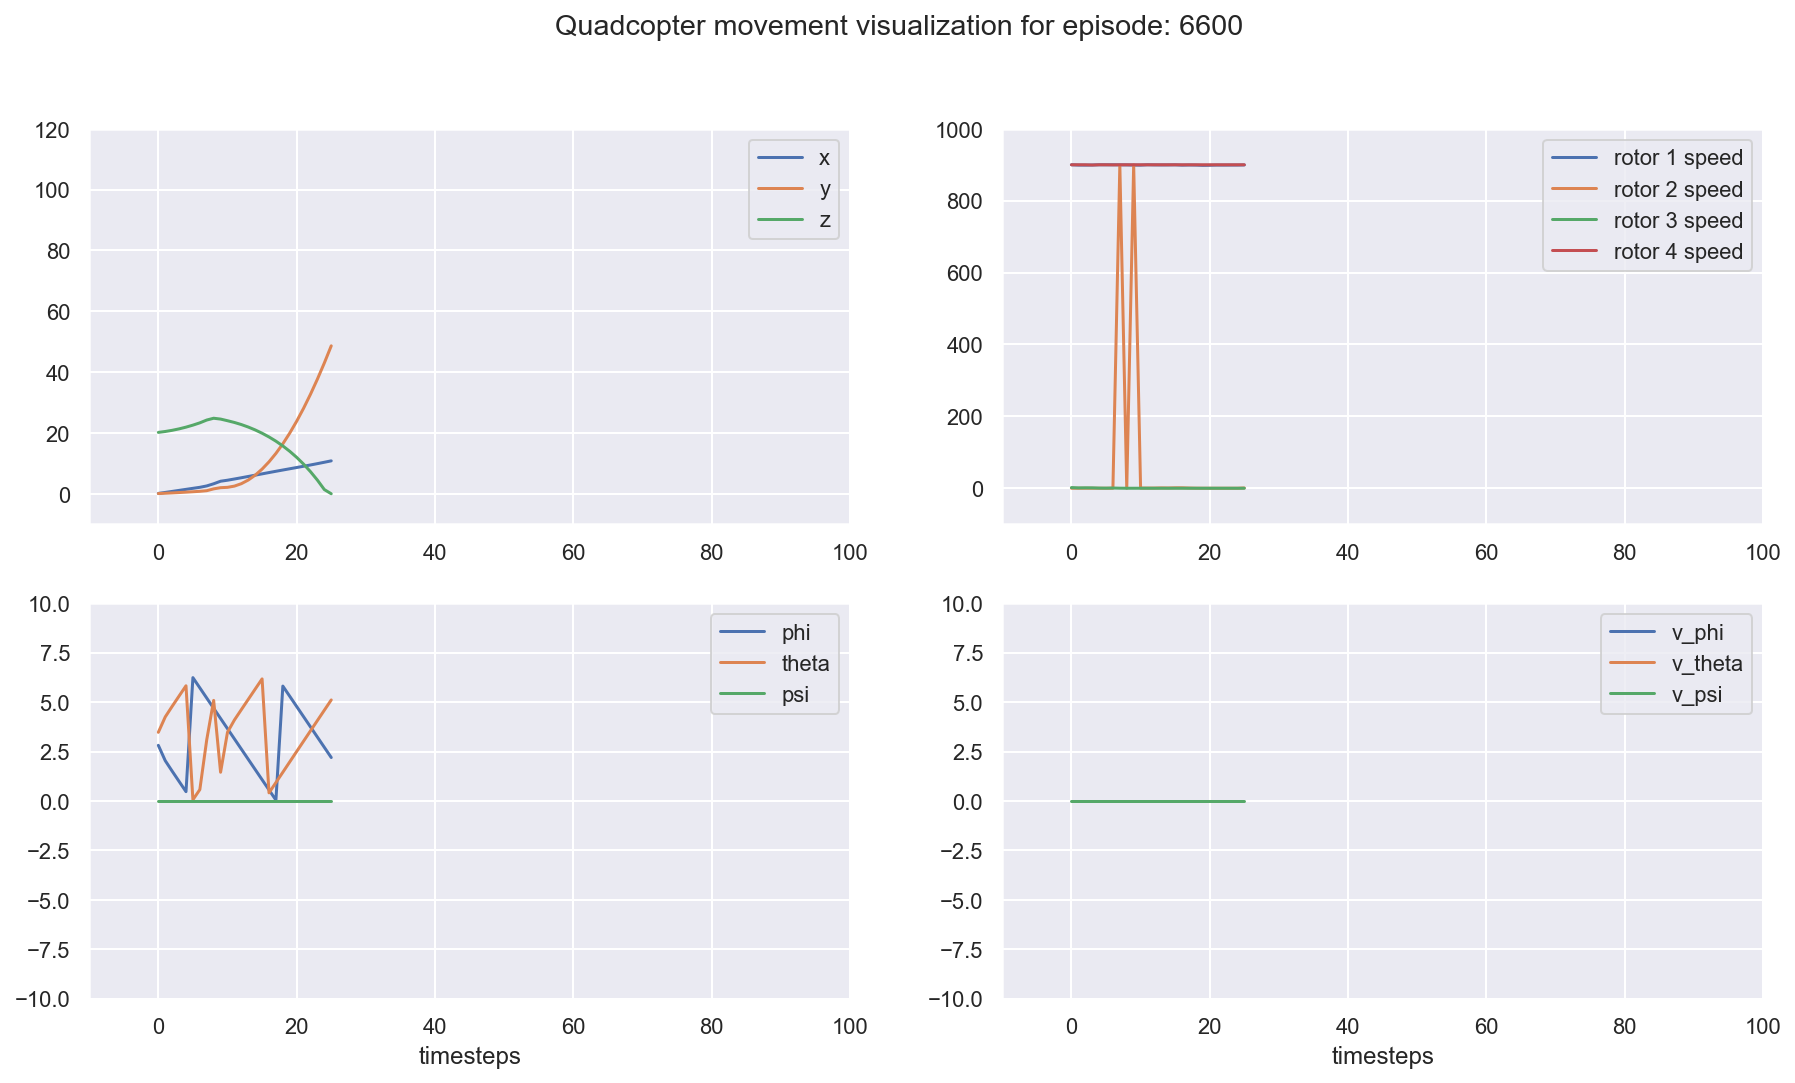

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 6800	 Avg reward: 71.31	 Current reward: 68.74	 Episode length: 27



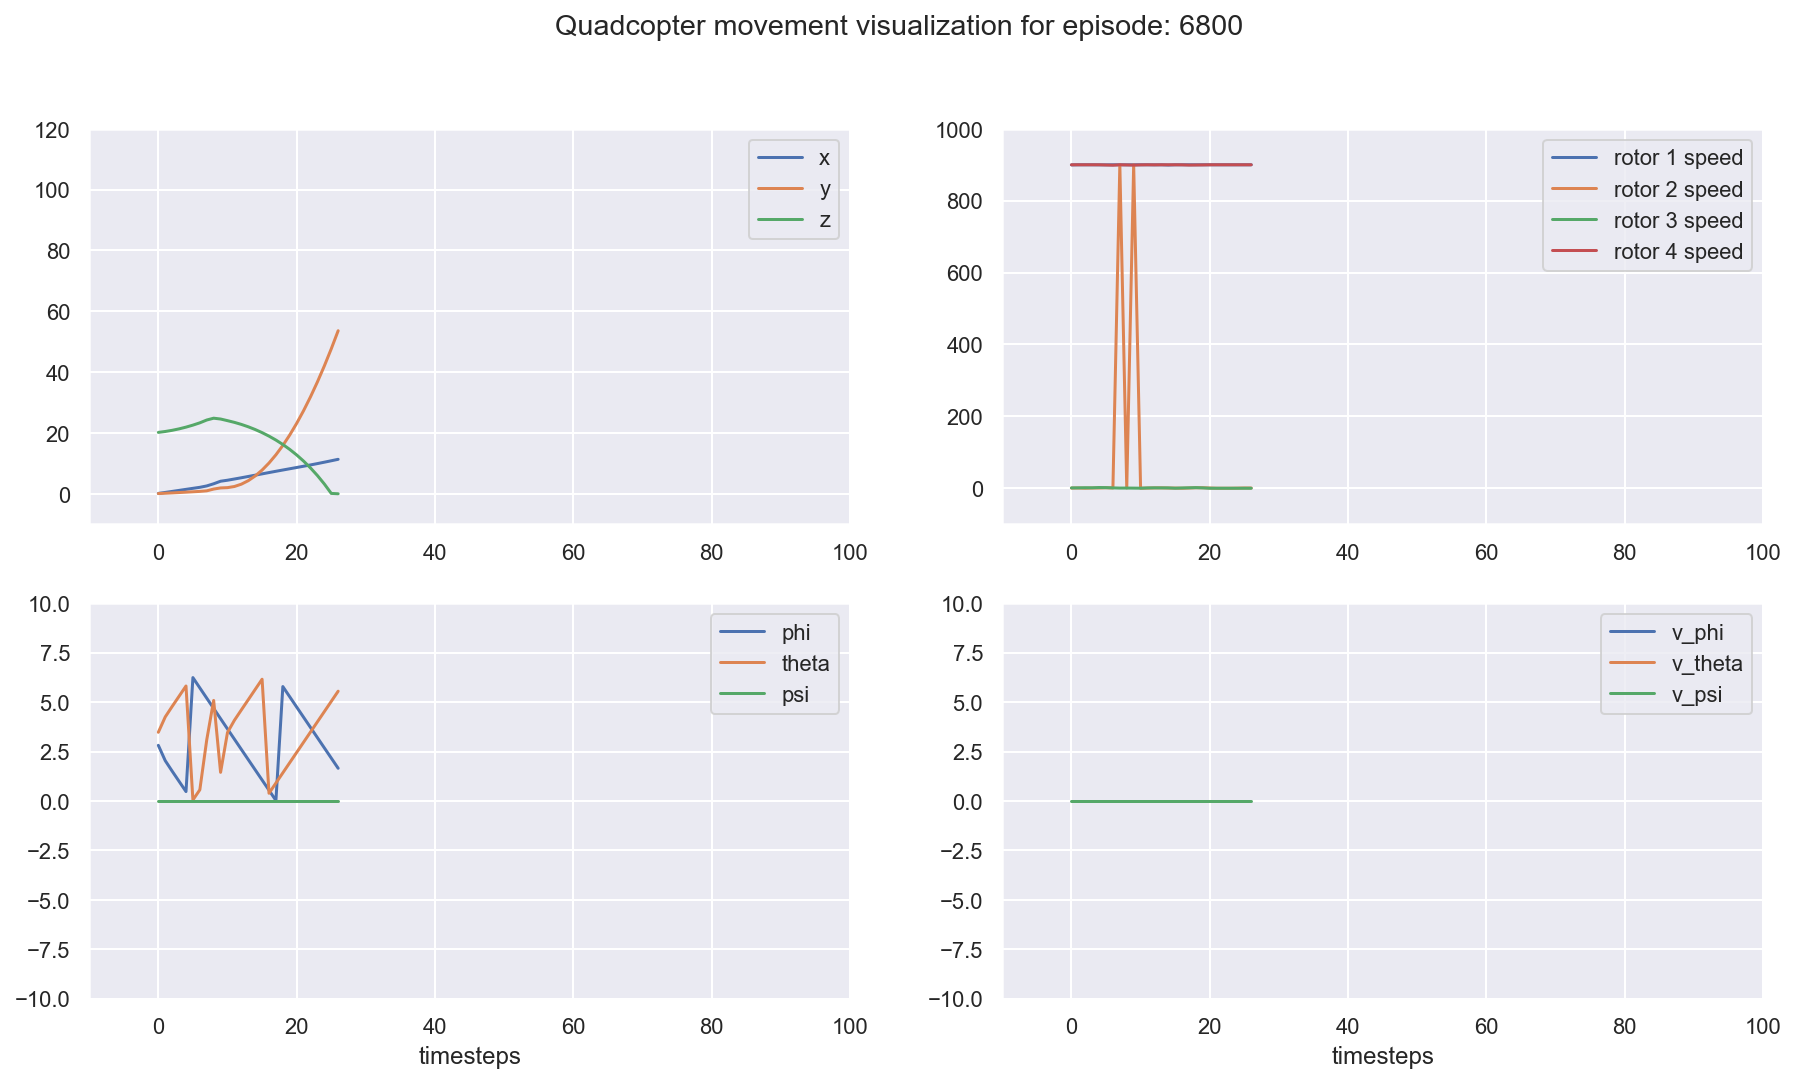

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 7000	 Avg reward: 73.32	 Current reward: 65.14	 Episode length: 26



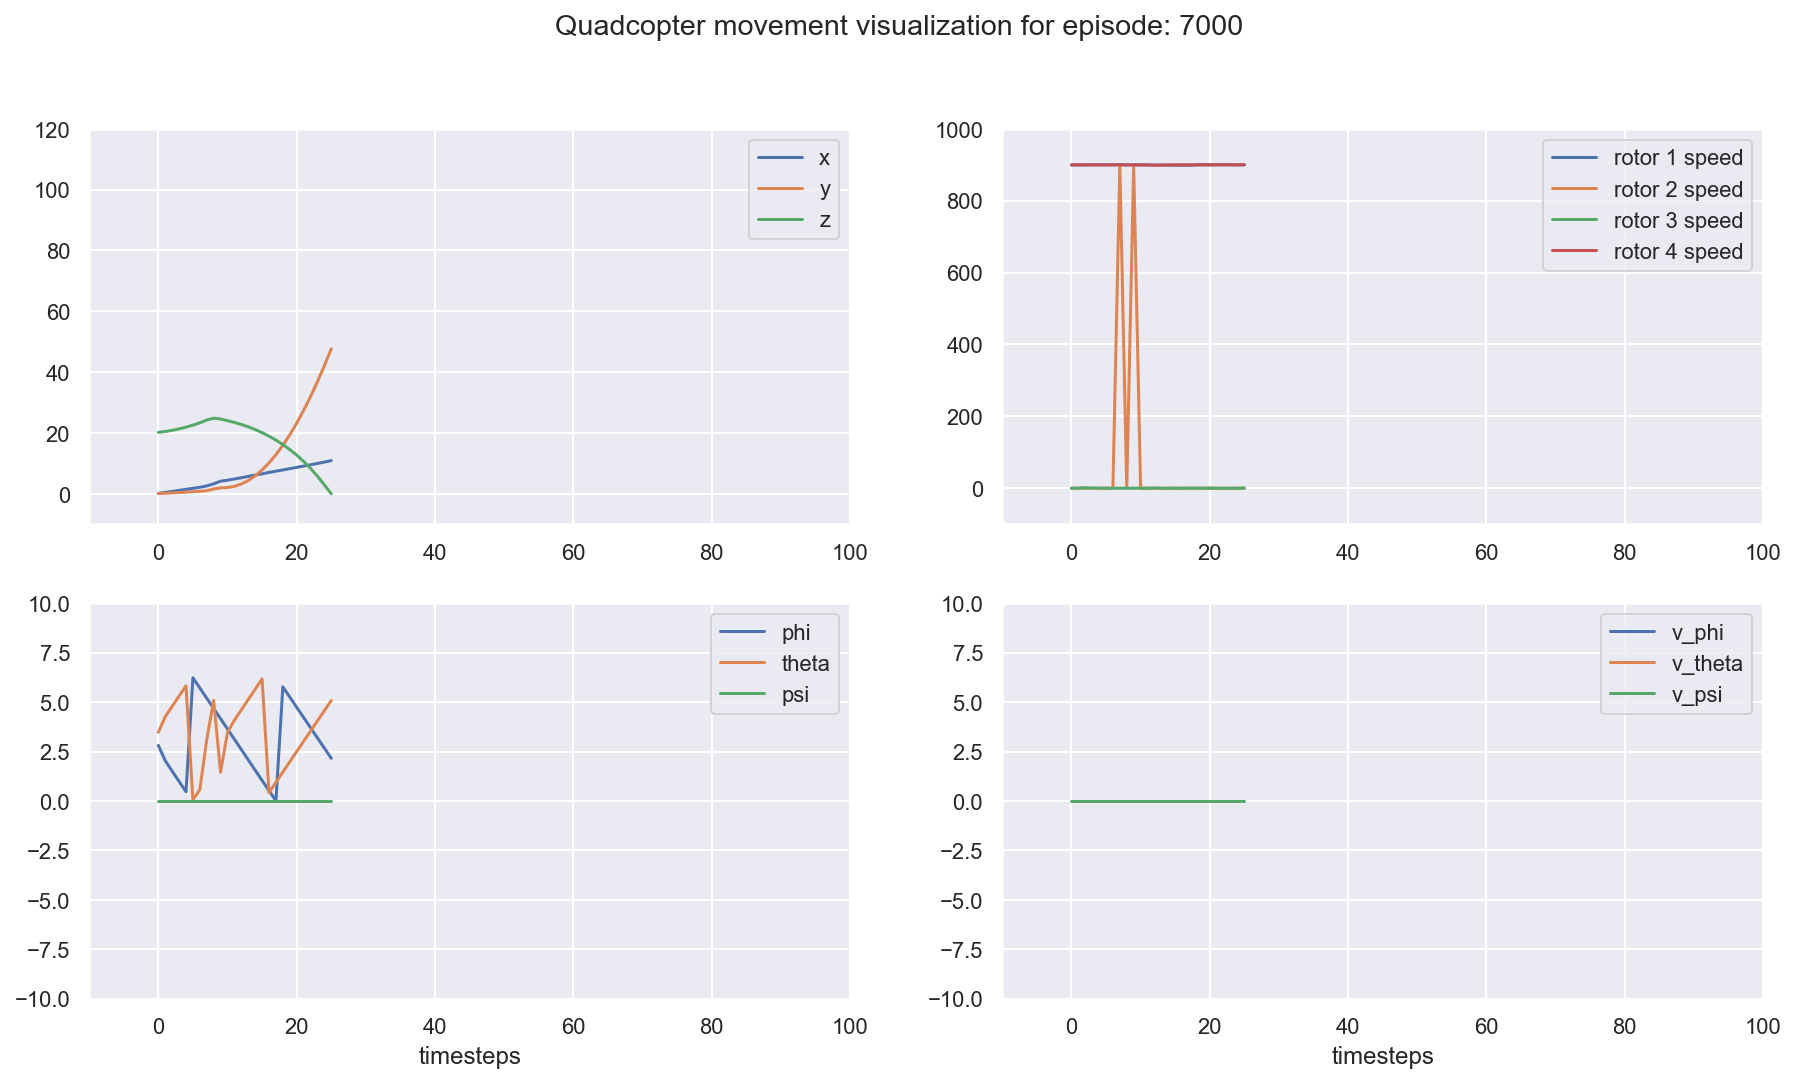

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 7200	 Avg reward: 72.89	 Current reward: 64.89	 Episode length: 26



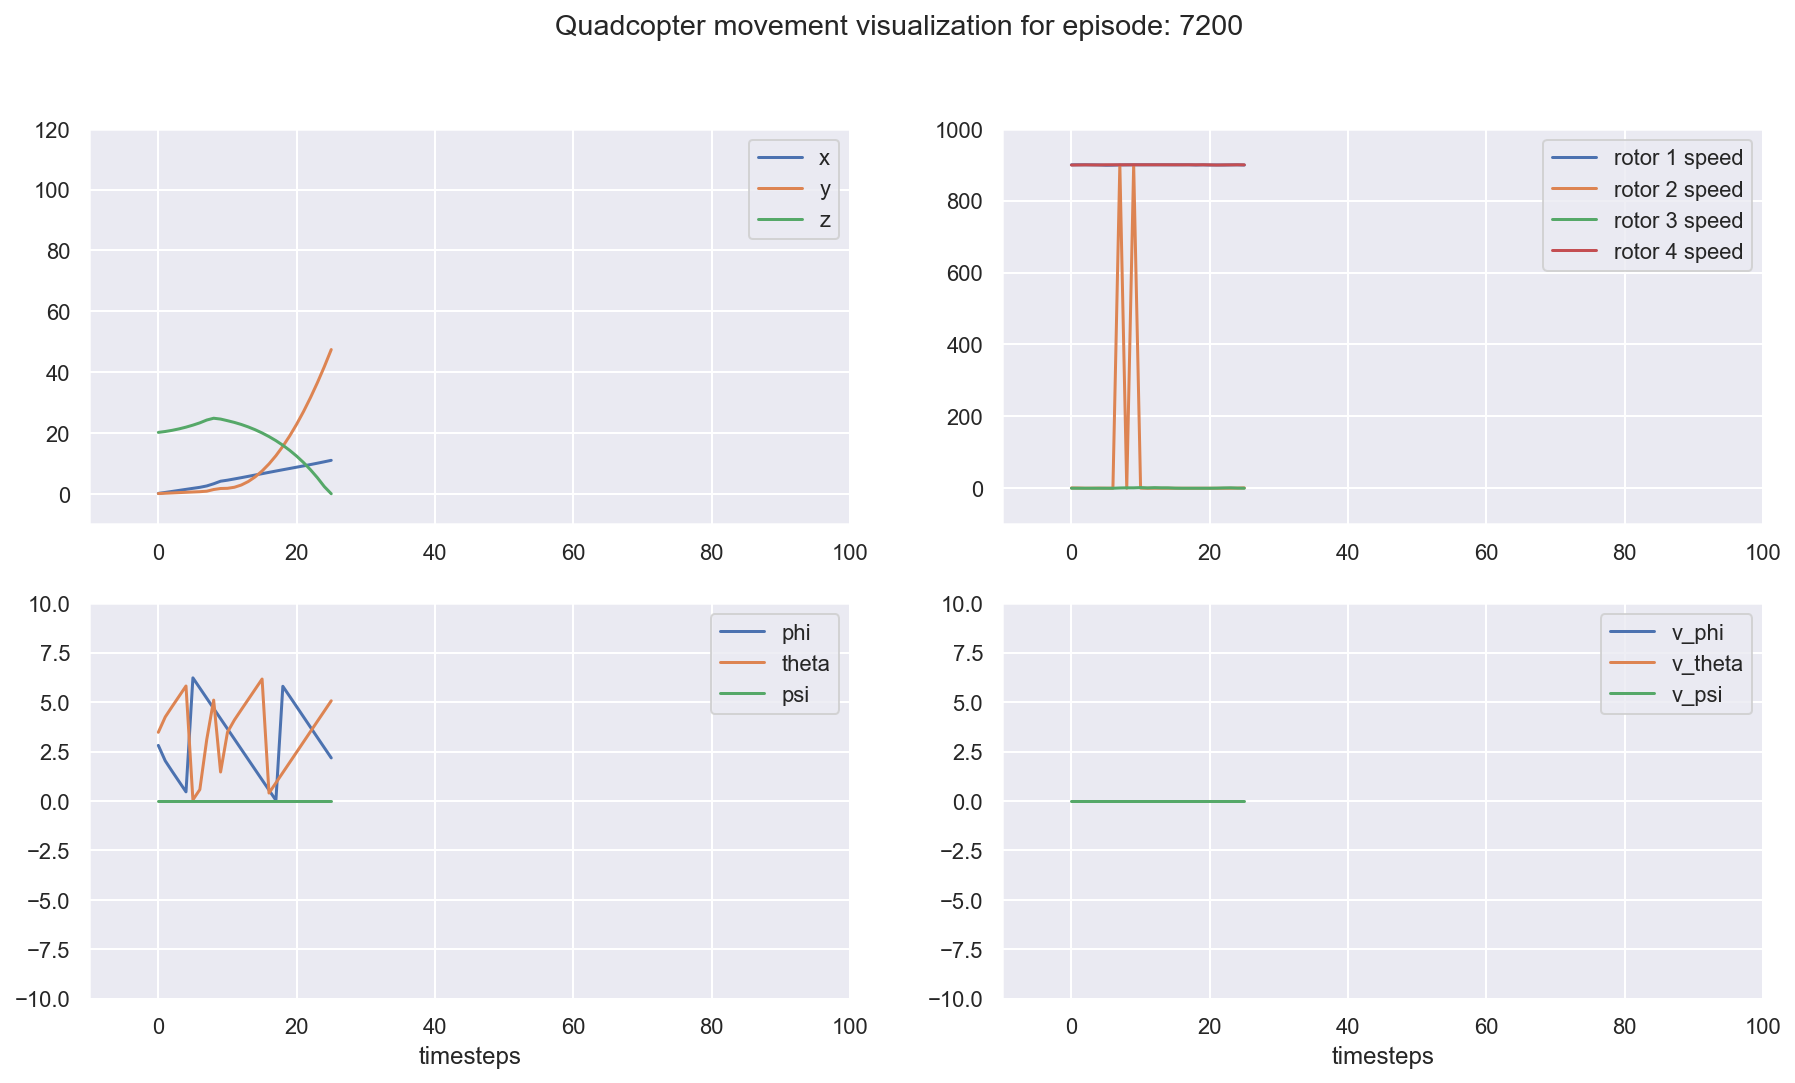

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 7400	 Avg reward: 72.54	 Current reward: 64.99	 Episode length: 26



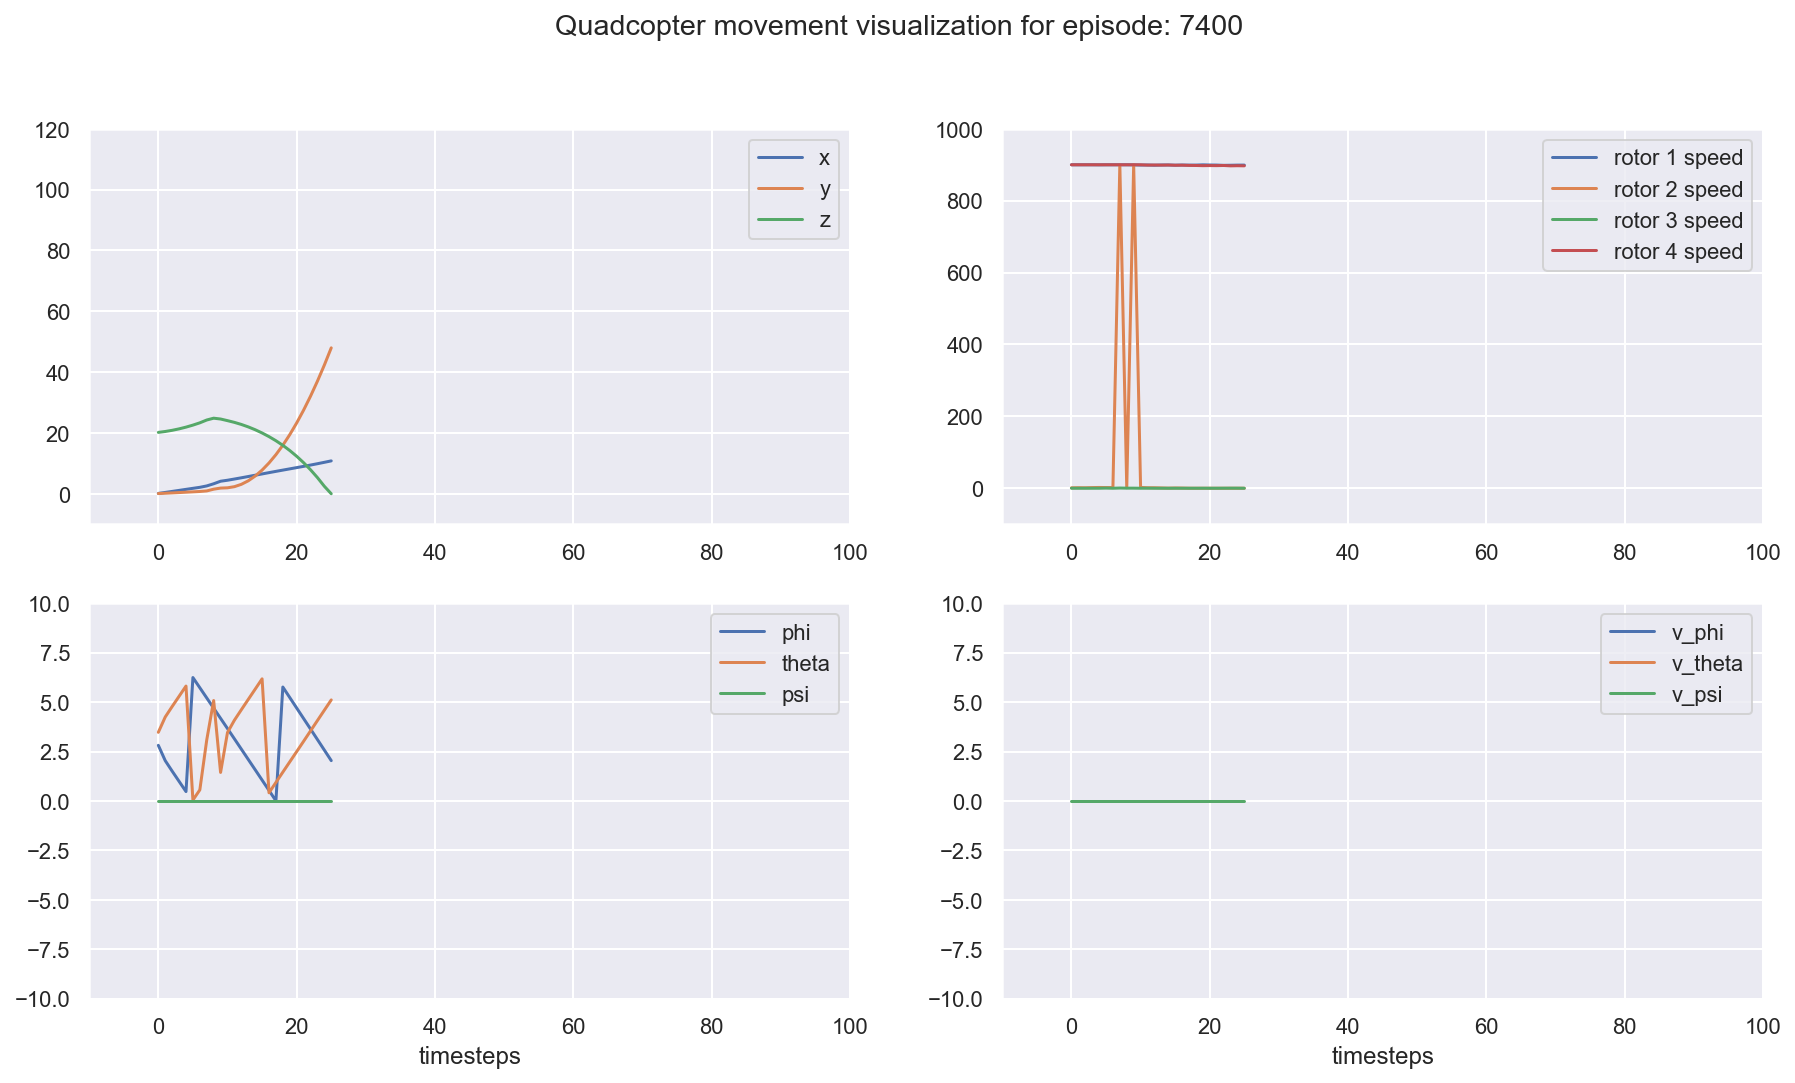

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 7600	 Avg reward: 91.70	 Current reward: 84.07	 Episode length: 30



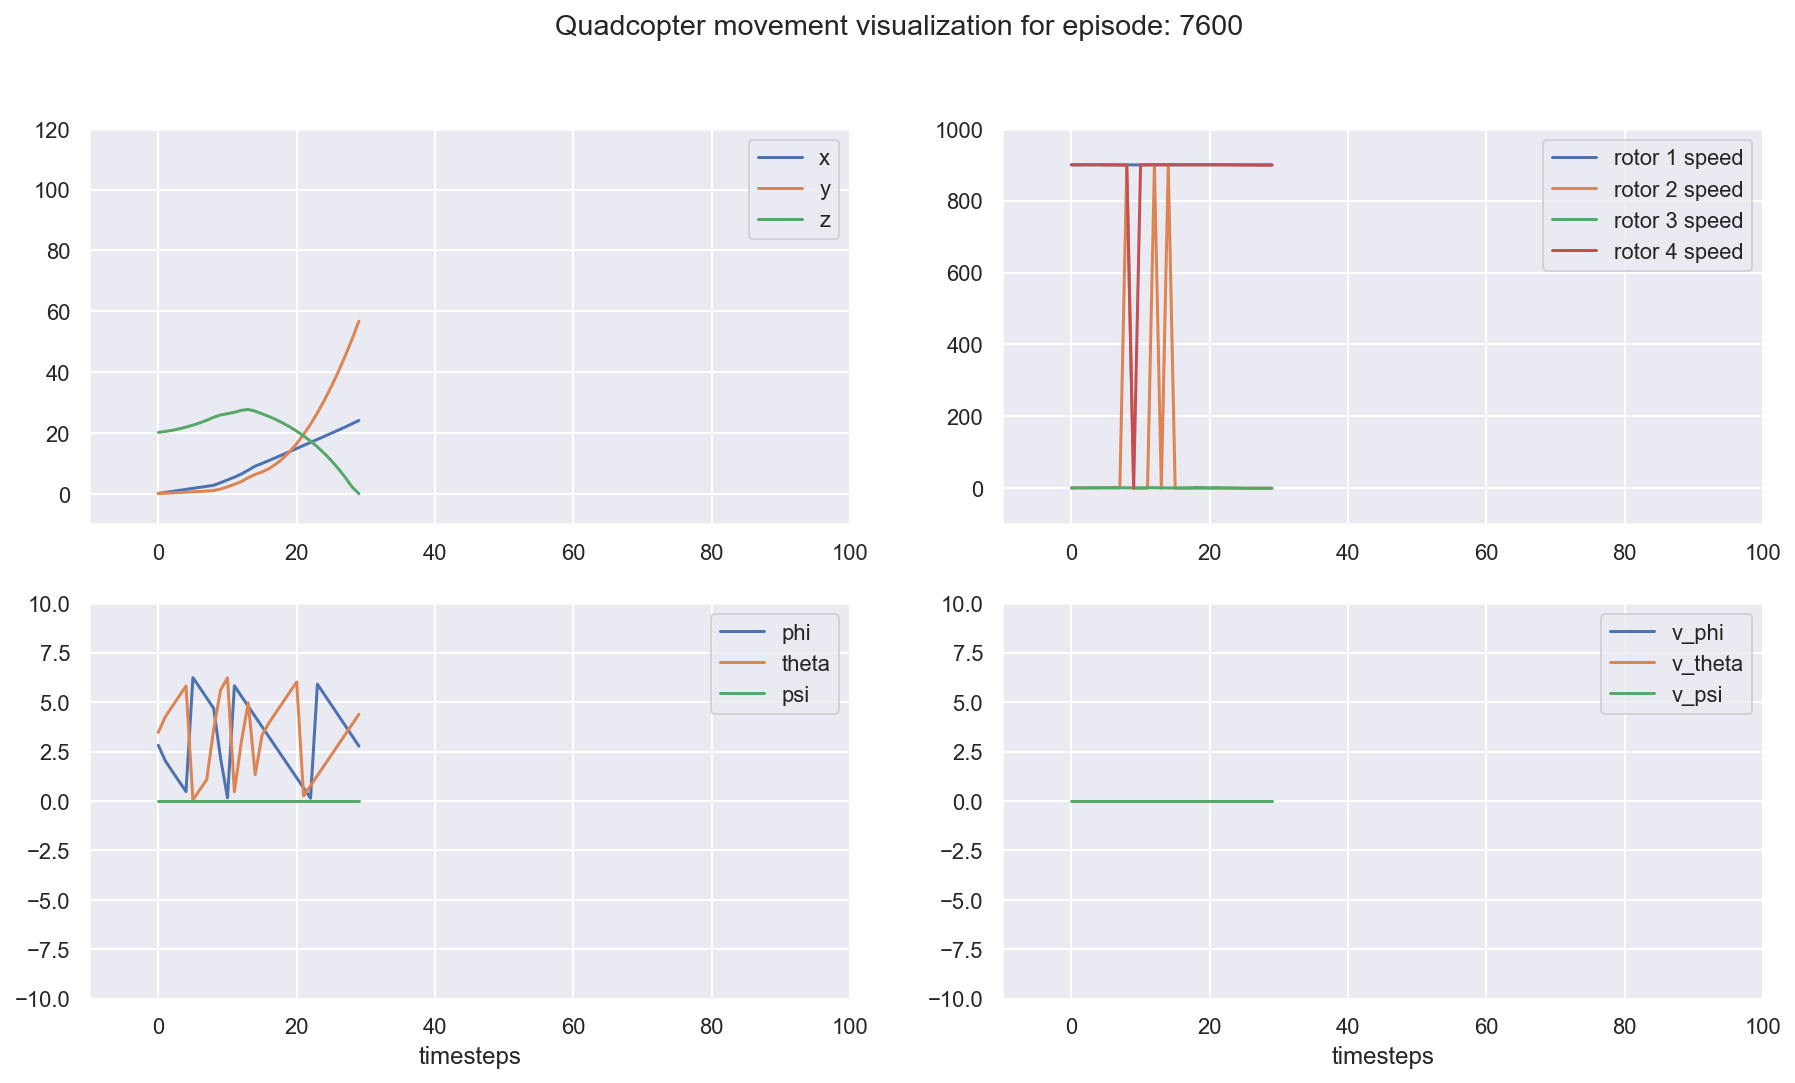

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 7800	 Avg reward: 105.75	 Current reward: 152.81	 Episode length: 51



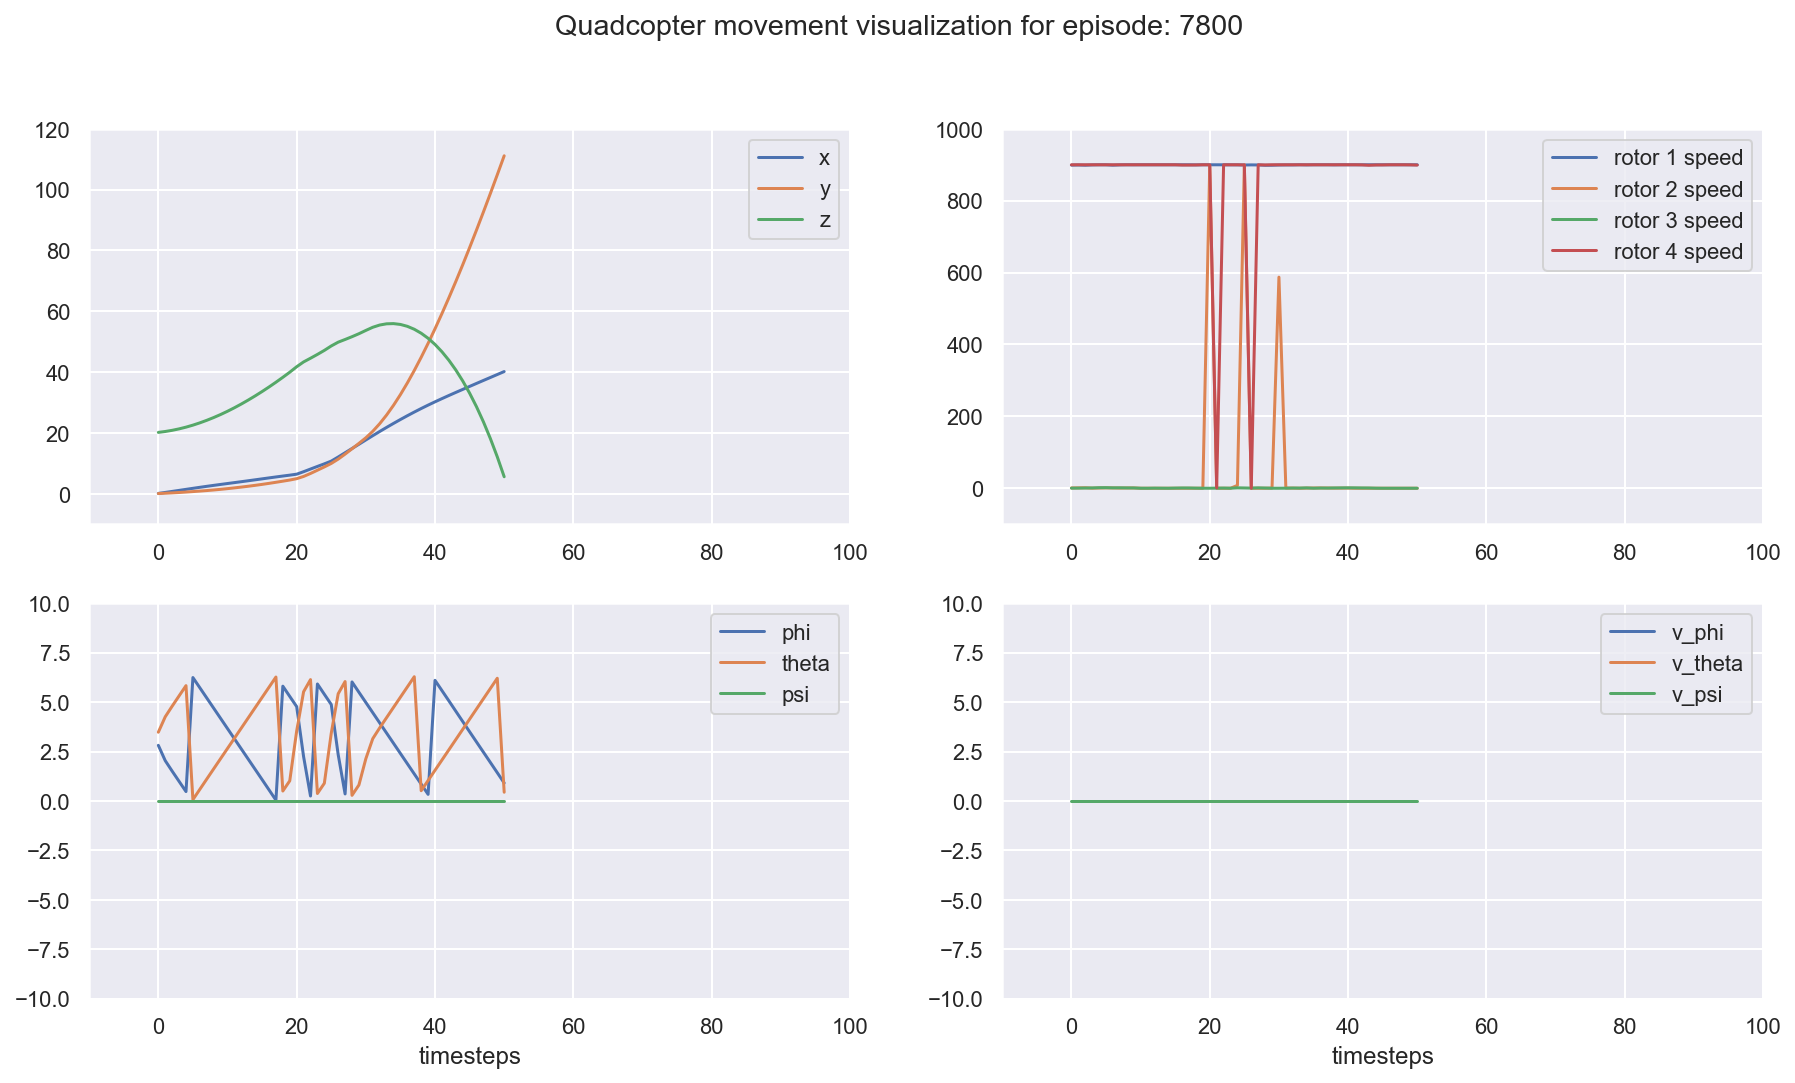

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 8000	 Avg reward: 100.96	 Current reward: 80.63	 Episode length: 29



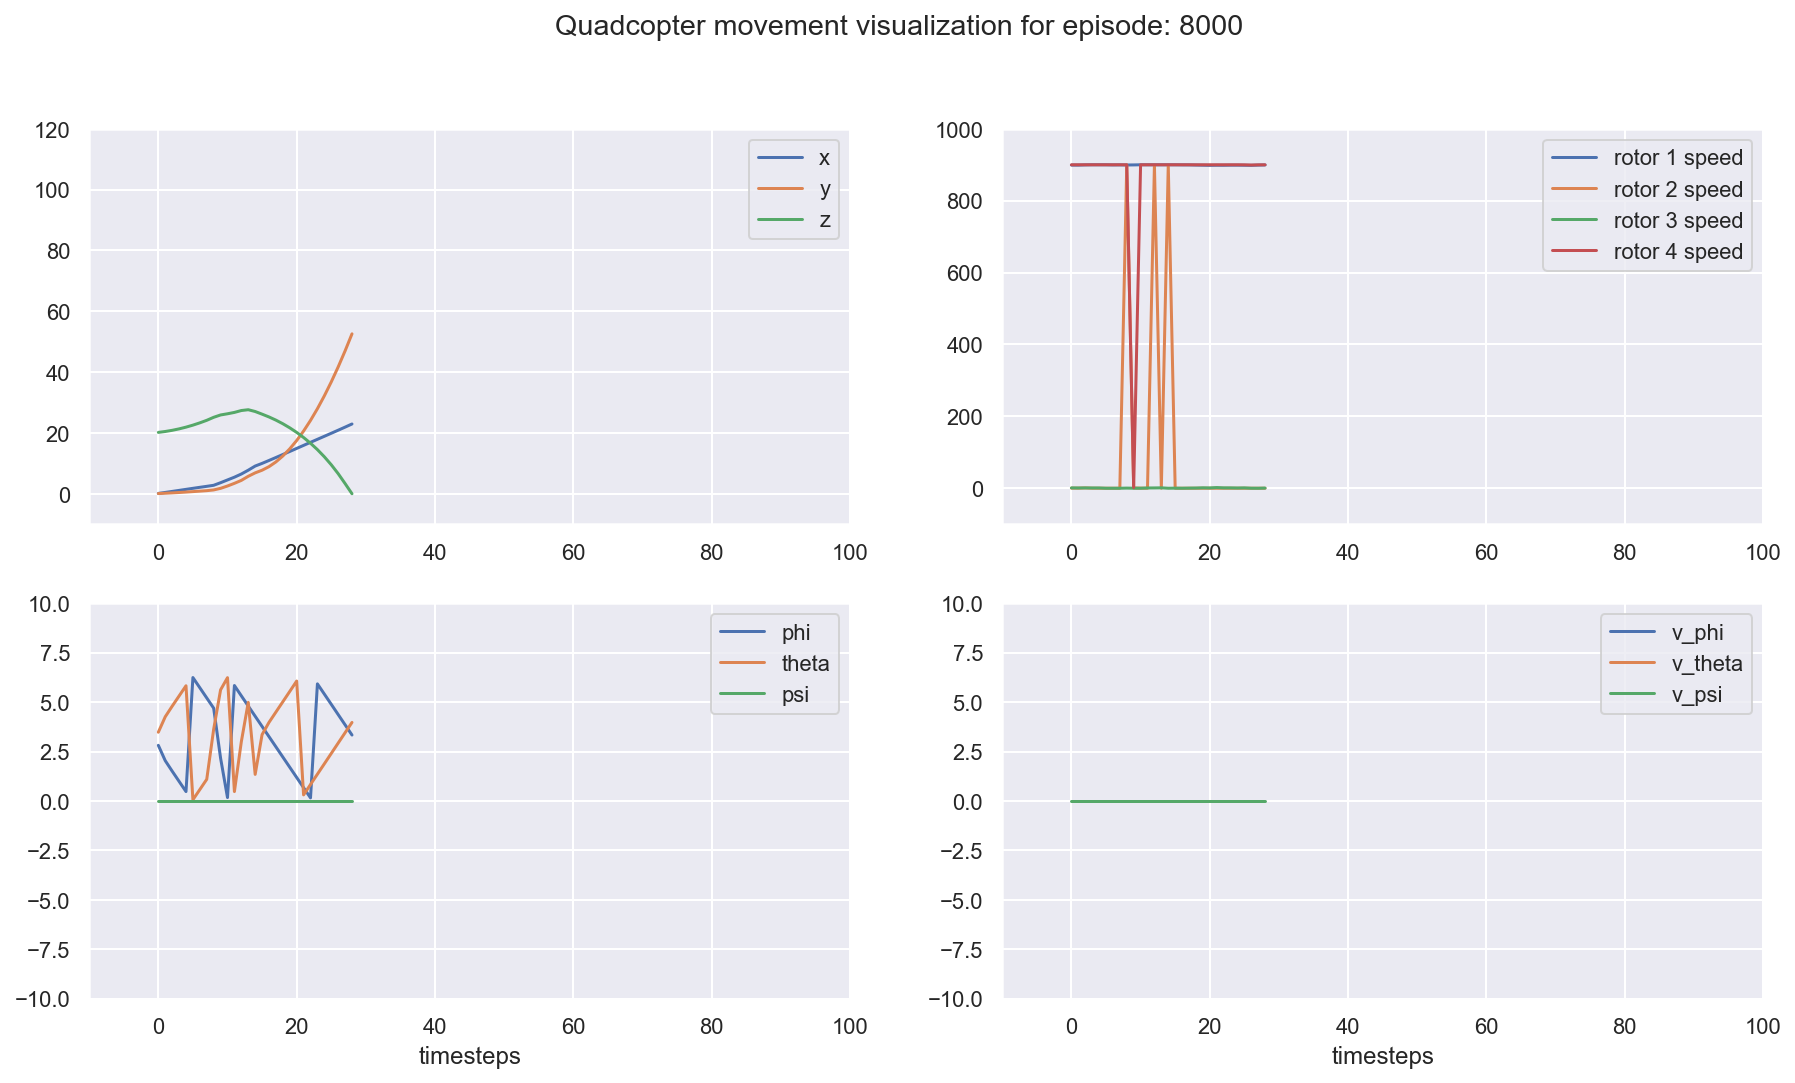

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 8200	 Avg reward: 109.60	 Current reward: 150.09	 Episode length: 51



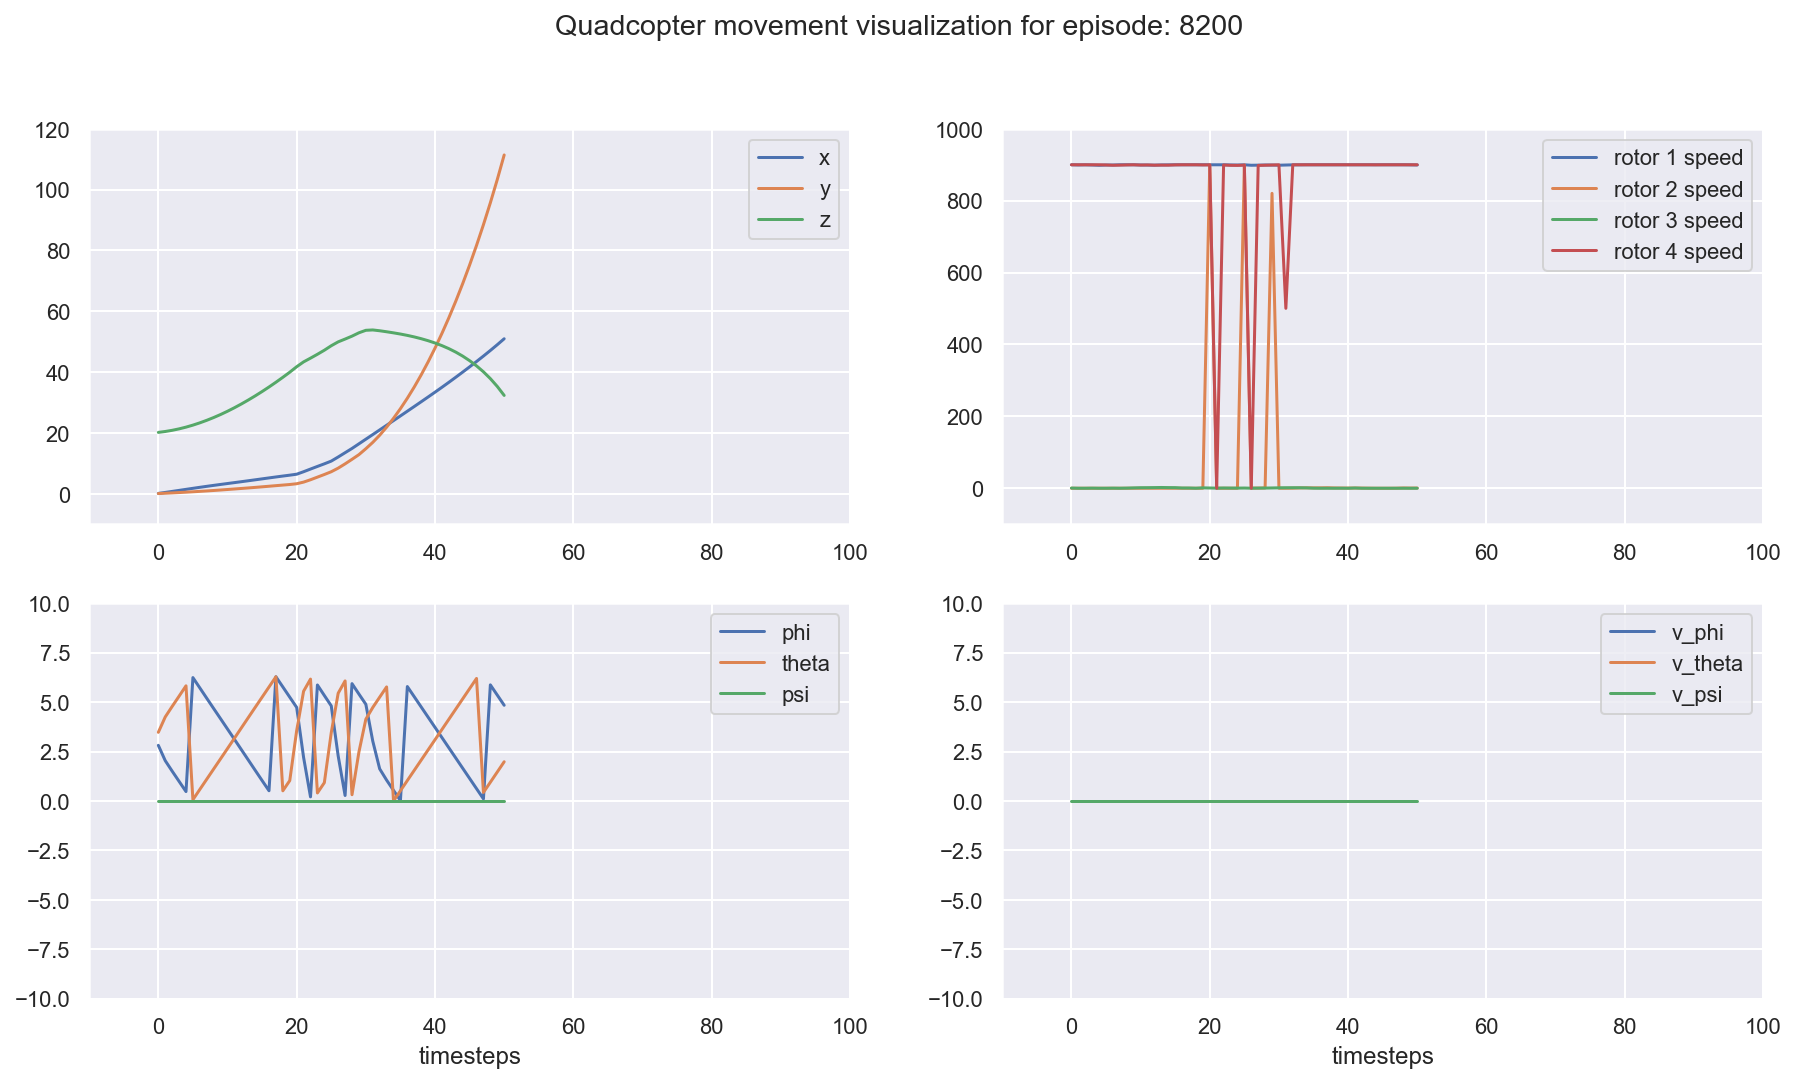

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 8400	 Avg reward: 114.64	 Current reward: 99.07	 Episode length: 34



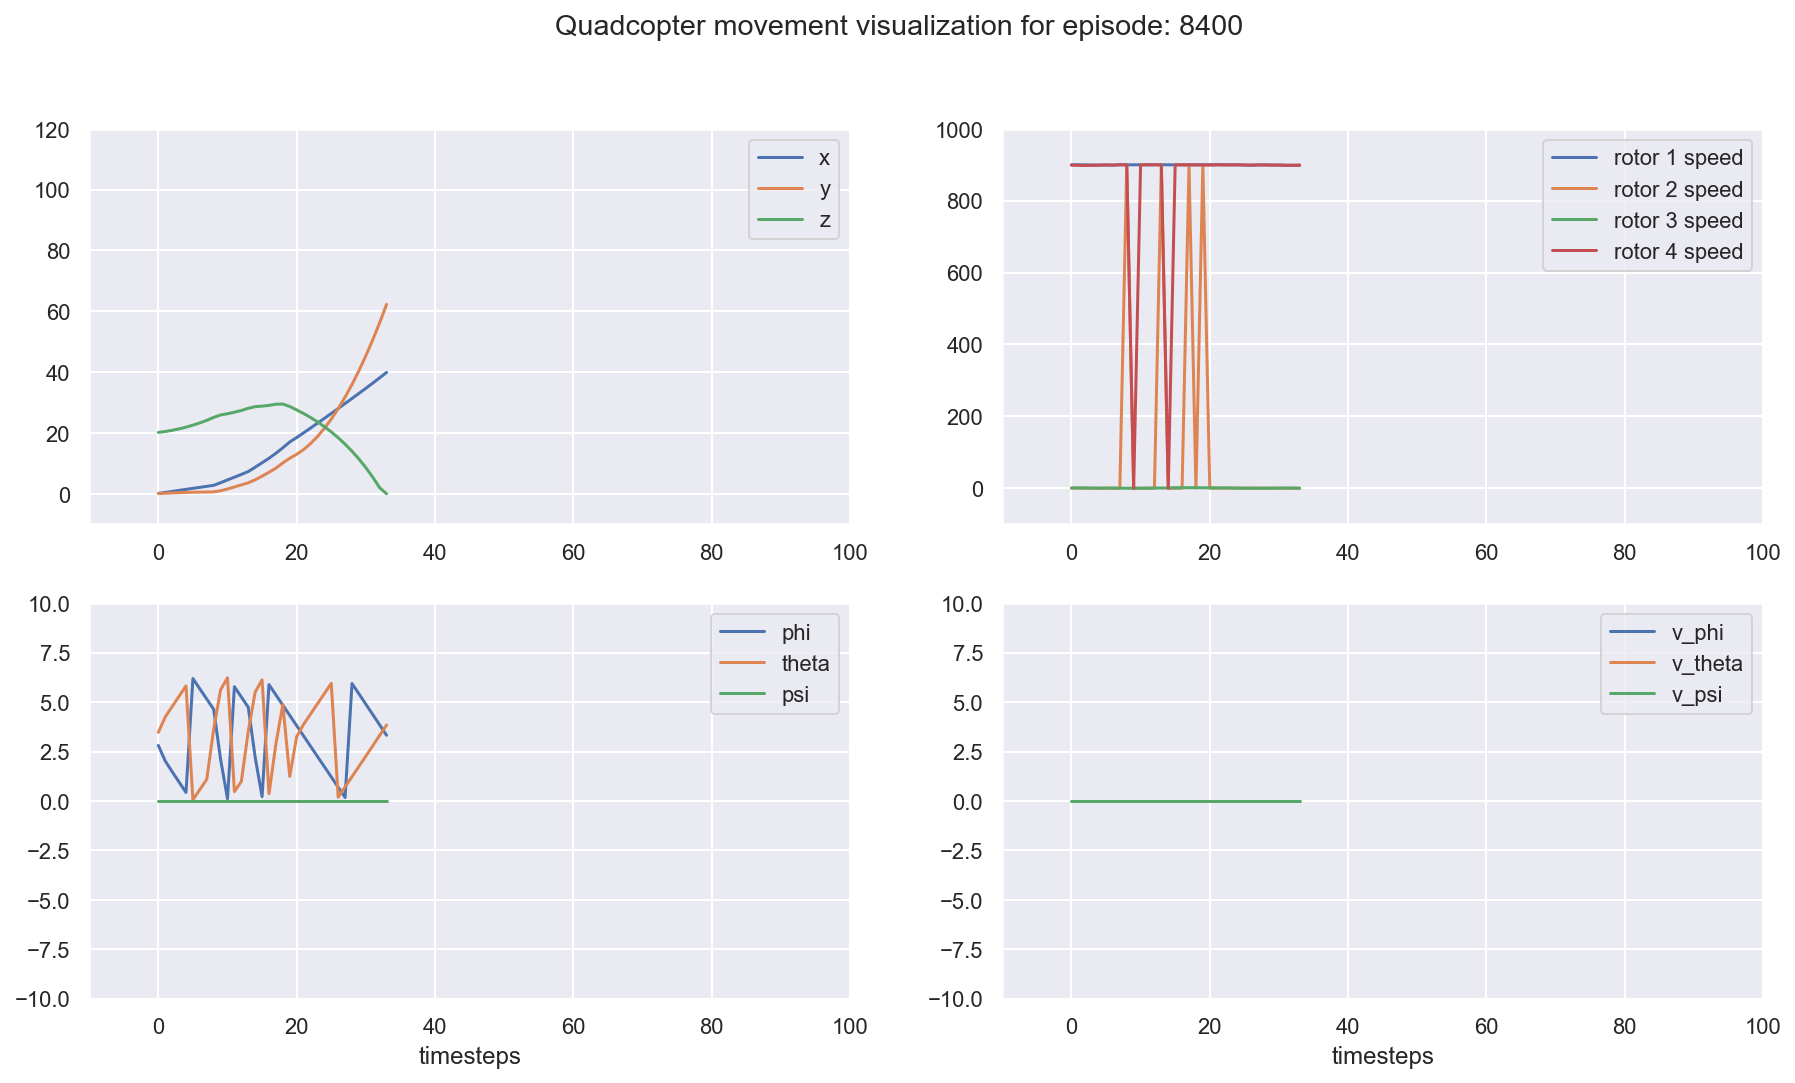

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 8600	 Avg reward: 114.28	 Current reward: 92.75	 Episode length: 32



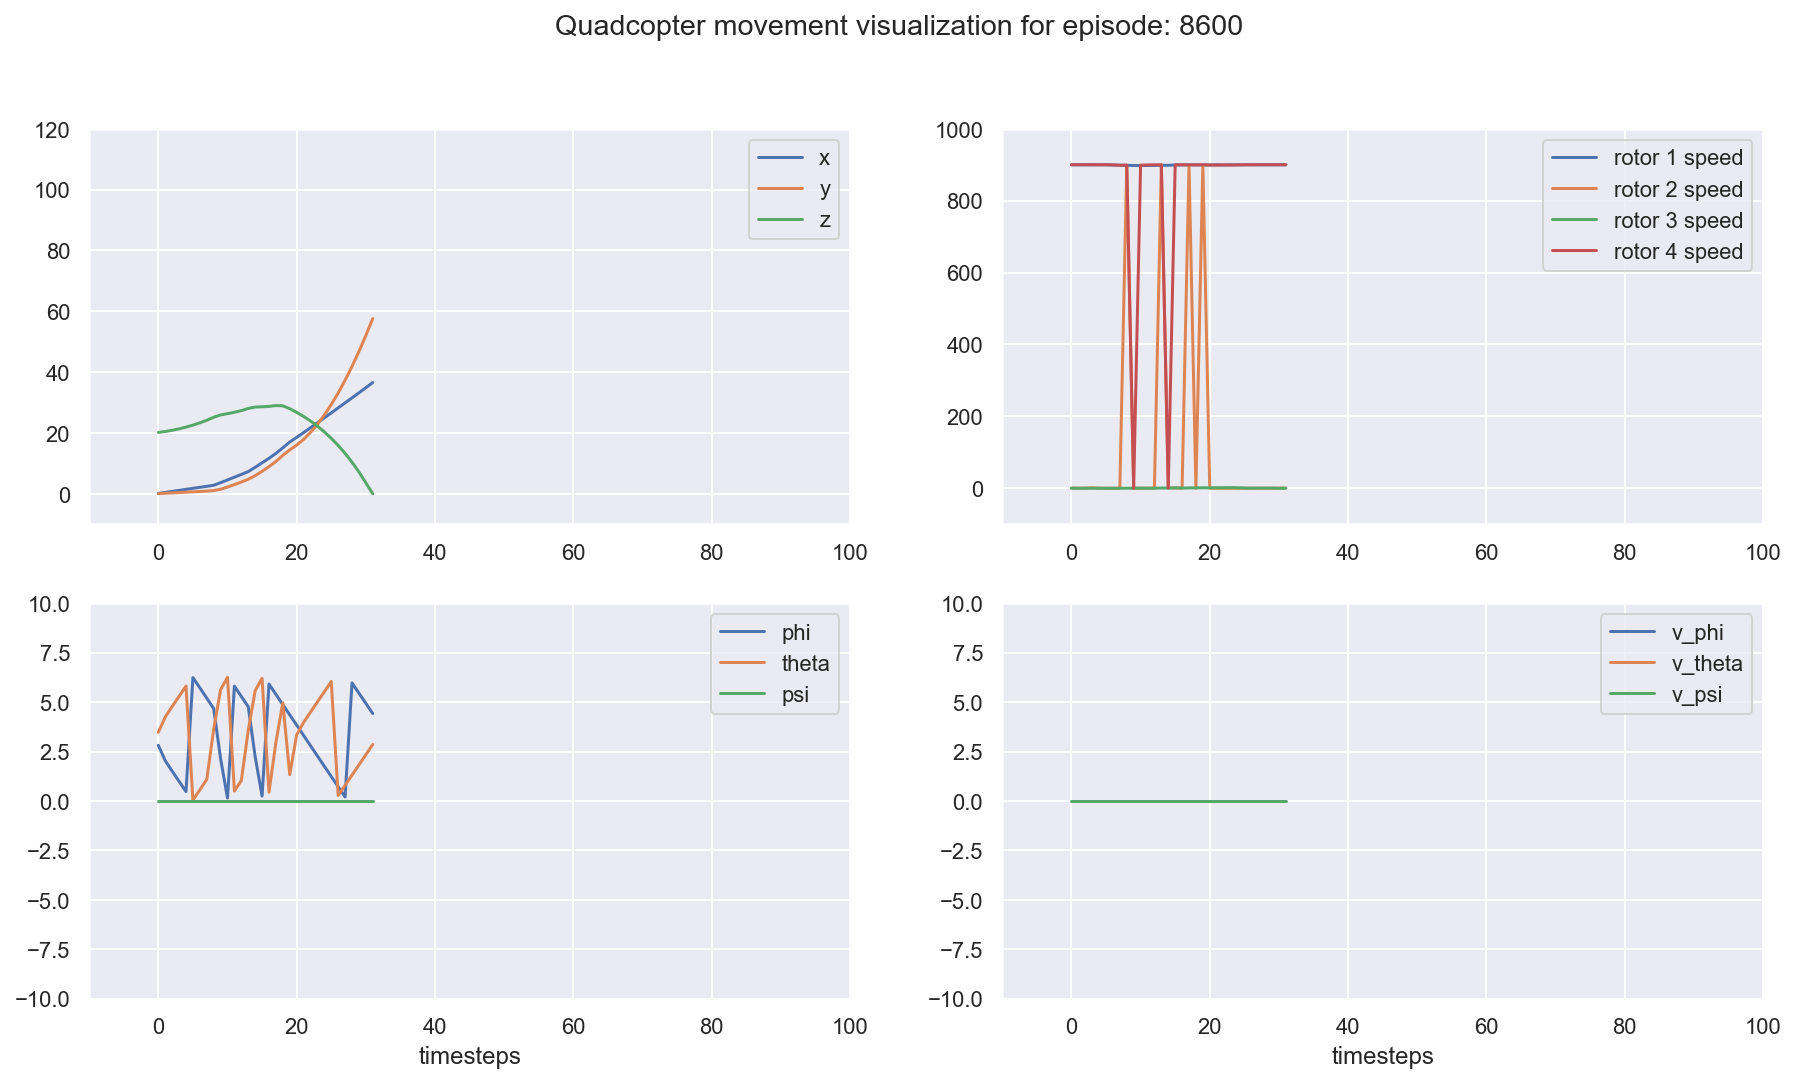

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 8800	 Avg reward: 114.45	 Current reward: 133.23	 Episode length: 51



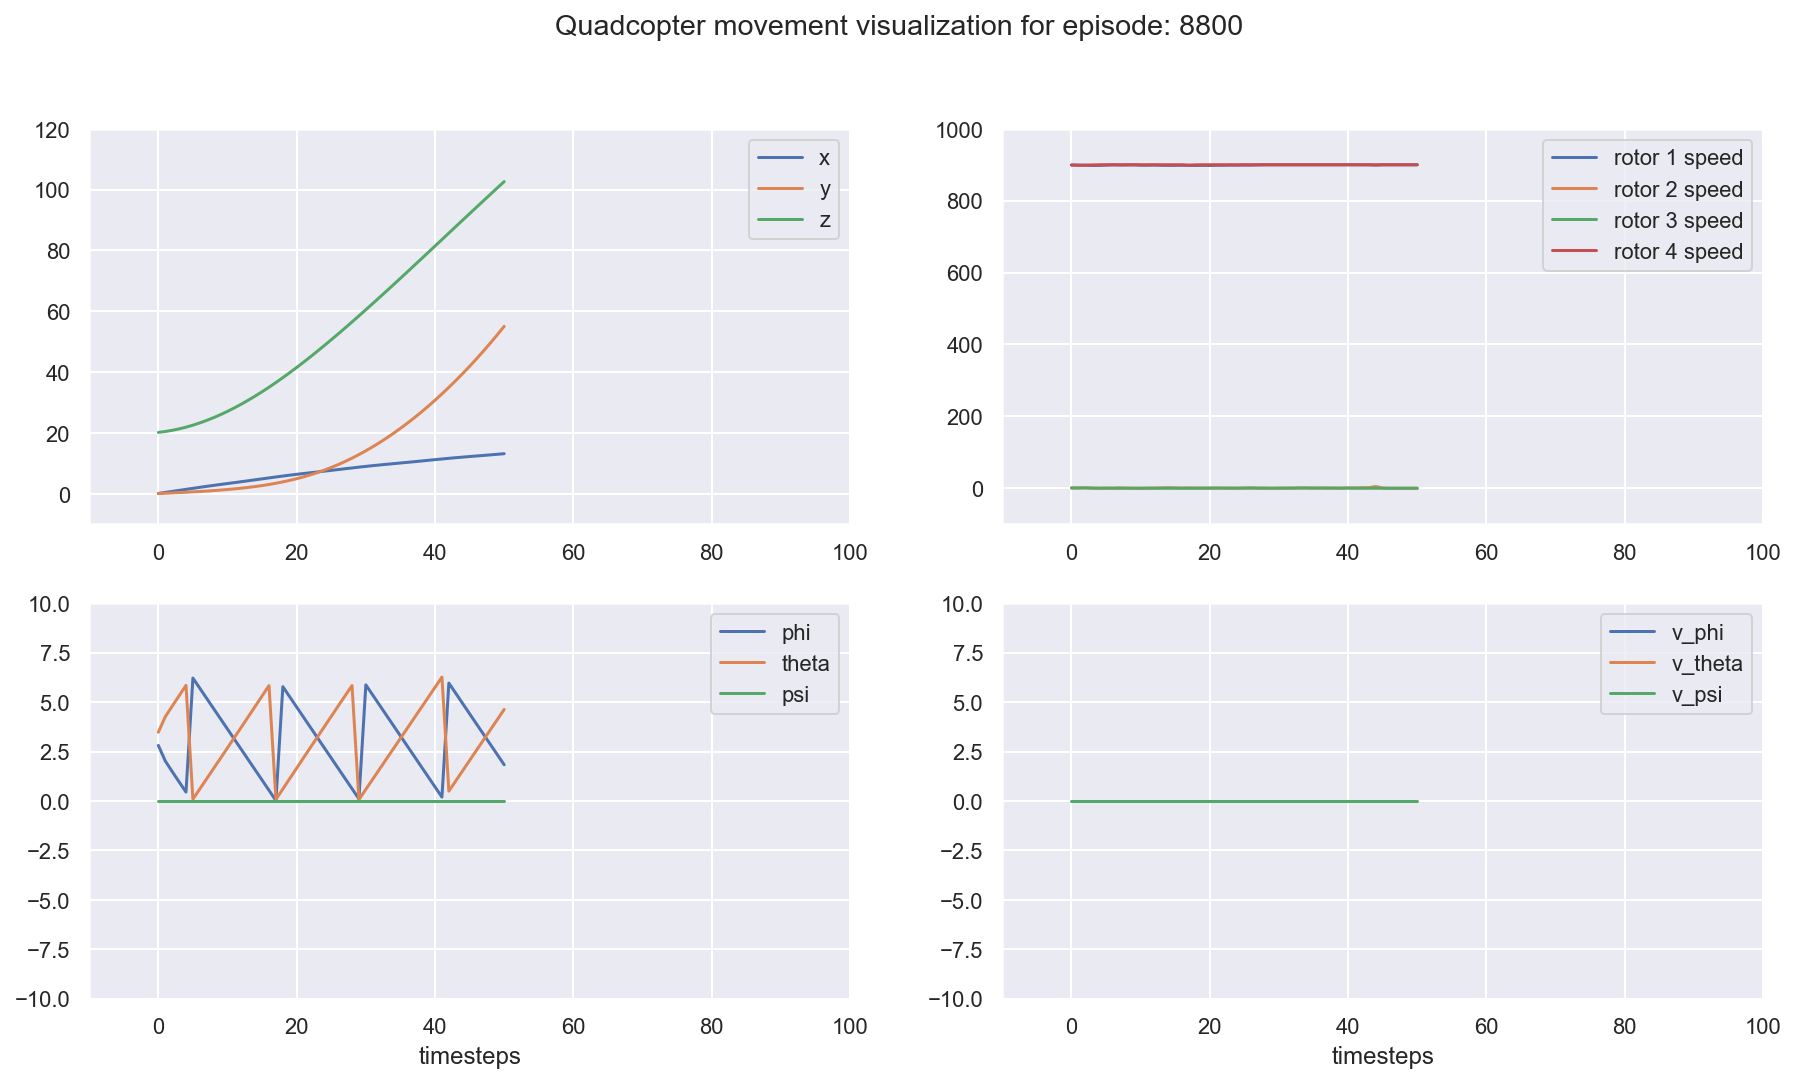

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 9000	 Avg reward: 143.76	 Current reward: 168.51	 Episode length: 51



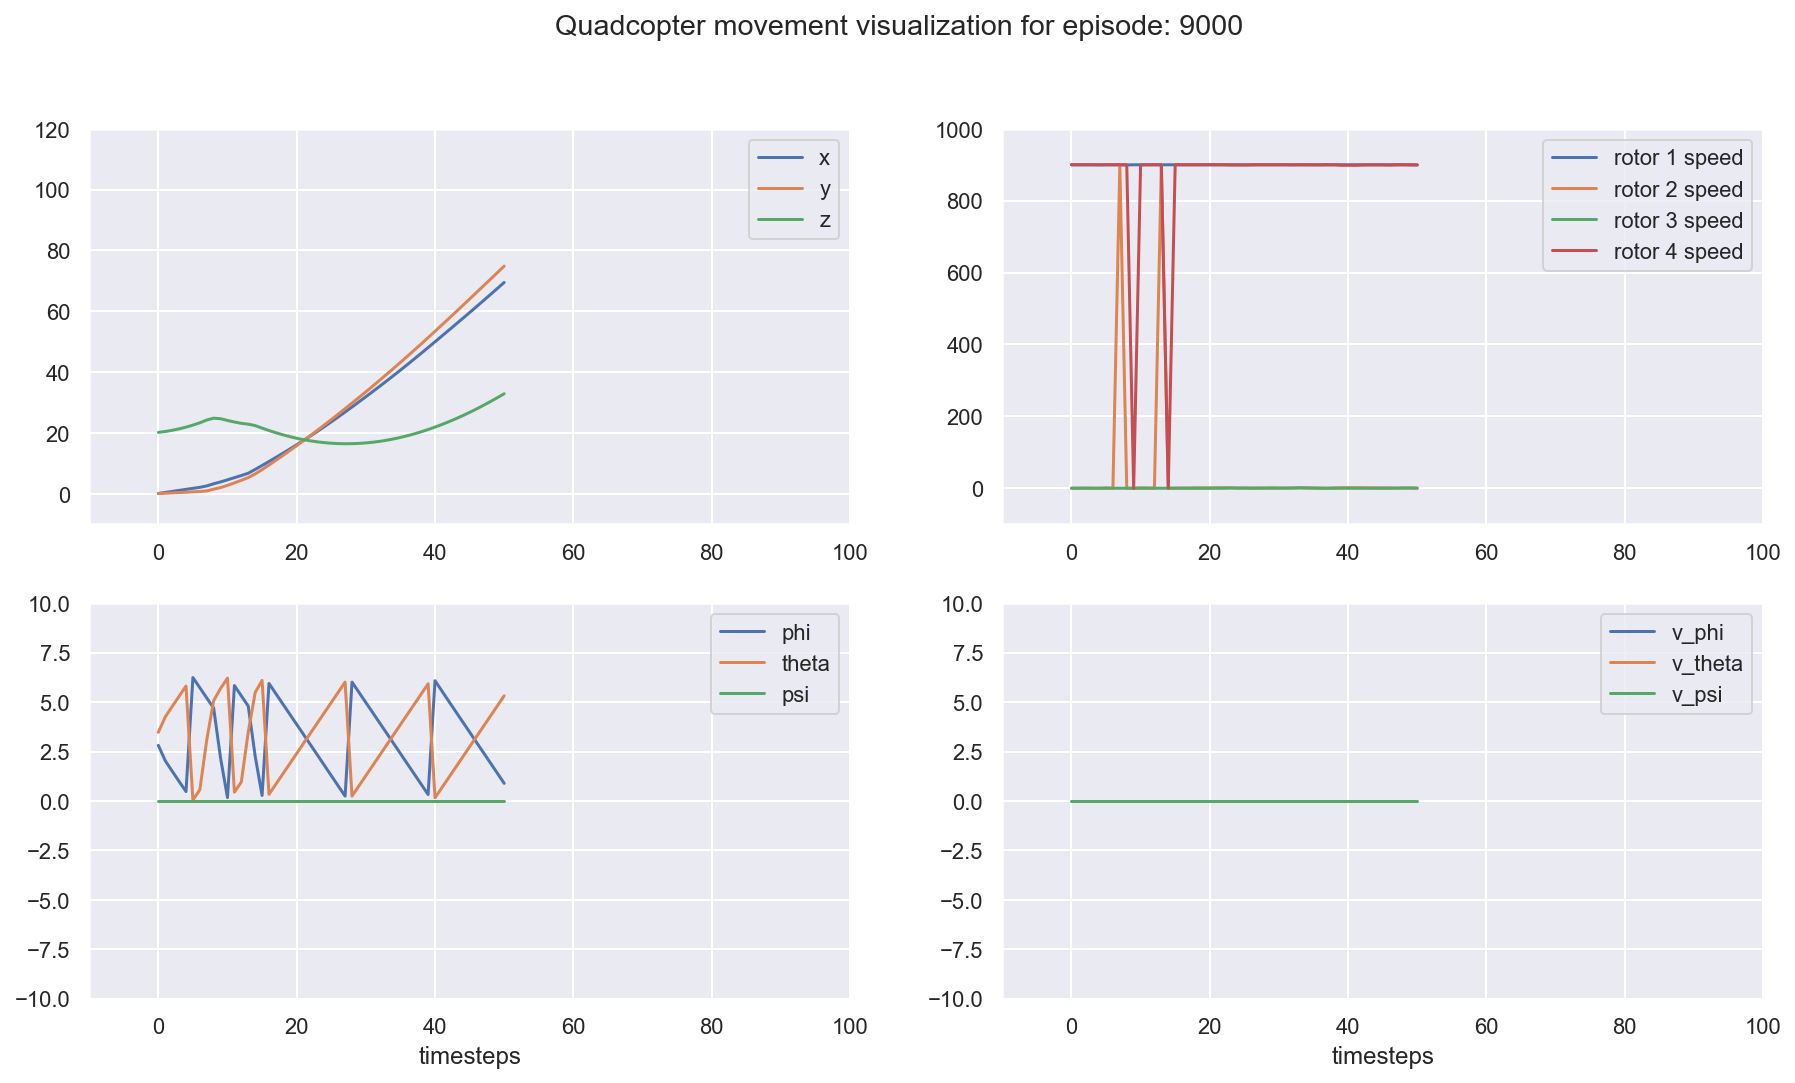

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 9200	 Avg reward: 138.12	 Current reward: 168.72	 Episode length: 51



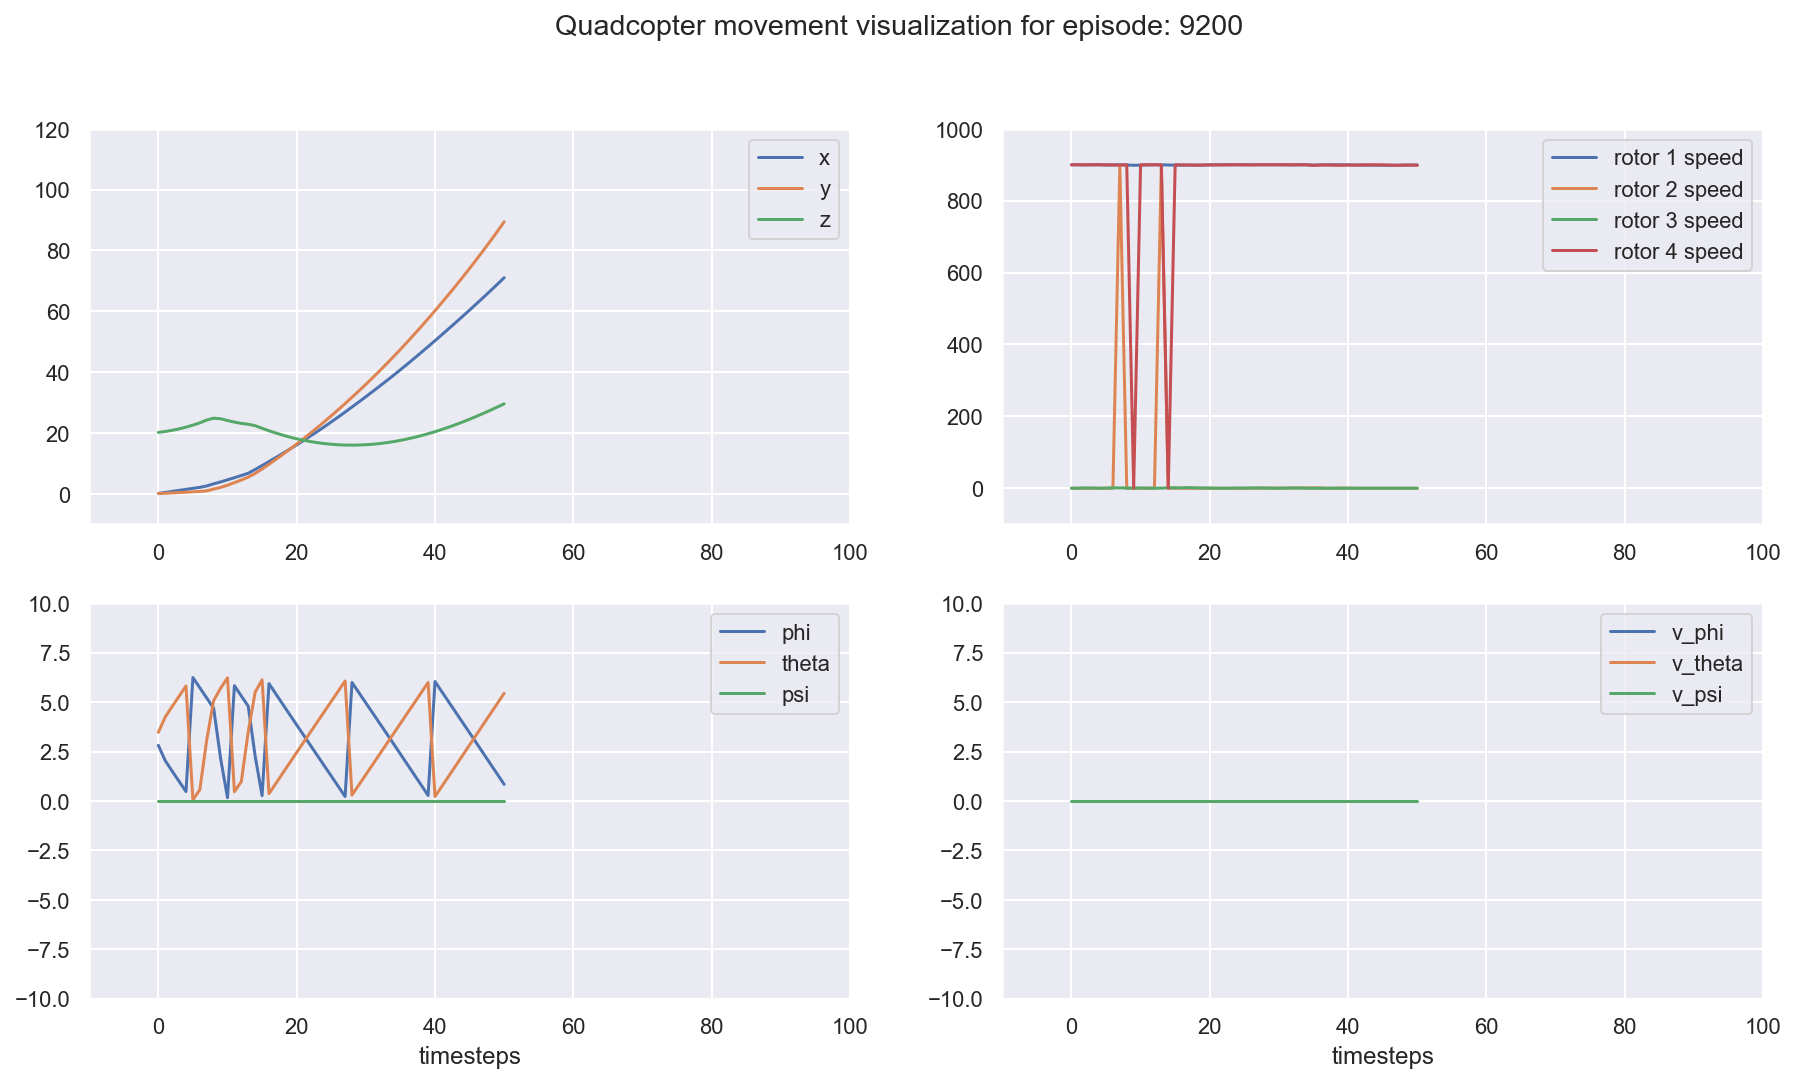

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 9400	 Avg reward: 144.05	 Current reward: 168.37	 Episode length: 51



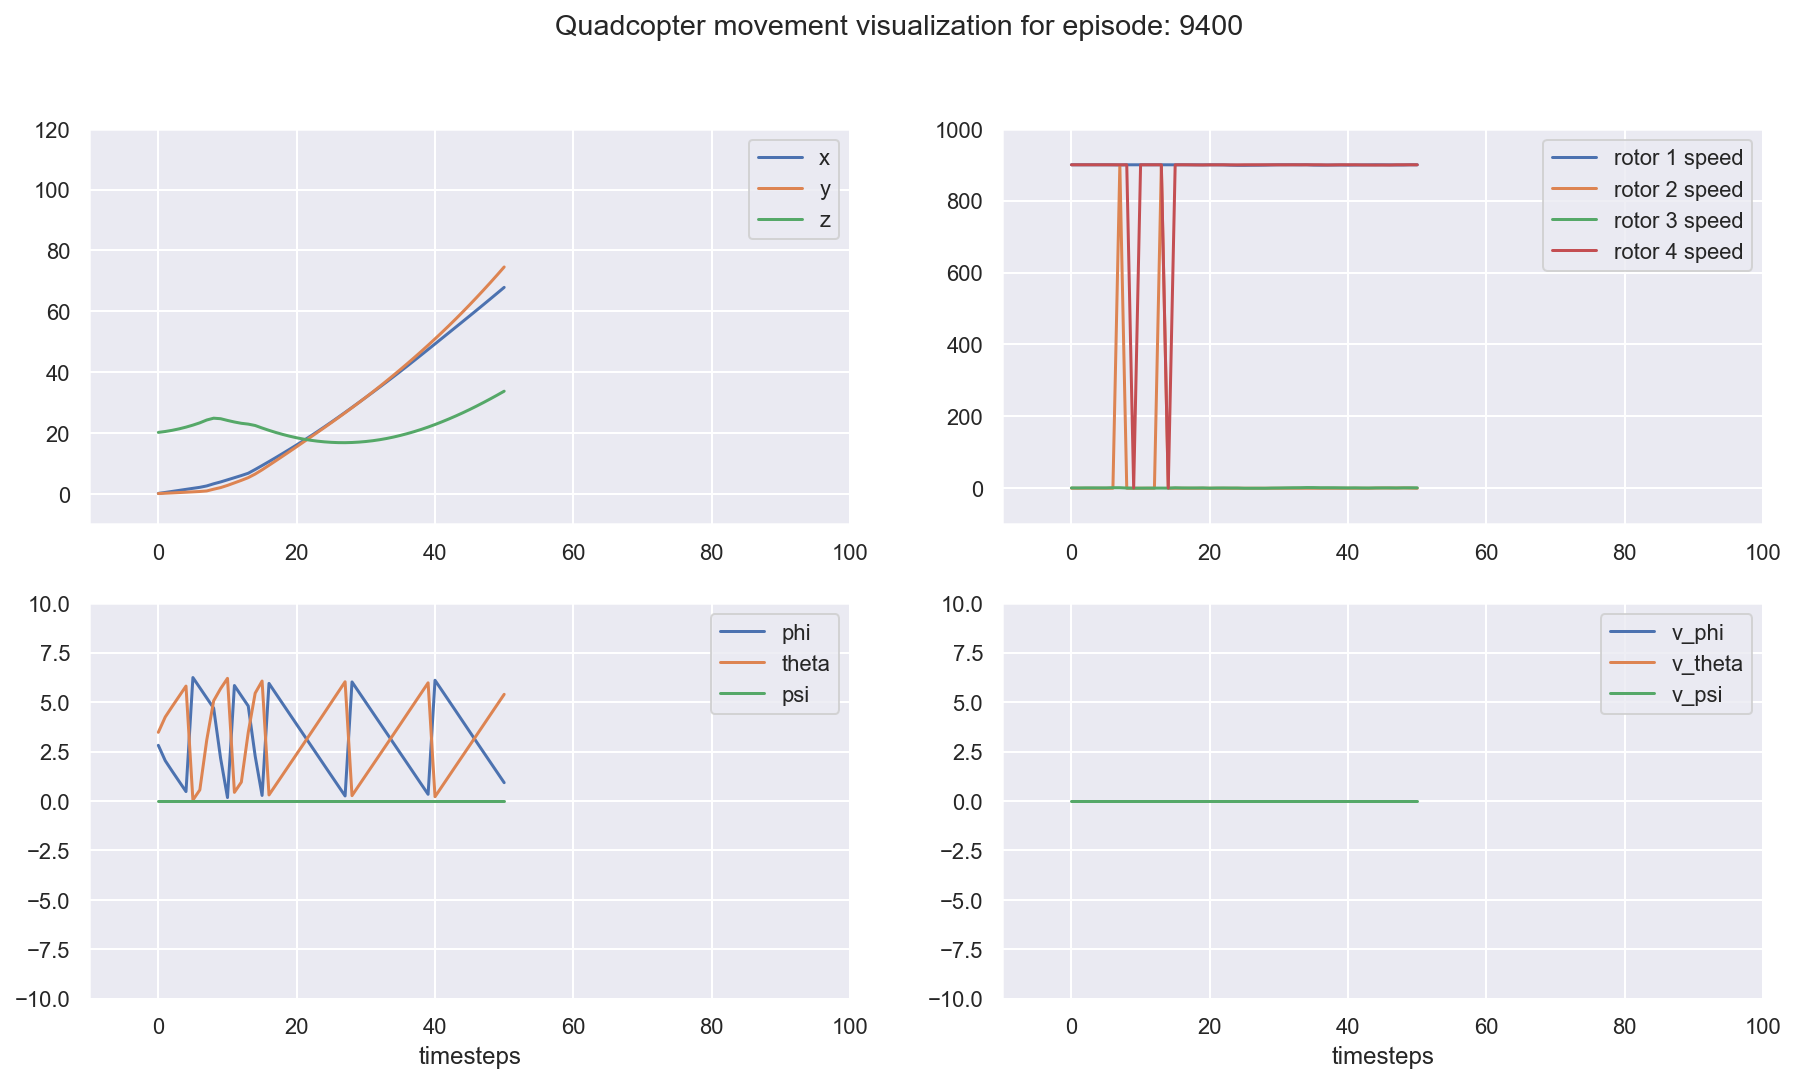

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 9600	 Avg reward: 166.32	 Current reward: 167.05	 Episode length: 51



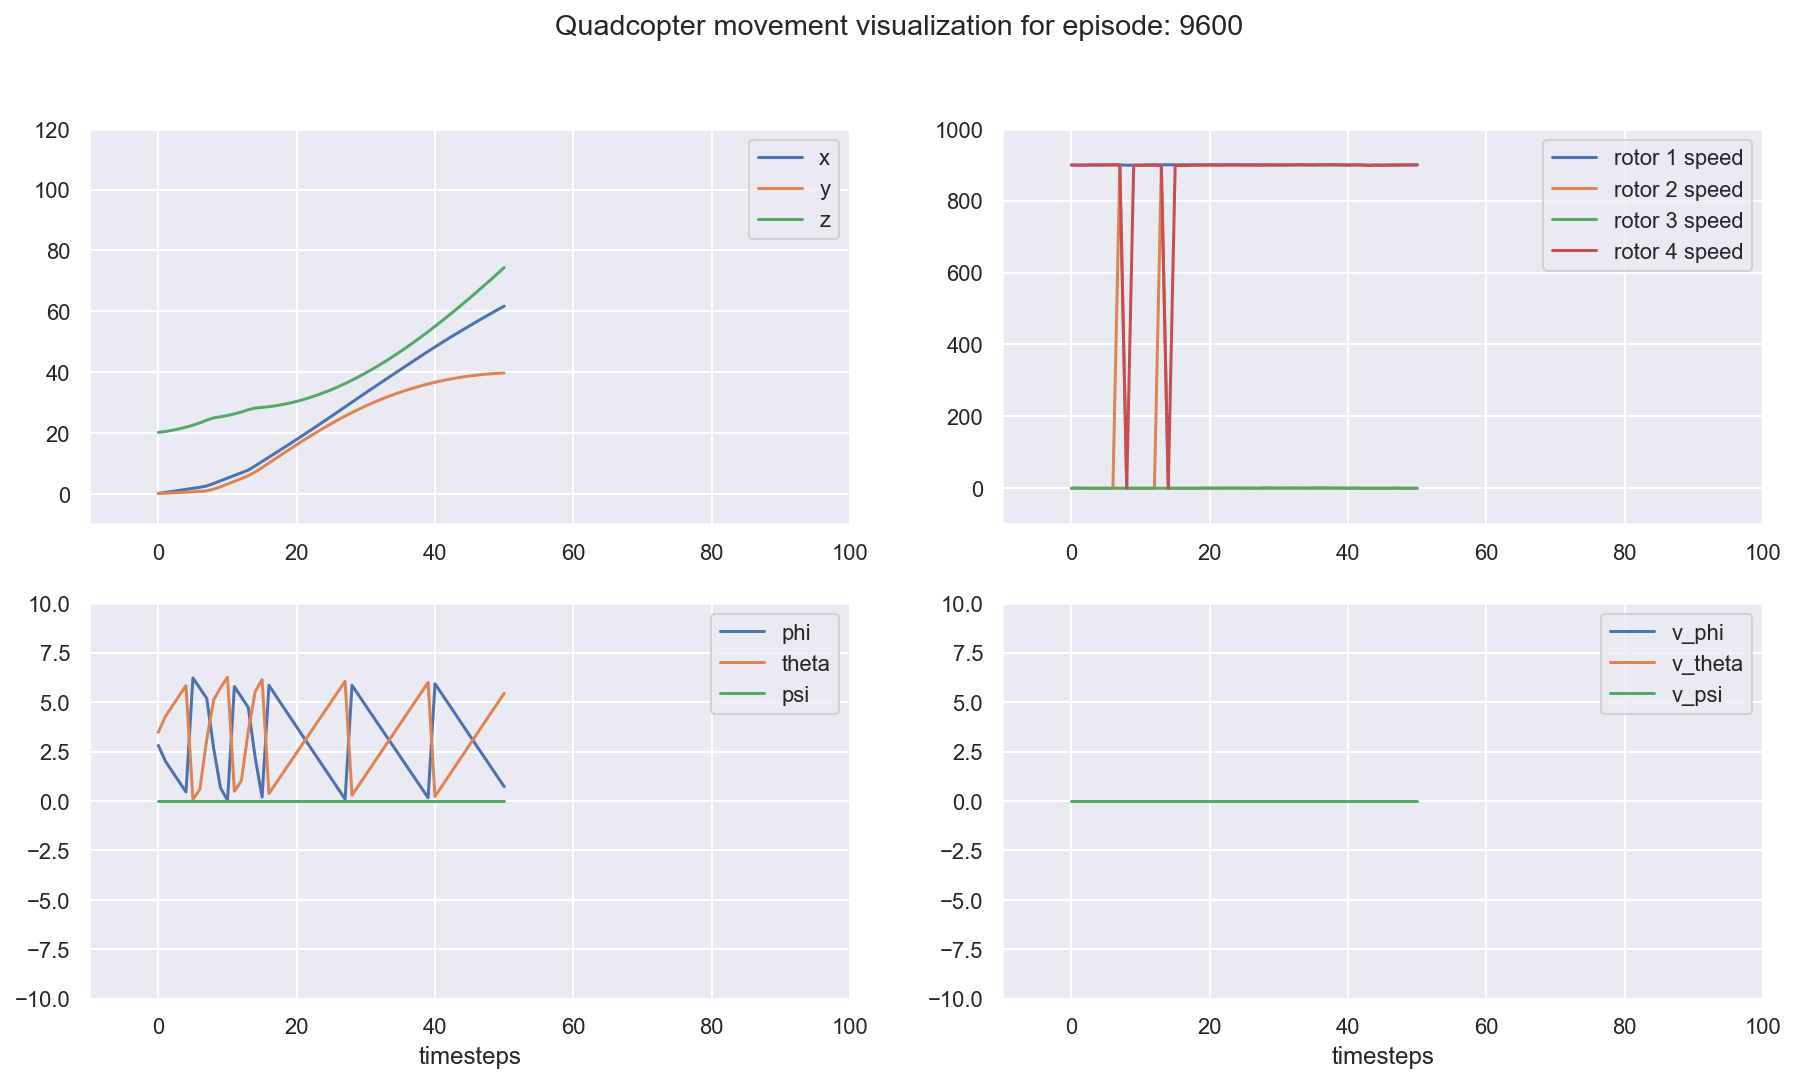

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 9800	 Avg reward: 164.94	 Current reward: 166.72	 Episode length: 51



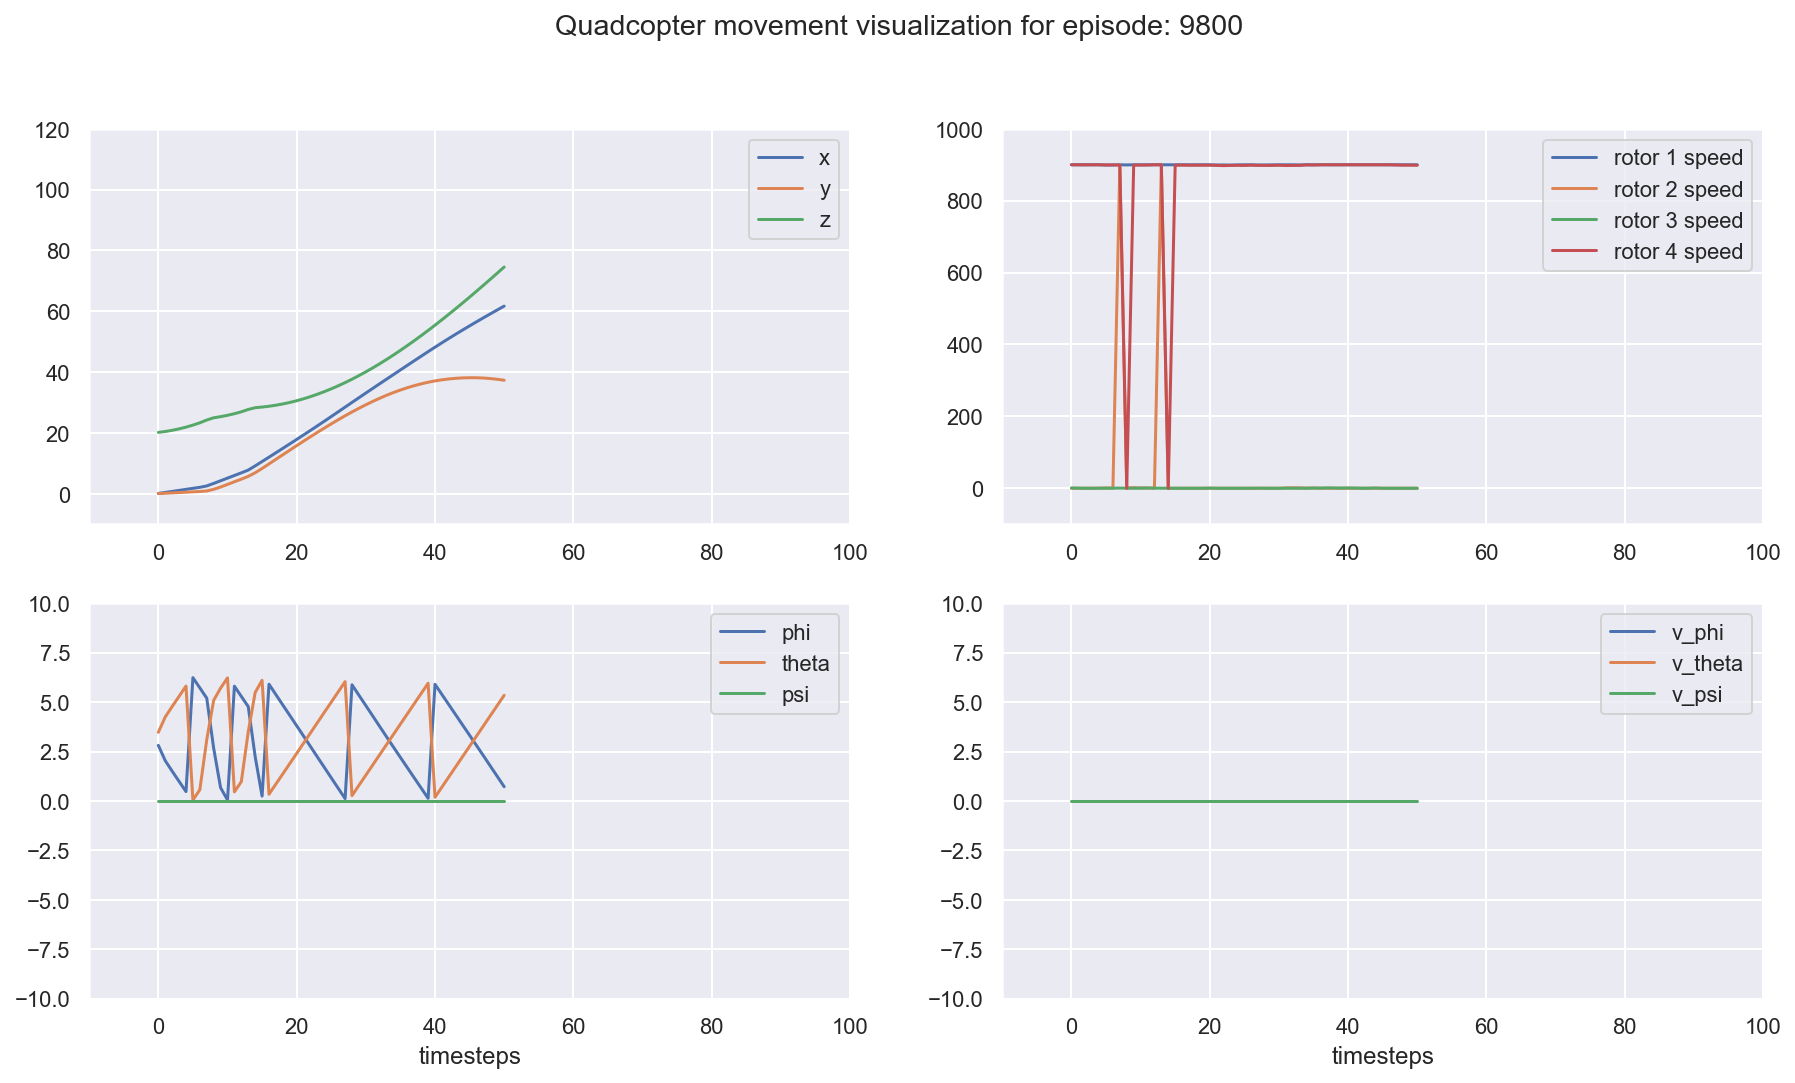

C:\Users\ljah1\anaconda3\envs\Torch3_7\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [13]:
# train the ddpg agent
scores, meam_scores = ddpg_train(agent,env=task,max_episodes=int(1e4),PRINT_EVERY=200,DISPLAY_EVERY=200)

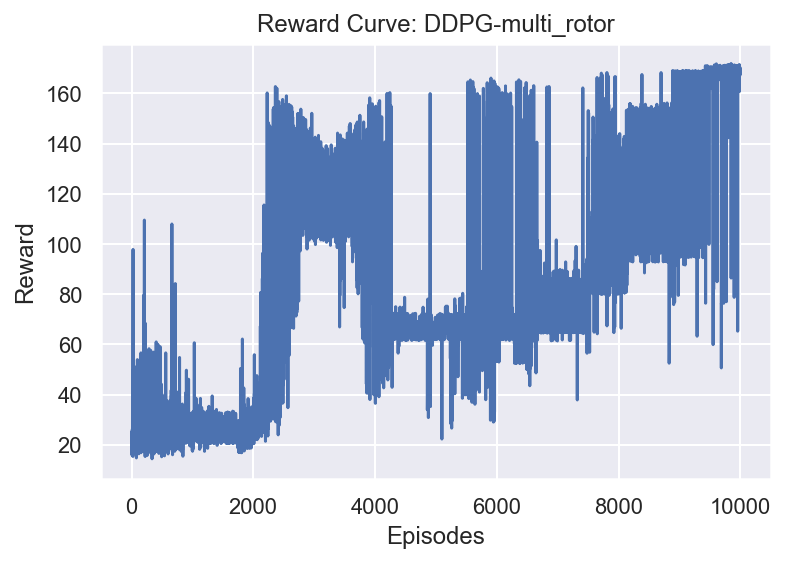

In [16]:

# plot the reward curve
fig = plt.figure()
plt.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward Curve: DDPG-multi_rotor')
plt.savefig('images/reward_curve_10iter.png',dpi=300)
plt.show()

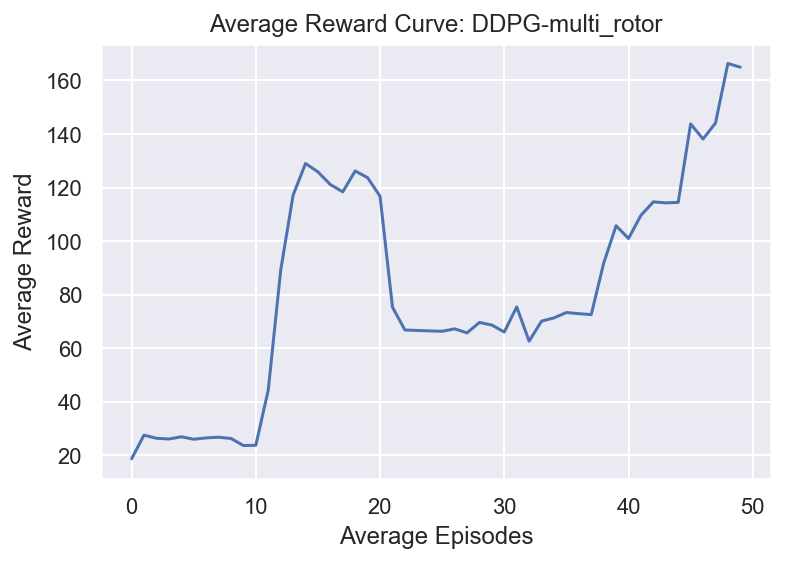

In [15]:
###Check the Average Reward value######
# plot the reward curve
fig = plt.figure()
plt.plot(meam_scores)
plt.xlabel('Average Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward Curve: DDPG-multi_rotor')
plt.savefig('images/Average_reward_curve-multi_rotor.png',dpi=300)
plt.show()


Reward: 168.14	 Episode length: 51



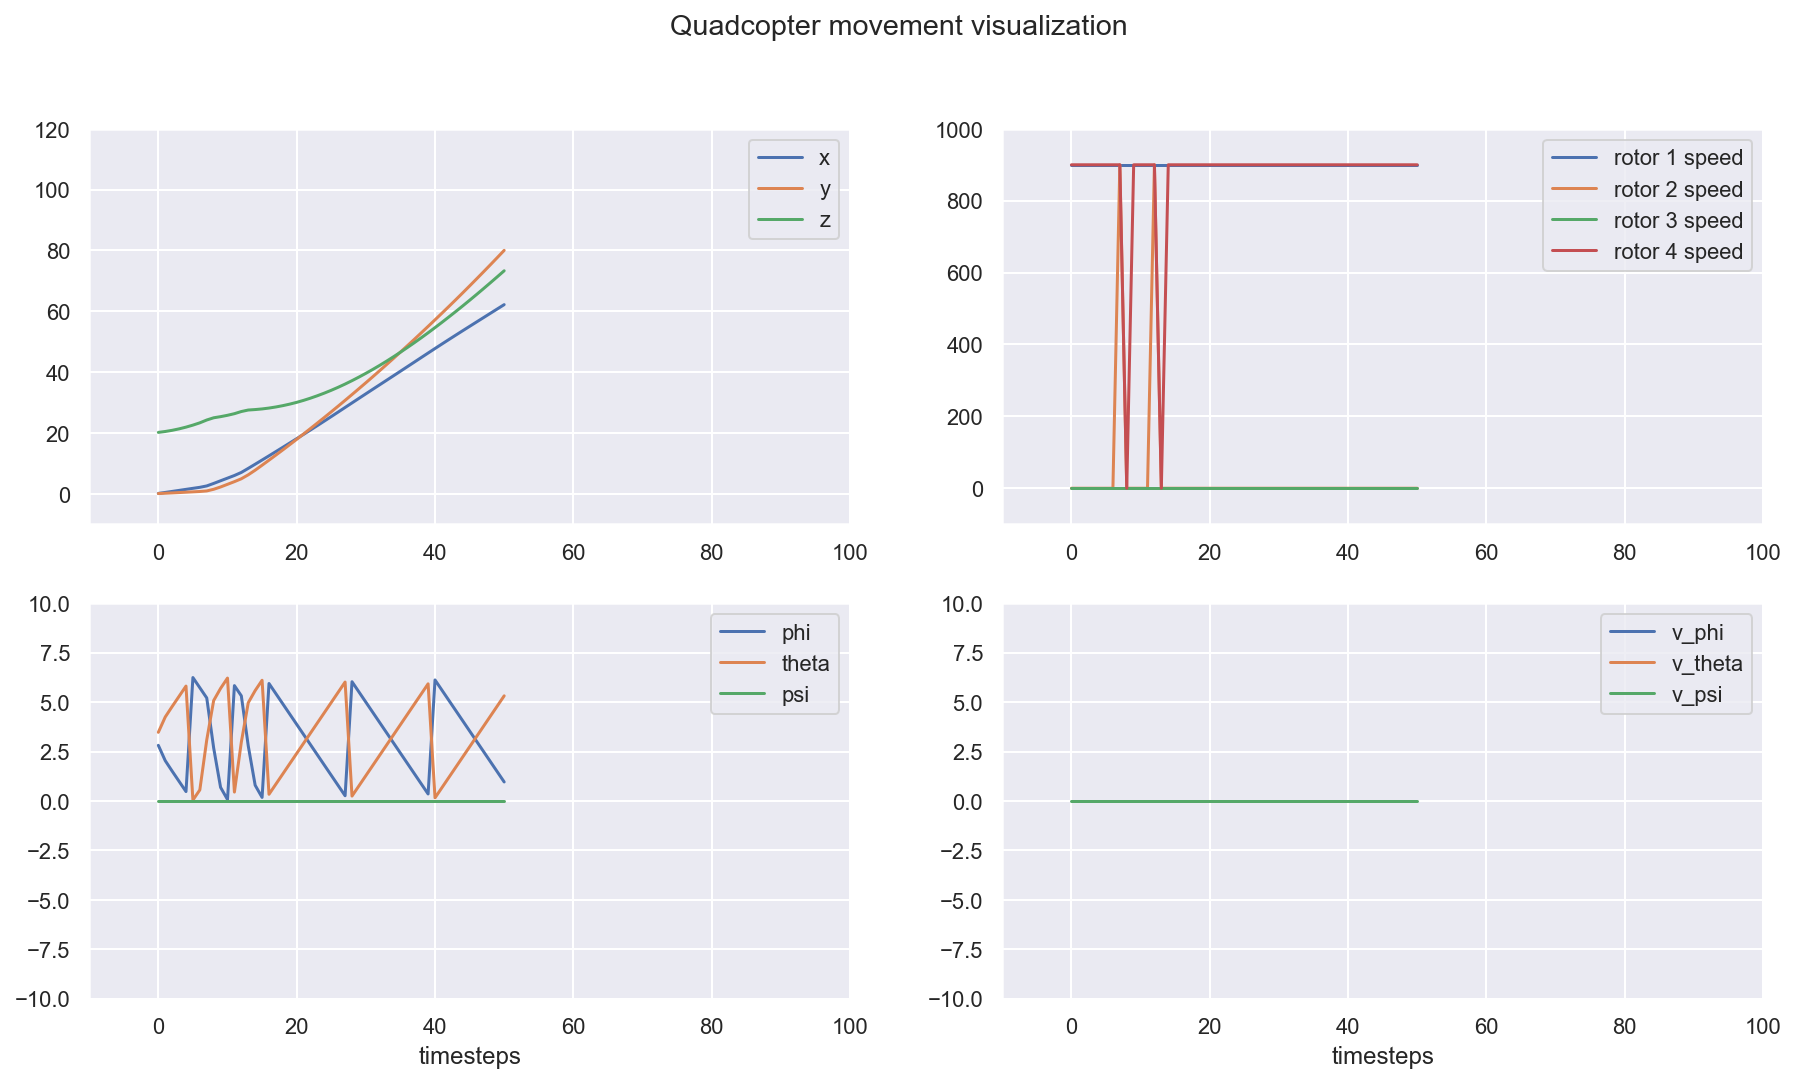

In [17]:
# initialize time step counter and online reward
time_step = 0
online_reward = 0

# initialize logs for storing quad movements
state_log, action_log, v_log, angular_v_log = [],[],[],[]

# reset agent
env = task
state = env.reset()

while True:
    # choose agent action
    action = agent.act(state,add_noise=False)

    # map action to appropriate range
    action_ = (env.action_high - env.action_low)*(action+1)/2 + env.action_low

    # take the next step in the env using the above action
    next_state,reward,done = env.step(action_)

    # update quad movement logs
    state_log.append(env.sim.pose)
    action_log.append(action_)
    v_log.append(env.sim.v)
    angular_v_log.append(env.sim.angular_v)

    # update online reward and time-step counter
    online_reward += reward
    time_step += 1

    # update state
    state = next_state

    if done:
        break

# print training progress
print ("Reward: {:.2f}\t Episode length: {}\n".format(online_reward,time_step))

# visualize quad movements
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# plot (x,y,z) movements of the quad
state_log = np.array(state_log)
labels = ['x','y','z']
for i in range(len(labels)):
    ax[0,0].plot(state_log[:,i],label=labels[i])
ax[0,0].set_ylim([-10,120])
ax[0,0].set_xlim([-10,100])
ax[0,0].legend()
#ax[0,0].set_xlabel('timesteps')

# plot rotor speeds of the quad
action_log = np.array(action_log)
labels = ['rotor 1 speed','rotor 2 speed','rotor 3 speed','rotor 4 speed']
for i in range(len(labels)):
    ax[0,1].plot(action_log[:,i],label=labels[i])
ax[0,1].set_ylim([-100,1000])
ax[0,1].set_xlim([-10,100])
ax[0,1].legend()
#ax[0,1].set_xlabel('timesteps')

# plot movements of the quad along the euler angles (phi,theta,psi)
labels = ['phi','theta','psi']
for i in range(len(labels)):
    ax[1,0].plot(state_log[:,3+i],label=labels[i])
ax[1,0].set_ylim([-10,10])
ax[1,0].set_xlim([-10,100])
ax[1,0].legend()
ax[1,0].set_xlabel('timesteps')

# plot angular velocities of the quad along the 3 main axis
angular_v_log = np.array(angular_v_log)
labels = ['v_phi','v_theta','v_psi']
for i in range(len(labels)):
    ax[1,1].plot(angular_v_log[:,i],label=labels[i])
ax[1,1].set_ylim([-10,10])
ax[1,1].set_xlim([-10,100])
ax[1,1].legend()
ax[1,1].set_xlabel('timesteps')

fig.suptitle("Quadcopter movement visualization")
plt.savefig("images/quad_movement-multi_rotor.png",dpi=300)
plt.show()